# Data preparation

## Import

In [1]:
try:
    import torch
    print(f"torch version: {torch.__version__}")
except:
    print("Error")
try:
    from torchinfo import summary
except:
    print('torchinfo not installed.')    

from torch.optim import Adam
from torch import nn
from transformers import BertTokenizer
from transformers import BertModel

# Setup device agnostic code, use CUDA if avaliable
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = 'cpu'
device

torch version: 2.0.0


'cuda'

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from pathlib import Path
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import random
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#import custom module
import data_setup
import custom_train_val_loop
import test_set_evaluation
import save_model
import set_custom_seed


## Data Exploration

In [3]:
#import data
df_text = pd.read_csv('..\data\mtsamples.csv', dtype = str)
df_text.head()

description  \
0   A 23-year-old white female presents with comp...   
1           Consult for laparoscopic gastric bypass.   
2           Consult for laparoscopic gastric bypass.   
3                             2-D M-Mode. Doppler.     
4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4  1.  The left ventricular cavity size and wall ...   

                                            keywords  
0  allergy / immunology, allergic rhinitis, aller...  
1  bariatrics, laparoscopic gastric bypass, weigh...  
2  bariatrics, laparoscopic gastric bypass, heart...  
3  cardiovascular / pulmonary, 2-d m-mode, dopple...  
4  cardiovascular / pulmonary, 2-d, doppler, echo...

In [4]:
#extract only the allowed two column
df_text = df_text.loc[:,['medical_specialty', 'transcription']]
df_text.head()

medical_specialty  \
0         Allergy / Immunology   
1                   Bariatrics   
2                   Bariatrics   
3   Cardiovascular / Pulmonary   
4   Cardiovascular / Pulmonary   

                                       transcription  
0  SUBJECTIVE:,  This 23-year-old white female pr...  
1  PAST MEDICAL HISTORY:, He has difficulty climb...  
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...  
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...  
4  1.  The left ventricular cavity size and wall ...

In [5]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4999 non-null   object
 1   transcription      4966 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [6]:
#There are 33 null object. We can just drop it.
df_text.dropna(inplace= True)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4966 non-null   object
 1   transcription      4966 non-null   object
dtypes: object(2)
memory usage: 116.4+ KB


### Dealing with duplicate and labels

In [7]:
#Check for duplicate
df_text.duplicated(subset='transcription', keep='first').sum()

2609

We have 2609 duplicate transcription? That's a lot. Let's look at what they are.

In [8]:
datadup = df_text[df_text.duplicated(subset='transcription', keep=False)].sort_values(by='transcription')
datadup

medical_specialty  \
874                    Surgery   
3577          Gastroenterology   
719                    Surgery   
110                    Urology   
2598   Obstetrics / Gynecology   
...                        ...   
2972                 Neurology   
3193     Hematology - Oncology   
3077                   Letters   
876                    Surgery   
3583          Gastroenterology   

                                          transcription  
874   1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...  
3577  1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...  
719   1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...  
110   1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...  
2598  1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...  
...                                                 ...  
2972  XYZ,RE:  ABC,MEDICAL RECORD#:  123,Dear Dr. XY...  
3193  XYZ,RE:  ABC,MEDICAL RECORD#:  123,Dear Dr. XY...  
3077  XYZ,RE:  ABC,MEDICAL RECORD#:  123,Dear Dr. XY...  
876   without difficulty, into the upper GI tract.  ...  
3583  without difficulty, into the upper GI tract.  ...  

[4759 rows x 2 columns]

OK, due to the original data being for multilabel classification, there are 2 problems.
- Document type such as "Consult - History and Phy.",  "SOAP / Chart / Progress Notes" or " Emergency Room Reports" overlap with specialty.
- Specialty can overlap such as "Surgey", "Neuro surgery" and "Radiology"

Since the instruction requires modification of data to make it support multiclass classification by selecting only the first label, we will deal with the label first.

In [9]:
#Strip white space
cols = ['medical_specialty', 'transcription']
df_text[cols] = df_text[cols].applymap(lambda x: x.strip())

#See all unique value for column and count
print(df_text.medical_specialty.value_counts())

Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Psychiatry / Psychology            53
Office Notes                       50
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

Data is dominated by surgery. There are also some weird specialty such as 'SOAP / Chart / Progress Notes' or 'Letter'. Let's look into what it is.

In [10]:
print("Sample of SOAP specialty")
print(df_text.loc[df_text.medical_specialty == 'SOAP / Chart / Progress Notes', 'transcription'].sample(3).values)
print("\nSample of Letter specialty")
print(df_text.loc[df_text.medical_specialty == 'Letters', 'transcription'].sample(3).values)
print("\nSample of IME-QME-Work Comp etc. specialty")
print(df_text.loc[df_text.medical_specialty == 'IME-QME-Work Comp etc.', 'transcription'].sample(3).values)

print("\nSample of Surgery specialty")
print(df_text.loc[df_text.medical_specialty == 'Surgery', 'transcription'].sample(3).values)


Sample of SOAP specialty
['CHIEF COMPLAINT: , MGUS.,HISTORY OF PRESENT ILLNESS:,  This is an extremely pleasant 86-year-old gentleman, who I follow for his MGUS.  I initially saw him for thrombocytopenia when his ANC was 1300.  A bone marrow biopsy was obtained.  Interestingly enough, at the time of his bone marrow biopsy, his hemoglobin was 13.0 and his white blood cell count was 6.5 with a platelet count of 484,000.  His bone marrow biopsy showed a normal cellular bone marrow; however, there were 10% plasma cells and we proceeded with the workup for a plasma cell dyscrasia.  All his tests came back as consistent with an MGUS.,Overall, he is doing well.  Since I last saw him, he tells me that he has had onset of atrial fibrillation.  He has now started going to the gym two times per week, and has lost over 10 pounds.  He has a good energy level and his ECOG performance status is 0.  He denies any fever, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change i

It appears that there are some label which are not medical specialty but rather "document type". Upon examination, they should be removed. They are:
- SOAP / Chart / Progress Notes
- Discharge Summary
- Emergency Room Reports
- Office Notes
- Letters
- IME-QME-Work Comp etc.- Consult - History and Phy.

Also, given that the objective is to alleviate waiting times and predict which area of medical specialty to focus on and predict the medical specialty that the patient should seek help, the following would be dropped as well.
- Radiology (It is never the primary specialty to care for the patient.)
- Lab Medicine - Pathology (Same reason as above)
- Chiropractic (Alternative medicine is harmful to patients and I'm not going to build a model which send the patient to alternative medicine out of spite)
- Autopsy (It's a corpse, duh.)


In [11]:
# Create a boolean mask that is True for rows where the "medical_specialty" column contains the desired string.
mask = df_text['medical_specialty'].str.contains('SOAP / Chart / Progress Notes|Discharge Summary|Emergency Room Reports|Office Notes|Letters|IME-QME-Work Comp etc.|Consult - History and Phy.|Radiology|Chiropractic|Autopsy|Lab Medicine - Pathology', case=False) #| is an OR operator in re

# Find the index of the rows that match the mask and drop it
rows_to_drop = df_text.loc[mask].index
df_text= df_text.drop(rows_to_drop).reset_index(drop = True) #Don't forget to reset index.
df_text

medical_specialty  \
0           Allergy / Immunology   
1                     Bariatrics   
2                     Bariatrics   
3     Cardiovascular / Pulmonary   
4     Cardiovascular / Pulmonary   
...                          ...   
3704        Allergy / Immunology   
3705        Allergy / Immunology   
3706        Allergy / Immunology   
3707        Allergy / Immunology   
3708        Allergy / Immunology   

                                          transcription  
0     SUBJECTIVE:,  This 23-year-old white female pr...  
1     PAST MEDICAL HISTORY:, He has difficulty climb...  
2     HISTORY OF PRESENT ILLNESS: , I have seen ABC ...  
3     2-D M-MODE: , ,1.  Left atrial enlargement wit...  
4     1.  The left ventricular cavity size and wall ...  
...                                                 ...  
3704  HISTORY:,  I had the pleasure of meeting and e...  
3705  ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...  
3706  SUBJECTIVE: , This is a 42-year-old white fema...  
3707  CHIEF COMPLAINT: , This 5-year-old male presen...  
3708  HISTORY: , A 34-year-old male presents today s...  

[3709 rows x 2 columns]

Surgery                       1088
Cardiovascular / Pulmonary     371
Orthopedic                     355
General Medicine               259
Gastroenterology               224
Neurology                      223
Urology                        156
Obstetrics / Gynecology        155
ENT - Otolaryngology            96
Neurosurgery                    94
Hematology - Oncology           90
Ophthalmology                   83
Nephrology                      81
Pediatrics - Neonatal           70
Pain Management                 61
Psychiatry / Psychology         53
Podiatry                        47
Dermatology                     29
Cosmetic / Plastic Surgery      27
Dentistry                       27
Physical Medicine - Rehab       21
Sleep Medicine                  20
Endocrinology                   19
Bariatrics                      18
Rheumatology                    10
Diets and Nutritions            10
Speech - Language                9
Allergy / Immunology             7
Hospice - Palliative

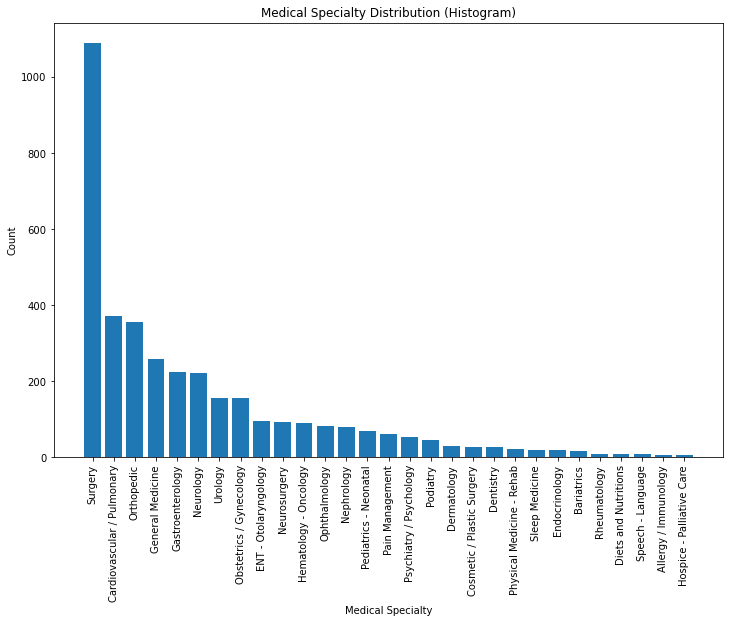

In [12]:
#See result after dropping
print(df_text.medical_specialty.value_counts())

specialty_name_for_count = df_text.medical_specialty.value_counts().index
specialty_count_for_count = df_text.medical_specialty.value_counts().values

#bar chart. Not great to look at. Never use Pie chart!
# plt.figure(figsize=(10, 12), facecolor='white')
# plt.pie(specialty_count_for_count, labels=specialty_name_for_count, autopct='%.1f%%', startangle=90, pctdistance=0.85, labeldistance=1.1)
# plt.axis('equal')
# plt.title('Medical Specialty Distribution (Pie Chart)')
# # Create a circle at the center of the pie chart
# centre_circle = plt.Circle((0, 0), 0.70, fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)
# plt.show()

# Histogram
plt.figure(figsize=(12, 8), facecolor='white')
plt.bar(specialty_name_for_count, specialty_count_for_count)
plt.xlabel('Medical Specialty')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Medical Specialty Distribution (Histogram)')
plt.show()

Alright, now we take care of problem number 2, overlapping specialty.

In [13]:
#See duplicate again
datadup = df_text[df_text.duplicated(subset='transcription', keep=False)].sort_values(by='transcription')
datadup

medical_specialty  \
3017         Gastroenterology   
864                   Surgery   
711                   Surgery   
109                   Urology   
2086  Obstetrics / Gynecology   
...                       ...   
1450    Pediatrics - Neonatal   
2633    Hematology - Oncology   
2459                Neurology   
866                   Surgery   
3022         Gastroenterology   

                                          transcription  
3017  1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...  
864   1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...  
711   1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...  
109   1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...  
2086  1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...  
...                                                 ...  
1450  XYZ, M.D. ,Suite 123, ABC Avenue ,City, STATE ...  
2633  XYZ,RE:  ABC,MEDICAL RECORD#:  123,Dear Dr. XY...  
2459  XYZ,RE:  ABC,MEDICAL RECORD#:  123,Dear Dr. XY...  
866   without difficulty, into the upper GI tract.  ...  
3022  without difficulty, into the upper GI tract.  ...  

[2662 rows x 2 columns]

It looks like there can be up to 3 overlapping specialty, and here in lies the problem, which I will demonstrate.

If we use keep first...

There are 2296 samples left.
There are 0 duplicate(s) left
Surgery                       976
General Medicine              230
Cardiovascular / Pulmonary    173
Urology                       156
Neurology                     128
Orthopedic                    109
Pediatrics - Neonatal          56
Psychiatry / Psychology        53
Hematology - Oncology          52
Obstetrics / Gynecology        52
Pain Management                46
Nephrology                     43
Gastroenterology               42
ENT - Otolaryngology           24
Physical Medicine - Rehab      21
Sleep Medicine                 20
Ophthalmology                  19
Podiatry                       19
Bariatrics                     18
Rheumatology                   10
Diets and Nutritions           10
Dermatology                    10
Speech - Language               9
Hospice - Palliative Care       6
Allergy / Immunology            4
Dentistry                       4
Endocrinology                   3
Cosmetic / Plastic Surg

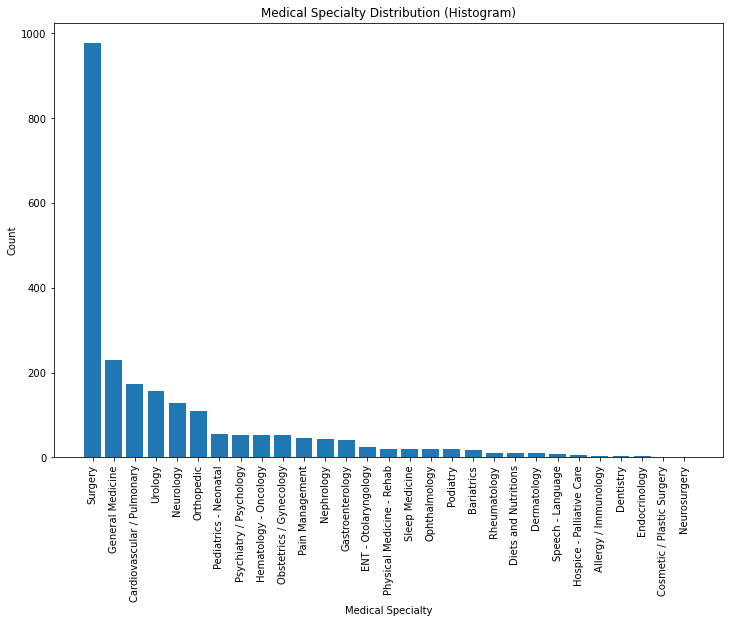

In [14]:
df_temp_1 = df_text.copy()
df_temp_1 = df_temp_1.drop_duplicates(subset = 'transcription', keep = 'first').reset_index(drop = True)
print(f'There are {len(df_temp_1)} samples left.')

duplicate_count = len(df_temp_1[df_temp_1.duplicated(subset='transcription', keep=False)])
print(f'There are {duplicate_count} duplicate(s) left')


specialty_count_1 = df_temp_1.medical_specialty.value_counts()

#See result after dropping
print(df_temp_1.medical_specialty.value_counts())

specialty_name_for_count = df_temp_1.medical_specialty.value_counts().index
specialty_count_for_count = df_temp_1.medical_specialty.value_counts().values


# Histogram
plt.figure(figsize=(12, 8), facecolor='white')
plt.bar(specialty_name_for_count, specialty_count_for_count)
plt.xlabel('Medical Specialty')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Medical Specialty Distribution (Histogram)')
plt.show()

Surgery dwarf other specialty. Many pecialties (orthopedic, neurosurgery, urology, gyne) which requires surgical procedure are subset of surgery. <br>
However, there are also case where there is no subspecialties (surgery is the sold specialty) <br>
For this task, it should be good to prioritze the sub-specialty since the patient can get the fastest treatment that way. One way to do this is to NOT choose surgery in the duplicate data. <br>
Note that, however, as a generalist, surgery also consult other subspecialties as he see fit (which might include multiple specialties) so pigeonholing the patient into one sub-specialty first can have detrimental effect. <br>
Also, the same can be said about general medicine as well but the effect in this data is not as much as surgery.

Let's Just try keeping last to see if the distribution is better.

There are 2296 samples left.
There are 0 duplicate(s) left
Cardiovascular / Pulmonary    369
Orthopedic                    268
General Medicine              228
Gastroenterology              221
Neurology                     215
Obstetrics / Gynecology       142
Surgery                       142
ENT - Otolaryngology           88
Ophthalmology                  75
Hematology - Oncology          73
Neurosurgery                   67
Nephrology                     64
Pain Management                50
Psychiatry / Psychology        42
Urology                        41
Pediatrics - Neonatal          32
Dermatology                    27
Cosmetic / Plastic Surgery     27
Dentistry                      26
Podiatry                       24
Endocrinology                  19
Bariatrics                     13
Diets and Nutritions           10
Rheumatology                    8
Speech - Language               7
Allergy / Immunology            7
Hospice - Palliative Care       4
Sleep Medicine         

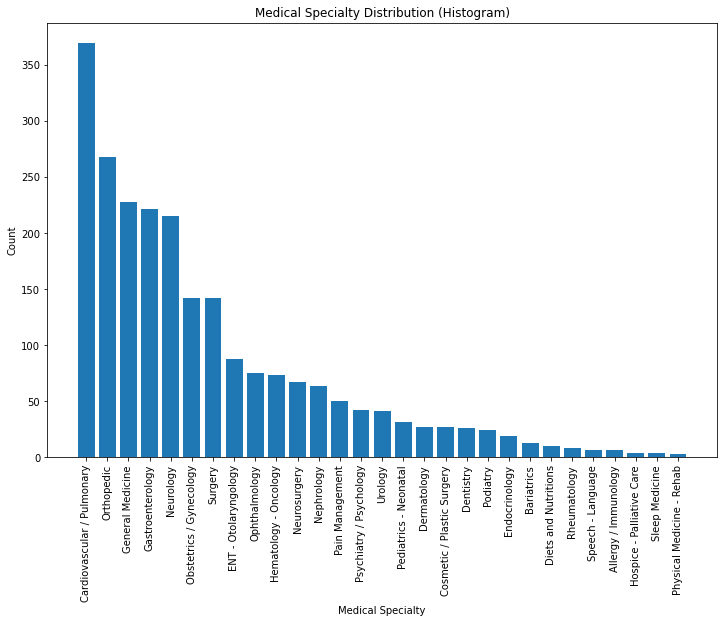

In [15]:
df_temp_1 = df_text.copy()
df_temp_1 = df_temp_1.drop_duplicates(subset = 'transcription', keep = 'last').reset_index(drop = True)
print(f'There are {len(df_temp_1)} samples left.')

duplicate_count = len(df_temp_1[df_temp_1.duplicated(subset='transcription', keep=False)])
print(f'There are {duplicate_count} duplicate(s) left')

specialty_count_2 = df_temp_1.medical_specialty.value_counts()

#See result after dropping
print(df_temp_1.medical_specialty.value_counts())

specialty_name_for_count = df_temp_1.medical_specialty.value_counts().index
specialty_count_for_count = df_temp_1.medical_specialty.value_counts().values


# Histogram
plt.figure(figsize=(12, 8), facecolor='white')
plt.bar(specialty_name_for_count, specialty_count_for_count)
plt.xlabel('Medical Specialty')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Medical Specialty Distribution (Histogram)')
plt.show()

Hey, that's actually much better!<br>
Next I will try sorting first so that rows which contain surgery and general_medicine appear last and using keep first to prioritize subspecialty.

There are 2296 samples left.
There are 0 duplicate(s) left
Cardiovascular / Pulmonary    344
Orthopedic                    313
General Medicine              200
Gastroenterology              193
Urology                       156
Obstetrics / Gynecology       154
Neurology                     128
ENT - Otolaryngology           87
Ophthalmology                  83
Hematology - Oncology          70
Nephrology                     66
Pediatrics - Neonatal          64
Pain Management                59
Psychiatry / Psychology        53
Surgery                        50
Podiatry                       47
Neurosurgery                   46
Dermatology                    28
Dentistry                      26
Physical Medicine - Rehab      21
Sleep Medicine                 20
Bariatrics                     18
Cosmetic / Plastic Surgery     16
Endocrinology                  15
Rheumatology                   10
Diets and Nutritions           10
Speech - Language               9
Hospice - Palliative Ca

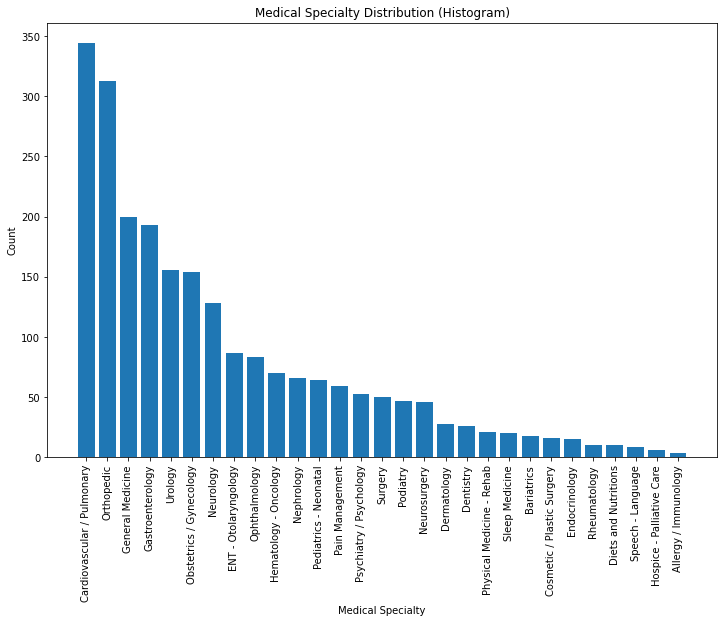

In [16]:
df_temp_1 = df_text.copy()

# Create a boolean mask that is True for rows where the "medical_specialty" column contains the word "surgery"
mask_1 = df_temp_1['medical_specialty'] == "Surgery"
mask_2 = df_temp_1['medical_specialty'] == "General Medicine"

# Convert the boolean mask to integer values (True -> 1, False -> 0)
mask_int_1 = mask_1.astype(int)
mask_int_2 = mask_2.astype(int)


# Create a new temporary column in the DataFrame based on the boolean mask (True -> 1, False -> 0)
df_temp_1['temp_sort_column_1'] = mask_1.astype(int)
df_temp_1['temp_sort_column_2'] = mask_2.astype(int)

#Sort it using the two mask
df_temp_1 = df_temp_1.sort_values(by=['temp_sort_column_1', 'temp_sort_column_2'] )

#Drop duplicate while keeping the first entry. This should prioritize sub-specialty and drop surgery and general medicine if there are subspecialties.
df_temp_1 = df_temp_1.drop_duplicates(subset='transcription', keep='first')


print(f'There are {len(df_temp_1)} samples left.')

duplicate_count = len(df_temp_1[df_temp_1.duplicated(subset='transcription', keep=False)])
print(f'There are {duplicate_count} duplicate(s) left')


specialty_count_3 = df_temp_1.medical_specialty.value_counts()
#See result after dropping
print(df_temp_1.medical_specialty.value_counts())

specialty_name_for_count = df_temp_1.medical_specialty.value_counts().index
specialty_count_for_count = df_temp_1.medical_specialty.value_counts().values


# Histogram
plt.figure(figsize=(12, 8), facecolor='white')
plt.bar(specialty_name_for_count, specialty_count_for_count)
plt.xlabel('Medical Specialty')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Medical Specialty Distribution (Histogram)')
plt.show()

See the difference between each method.

In [17]:
specialty_count = pd.DataFrame(data = {'Keep first':specialty_count_1, 'Keep last':specialty_count_2, 'Mask':specialty_count_3})
specialty_count['Keep first - Keep last'] = specialty_count['Keep first'] - specialty_count['Keep last']
specialty_count['Keep last - Mask'] = specialty_count['Keep last'] - specialty_count['Mask']
specialty_count

Keep first  Keep last  Mask  \
Allergy / Immunology                 4          7     4   
Bariatrics                          18         13    18   
Cardiovascular / Pulmonary         173        369   344   
Cosmetic / Plastic Surgery           2         27    16   
Dentistry                            4         26    26   
Dermatology                         10         27    28   
Diets and Nutritions                10         10    10   
ENT - Otolaryngology                24         88    87   
Endocrinology                        3         19    15   
Gastroenterology                    42        221   193   
General Medicine                   230        228   200   
Hematology - Oncology               52         73    70   
Hospice - Palliative Care            6          4     6   
Nephrology                          43         64    66   
Neurology                          128        215   128   
Neurosurgery                         1         67    46   
Obstetrics / Gynecology             52        142   154   
Ophthalmology                       19         75    83   
Orthopedic                         109        268   313   
Pain Management                     46         50    59   
Pediatrics - Neonatal               56         32    64   
Physical Medicine - Rehab           21          3    21   
Podiatry                            19         24    47   
Psychiatry / Psychology             53         42    53   
Rheumatology                        10          8    10   
Sleep Medicine                      20          4    20   
Speech - Language                    9          7     9   
Surgery                            976        142    50   
Urology                            156         41   156   

                            Keep first - Keep last  Keep last - Mask  
Allergy / Immunology                            -3                 3  
Bariatrics                                       5                -5  
Cardiovascular / Pulmonary                    -196                25  
Cosmetic / Plastic Surgery                     -25                11  
Dentistry                                      -22                 0  
Dermatology                                    -17                -1  
Diets and Nutritions                             0                 0  
ENT - Otolaryngology                           -64                 1  
Endocrinology                                  -16                 4  
Gastroenterology                              -179                28  
General Medicine                                 2                28  
Hematology - Oncology                          -21                 3  
Hospice - Palliative Care                        2                -2  
Nephrology                                     -21                -2  
Neurology                                      -87                87  
Neurosurgery                                   -66                21  
Obstetrics / Gynecology                        -90               -12  
Ophthalmology                                  -56                -8  
Orthopedic                                    -159               -45  
Pain Management                                 -4                -9  
Pediatrics - Neonatal                           24               -32  
Physical Medicine - Rehab                       18               -18  
Podiatry                                        -5               -23  
Psychiatry / Psychology                         11               -11  
Rheumatology                                     2                -2  
Sleep Medicine                                  16               -16  
Speech - Language                                2                -2  
Surgery                                        834                92  
Urology                                        115              -115

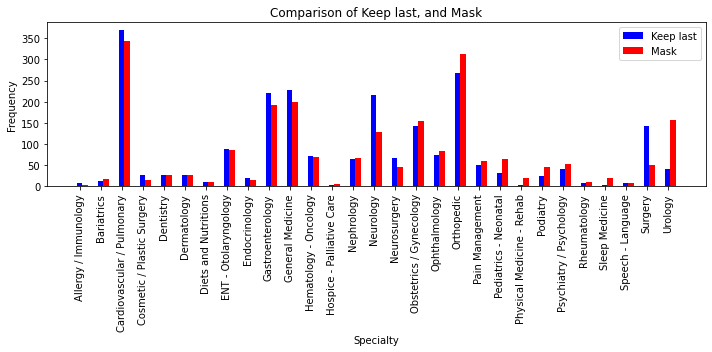

In [18]:
#Histogram comparison
fig, ax = plt.subplots(figsize=(10, 5))
# Define the width of the bars and the number of bars
bar_width = 0.25
num_bars = len(specialty_count)

# Generate the x-axis positions for each group of bars
x_positions = np.arange(num_bars)

# Plot the bars for each column with different colors
#ax.bar(x_positions, specialty_count['Keep first'], width=bar_width, label='Keep first', color='blue')
ax.bar(x_positions + bar_width, specialty_count['Keep last'], width=bar_width, label='Keep last', color='blue')
ax.bar(x_positions + 2 * bar_width, specialty_count['Mask'], width=bar_width, label='Mask', color='red')

# Set the title and labels
ax.set_title('Comparison of Keep last, and Mask')
ax.set_xlabel('Specialty')
ax.set_ylabel('Frequency')

# Set the x-axis tick positions and labels
ax.set_xticks(x_positions + bar_width)
ax.set_xticklabels(specialty_count.index, rotation=90)

# Add a legend
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


To determine objectively which distribution is better, I would need to calculate the dispersion of each distribution but by eyeballing I can see that keep last or mask yielded better distribution. <br>
The main difference between keep last and Mask is urology and surgery. Since we are prioritizing sub-specialty, I would go with mask method.

However, as you can see, there are extreme minority class such as Allergy, and training won't be useful for these classes. I will merge the classes using arbitary threshold of < 10 samples after dropping duplicate. That means all classes with < 1 sample will be merged into 1 "Other" classes.

In [19]:
#Get the half-cleaned df
df_clean_1 = df_temp_1.copy().reset_index(drop = True).drop(columns = ['temp_sort_column_1', 'temp_sort_column_2'])
df_clean_1

medical_specialty  \
0           Allergy / Immunology   
1                     Bariatrics   
2                     Bariatrics   
3     Cardiovascular / Pulmonary   
4     Cardiovascular / Pulmonary   
...                          ...   
2291                     Surgery   
2292                     Surgery   
2293                     Surgery   
2294                     Surgery   
2295                     Surgery   

                                          transcription  
0     SUBJECTIVE:,  This 23-year-old white female pr...  
1     PAST MEDICAL HISTORY:, He has difficulty climb...  
2     HISTORY OF PRESENT ILLNESS: , I have seen ABC ...  
3     2-D M-MODE: , ,1.  Left atrial enlargement wit...  
4     1.  The left ventricular cavity size and wall ...  
...                                                 ...  
2291  PREOPERATIVE DIAGNOSIS:,  Atypical ductal hype...  
2292  PREOPERATIVE DIAGNOSIS: , Bilateral inguinal h...  
2293  PREOPERATIVE DIAGNOSES:,1.  Impingement syndro...  
2294  PREOPERATIVE DIAGNOSES,1.  Acute appendicitis....  
2295  PREOPERATIVE DIAGNOSES,1.  Incomplete surgical...  

[2296 rows x 2 columns]

In [20]:
print('List of specialties with < 10 samples:')
print(list(
    df_clean_1.medical_specialty.value_counts().index[df_clean_1.medical_specialty.value_counts() < 10]
    ))

List of specialties with < 10 samples:
['Speech - Language', 'Hospice - Palliative Care', 'Allergy / Immunology']


In [21]:
# Create a boolean mask that is True for rows where the "medical_specialty" column contains the desired string.
mask = df_clean_1['medical_specialty'].str.contains('Speech - Language|Hospice - Palliative Care|Radiology|Chiropractic|Allergy / Immunology', case=False) #| is an OR operator in re

# Find the index of the rows that match the mask and change it to Others.
rows_to_change = df_clean_1.loc[mask].index

df_clean_1.loc[rows_to_change, 'medical_specialty'] = 'Others'
df_clean_1['medical_specialty'].value_counts()

Cardiovascular / Pulmonary    344
Orthopedic                    313
General Medicine              200
Gastroenterology              193
Urology                       156
Obstetrics / Gynecology       154
Neurology                     128
ENT - Otolaryngology           87
Ophthalmology                  83
Hematology - Oncology          70
Nephrology                     66
Pediatrics - Neonatal          64
Pain Management                59
Psychiatry / Psychology        53
Surgery                        50
Podiatry                       47
Neurosurgery                   46
Dermatology                    28
Dentistry                      26
Physical Medicine - Rehab      21
Sleep Medicine                 20
Others                         19
Bariatrics                     18
Cosmetic / Plastic Surgery     16
Endocrinology                  15
Rheumatology                   10
Diets and Nutritions           10
Name: medical_specialty, dtype: int64

Finally, we can encode the label for multiclass classification.

In [22]:
# Encode label
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_clean_1.loc[:,'medical_specialty'])
print(f'The classes are:\n{le.classes_}')

#create key to map class to index
class_number = dict(enumerate(le.classes_))
print(f'\nThe key for each class is:\n{class_number}')


df_clean_1['label'] = le.transform(df_clean_1.loc[:,'medical_specialty'])
df_clean_1

The classes are:
['Bariatrics' 'Cardiovascular / Pulmonary' 'Cosmetic / Plastic Surgery'
 'Dentistry' 'Dermatology' 'Diets and Nutritions' 'ENT - Otolaryngology'
 'Endocrinology' 'Gastroenterology' 'General Medicine'
 'Hematology - Oncology' 'Nephrology' 'Neurology' 'Neurosurgery'
 'Obstetrics / Gynecology' 'Ophthalmology' 'Orthopedic' 'Others'
 'Pain Management' 'Pediatrics - Neonatal' 'Physical Medicine - Rehab'
 'Podiatry' 'Psychiatry / Psychology' 'Rheumatology' 'Sleep Medicine'
 'Surgery' 'Urology']

The key for each class is:
{0: 'Bariatrics', 1: 'Cardiovascular / Pulmonary', 2: 'Cosmetic / Plastic Surgery', 3: 'Dentistry', 4: 'Dermatology', 5: 'Diets and Nutritions', 6: 'ENT - Otolaryngology', 7: 'Endocrinology', 8: 'Gastroenterology', 9: 'General Medicine', 10: 'Hematology - Oncology', 11: 'Nephrology', 12: 'Neurology', 13: 'Neurosurgery', 14: 'Obstetrics / Gynecology', 15: 'Ophthalmology', 16: 'Orthopedic', 17: 'Others', 18: 'Pain Management', 19: 'Pediatrics - Neonatal', 20: 

medical_specialty  \
0                         Others   
1                     Bariatrics   
2                     Bariatrics   
3     Cardiovascular / Pulmonary   
4     Cardiovascular / Pulmonary   
...                          ...   
2291                     Surgery   
2292                     Surgery   
2293                     Surgery   
2294                     Surgery   
2295                     Surgery   

                                          transcription  label  
0     SUBJECTIVE:,  This 23-year-old white female pr...     17  
1     PAST MEDICAL HISTORY:, He has difficulty climb...      0  
2     HISTORY OF PRESENT ILLNESS: , I have seen ABC ...      0  
3     2-D M-MODE: , ,1.  Left atrial enlargement wit...      1  
4     1.  The left ventricular cavity size and wall ...      1  
...                                                 ...    ...  
2291  PREOPERATIVE DIAGNOSIS:,  Atypical ductal hype...     25  
2292  PREOPERATIVE DIAGNOSIS: , Bilateral inguinal h...     25  
2293  PREOPERATIVE DIAGNOSES:,1.  Impingement syndro...     25  
2294  PREOPERATIVE DIAGNOSES,1.  Acute appendicitis....     25  
2295  PREOPERATIVE DIAGNOSES,1.  Incomplete surgical...     25  

[2296 rows x 3 columns]

For further visualization, we should do some preprocessing first.

In [23]:
df_visual = df_clean_1.copy() #copy df just for visualization

In [24]:
# Lowercase and remove punctuation in transcriptions
df_visual['transcription_for_visual'] = df_visual['transcription'].str.lower().str.replace('[^\w\s]', ' ')
# regex note
# [] = set of characters.
# ^ caret = negates the set, meaning "match anything that is NOT these characters".
# \w = Matches any alphanumeric character; include lowercase letters (a-z), uppercase letters (A-Z), digits (0-9), and the underscore (_).
# \s = Matches any whitespace character which include spaces, tabs, and line breaks

#replace dpuble space with single space

# repalce new line with white space
#df_visual['transcription_for_visual'] = df_visual['transcription_for_visual'].str.replace(r'\r', ' ')
# replace multiple white spaces with a single white space
#df_visual['transcription_for_visual'] = df_visual['transcription_for_visual'].str.replace(r'^\s+|\s+$', '').str.replace(r'\s+', ' ') 

# Tokenize the words in each row
df_visual['transcription_for_visual'] = df_visual['transcription_for_visual'].apply(word_tokenize)
df_visual.head(5)

C:\Users\Nut19\AppData\Local\Temp\ipykernel_25392\2374810878.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_visual['transcription_for_visual'] = df_visual['transcription'].str.lower().str.replace('[^\w\s]', ' ')


medical_specialty  \
0                      Others   
1                  Bariatrics   
2                  Bariatrics   
3  Cardiovascular / Pulmonary   
4  Cardiovascular / Pulmonary   

                                       transcription  label  \
0  SUBJECTIVE:,  This 23-year-old white female pr...     17   
1  PAST MEDICAL HISTORY:, He has difficulty climb...      0   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...      0   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...      1   
4  1.  The left ventricular cavity size and wall ...      1   

                            transcription_for_visual  
0  [subjective, this, 23, year, old, white, femal...  
1  [past, medical, history, he, has, difficulty, ...  
2  [history, of, present, illness, i, have, seen,...  
3  [2, d, m, mode, 1, left, atrial, enlargement, ...  
4  [1, the, left, ventricular, cavity, size, and,...

Seeing the vocab and the token size to get an idea of how large our corpus is.

In [25]:
# See number of vocab and tokens

# create df of vocabulary with all characters
# code from aj wanchana workshop

vocab_all = pd.Series([item for sublist in df_visual.transcription_for_visual for item in sublist]).value_counts().reset_index() #gets all token and counts the frequency
vocab_all = vocab_all.rename(columns = {'index':'token', 0:'freq'})
print(f'Total vocab size (before removing stop words/lemmatization) = {len(vocab_all)} words')
print(f'Total token (before removing stop words/lemmatization) = {vocab_all.freq.sum()} tokens')
vocab_all.head(100) #display the first 100 and change the name of the column when displayed

Total vocab size (before removing stop words/lemmatization) = 22005 words
Total token (before removing stop words/lemmatization) = 1090420 tokens


token   freq
0    the  67974
1    and  37388
2    was  33135
3     of  26340
4     to  22864
..   ...    ...
95  back   1141
96   who   1116
97   one   1116
98    mm   1114
99   out   1093

[100 rows x 2 columns]

We now have a sense on the size of our corpus. However, since the stop word dominate our word frequency table, it might not gives us insight on what our corpus actually is composed of. To do that, we will remove stop words and perform lemmatization.

In [26]:
# Remove stop words
stop_words = set(stopwords.words('english')) 
df_visual['transcription_for_visual'] = df_visual['transcription_for_visual'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df_visual['transcription_for_visual'] = df_visual['transcription_for_visual'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

#Random example sentence
i = 0
while i < 5:
    random_number = random.randint(0, len(df_visual['transcription_for_visual'])-1)
    print('\n--Before pre-process--')
    print(df_visual['transcription'][random_number])
    print('--After  pre-process--')
    print(df_visual['transcription_for_visual'][random_number])
    i += 1
    


--Before pre-process--
PREOPERATIVE DIAGNOSIS (ES):, Cataract, right eye.,POSTOPERATIVE DIAGNOSIS (ES):, Cataract, right eye.,PROCEDURE:, Right phacoemulsification of cataract with intraocular lens implantation.,DESCRIPTION OF THE OPERATION:, Under topical anesthesia with monitored anesthesia care, the patient was prepped, draped and positioned under the operating microscope. A lid speculum was applied to the right eye, and a stab incision into the anterior chamber was done close to the limbus at about the 1 o'clock position with a Superblade, and Xylocaine 1% preservative free 0.25 mL was injected into the anterior chamber, which was then followed by Healon to deepen the anterior chamber. Using a keratome, another stab incision was done close to the limbus at about the 9 o'clock position and with the Utrata forceps, anterior capsulorrhexis was performed, and the torn anterior capsule was totally removed. Hydrodissection and hydrodelineation were performed with the tuberculin syringe 

Now we can see what our corpus is mainly composed of again.

In [27]:
# See number of vocab and tokens again after removing stop words and lemmatization

# create df of vocabulary with all characters
# code from aj wanchana workshop

vocab_all = pd.Series([item for sublist in df_visual.transcription_for_visual for item in sublist]).value_counts().reset_index() #gets all token and counts the frequency
vocab_all = vocab_all.rename(columns = {'index':'token', 0:'freq'})
print(f'Total vocab size (after removing stop words/lemmatization) = {len(vocab_all)} words')
print(f'Total token (after removing stop words/lemmatization) = {vocab_all.freq.sum()} tokens')
vocab_all.head(10) #display the first 10 and change the name of the column when displayed

Total vocab size (after removing stop words/lemmatization) = 20027 words
Total token (after removing stop words/lemmatization) = 663351 tokens


token   freq
0    patient  11051
1      right   5196
2       left   5128
3          2   4627
4          1   4494
5    history   4211
6  procedure   3879
7          0   3331
8     normal   3319
9          3   3308

Well, it is a medical transcription after all, so patient, history and procedure is to be expected. Though right, left and integers are not particularly informative.

Next, we are going to see the composition of each specialties.

In [28]:
# count number of tokens for each row
df_visual['token_number'] = df_visual['transcription_for_visual'].apply(len)
print(f'Average number of token for all rows is: {df_visual.token_number.mean():.0f}')
df_visual.head()

Average number of token for all rows is: 289


medical_specialty  \
0                      Others   
1                  Bariatrics   
2                  Bariatrics   
3  Cardiovascular / Pulmonary   
4  Cardiovascular / Pulmonary   

                                       transcription  label  \
0  SUBJECTIVE:,  This 23-year-old white female pr...     17   
1  PAST MEDICAL HISTORY:, He has difficulty climb...      0   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...      0   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...      1   
4  1.  The left ventricular cavity size and wall ...      1   

                            transcription_for_visual  token_number  
0  [subjective, 23, year, old, white, female, pre...           123  
1  [past, medical, history, difficulty, climbing,...           247  
2  [history, present, illness, seen, abc, today, ...           459  
3  [2, mode, 1, left, atrial, enlargement, left, ...            64  
4  [1, left, ventricular, cavity, size, wall, thi...           176

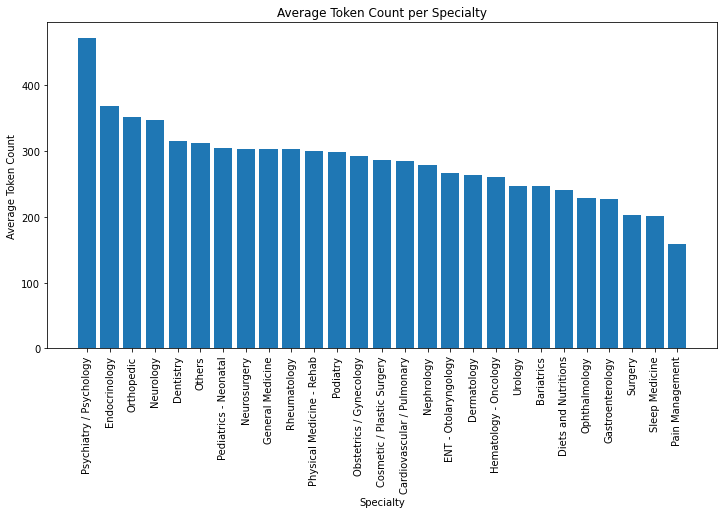

medical_specialty  token_number
22     Psychiatry / Psychology    472.207547
7                Endocrinology    369.266667
16                  Orthopedic    351.955272
12                   Neurology    347.187500
3                    Dentistry    314.884615
17                      Others    312.000000
19       Pediatrics - Neonatal    305.093750
13                Neurosurgery    303.869565
9             General Medicine    303.250000
23                Rheumatology    303.100000
20   Physical Medicine - Rehab    299.571429
21                    Podiatry    298.638298
14     Obstetrics / Gynecology    293.019481
2   Cosmetic / Plastic Surgery    286.875000
1   Cardiovascular / Pulmonary    284.674419
11                  Nephrology    279.409091
6         ENT - Otolaryngology    266.862069
4                  Dermatology    262.964286
10       Hematology - Oncology    261.142857
26                     Urology    246.769231
0                   Bariatrics    246.722222
5         Diets and Nutritions    240.600000
15               Ophthalmology    228.240964
8             Gastroenterology    226.808290
25                     Surgery    203.520000
24              Sleep Medicine    200.550000
18             Pain Management    158.711864

In [29]:
#Average number of token per specialty
temp_df = pd.DataFrame(df_visual.groupby('medical_specialty').token_number.mean().reset_index().sort_values('token_number', ascending = False))
plt.figure(figsize=(12, 6))
plt.bar(temp_df['medical_specialty'], temp_df['token_number'])
plt.title('Average Token Count per Specialty')
plt.xlabel('Specialty')
plt.ylabel('Average Token Count')
plt.xticks(rotation = 90)
plt.show()
temp_df

Plotting the top 10 token for each specialty

In [30]:
from collections import Counter
df_visual['word_freq'] = df_visual['transcription_for_visual'].apply(Counter)
#Counter takes an iterable and craete a dictionary where the key is a unique item in the iterable and the value of the kay is the count.
df_visual.head()

medical_specialty  \
0                      Others   
1                  Bariatrics   
2                  Bariatrics   
3  Cardiovascular / Pulmonary   
4  Cardiovascular / Pulmonary   

                                       transcription  label  \
0  SUBJECTIVE:,  This 23-year-old white female pr...     17   
1  PAST MEDICAL HISTORY:, He has difficulty climb...      0   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...      0   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...      1   
4  1.  The left ventricular cavity size and wall ...      1   

                            transcription_for_visual  token_number  \
0  [subjective, 23, year, old, white, female, pre...           123   
1  [past, medical, history, difficulty, climbing,...           247   
2  [history, present, illness, seen, abc, today, ...           459   
3  [2, mode, 1, left, atrial, enlargement, left, ...            64   
4  [1, left, ventricular, cavity, size, wall, thi...           176   

                                           word_freq  
0  {'subjective': 1, '23': 1, 'year': 1, 'old': 1...  
1  {'past': 2, 'medical': 1, 'history': 6, 'diffi...  
2  {'history': 7, 'present': 1, 'illness': 1, 'se...  
3  {'2': 3, 'mode': 1, '1': 2, 'left': 4, 'atrial...  
4  {'1': 2, 'left': 7, 'ventricular': 5, 'cavity'...

In [31]:
#sanity check for correctness of the count. Maybe copy to microsoft word and use find to see if the count matches
random_number = random.randint(0, len(df_visual['transcription_for_visual'])-1)
print(df_visual['transcription_for_visual'][random_number])
print(df_visual['word_freq'][random_number])

['postoperative', 'diagnosis', 'chronic', 'adenotonsillitis', 'procedure', 'performed', 'tonsillectomy', 'adenoidectomy', 'anesthesia', 'general', 'endotracheal', 'tube', 'estimated', 'blood', 'loss', 'minimum', 'le', '5', 'cc', 'specimen', 'right', 'left', 'tonsil', '2', 'adenoid', 'pad', '1', 'adenoid', 'specimen', 'complication', 'none', 'history', 'patient', '9', 'year', 'old', 'caucasian', 'male', 'history', 'recurrent', 'episode', 'adenotonsillitis', 'refractory', 'outpatient', 'antibiotic', 'therapy', 'patient', 'approximately', 'four', 'five', 'episode', 'adenotonsillitis', 'per', 'year', 'last', 'three', 'four', 'year', 'procedure', 'informed', 'consent', 'properly', 'obtained', 'patient', 'parent', 'patient', 'taken', 'operating', 'room', '3', 'placed', 'supine', 'position', 'placed', 'general', 'endotracheal', 'tube', 'anesthesia', 'department', 'anesthesia', 'bed', 'rolled', 'away', 'department', 'anesthesia', 'shoulder', 'roll', 'placed', 'beneath', 'shoulder', 'blade', 'b

In [32]:
# concatenate each word, count and frequency for each specialty into 1 big DF
new_df = pd.concat([pd.DataFrame({'word': list(freq.keys()), 'frequency': list(freq.values()), 'medical_specialty': specialty})
                    for specialty, freq in zip(df_visual['medical_specialty'], df_visual['word_freq'])])
new_df.head()

word  frequency medical_specialty
0  subjective          1            Others
1          23          1            Others
2        year          1            Others
3         old          1            Others
4       white          1            Others

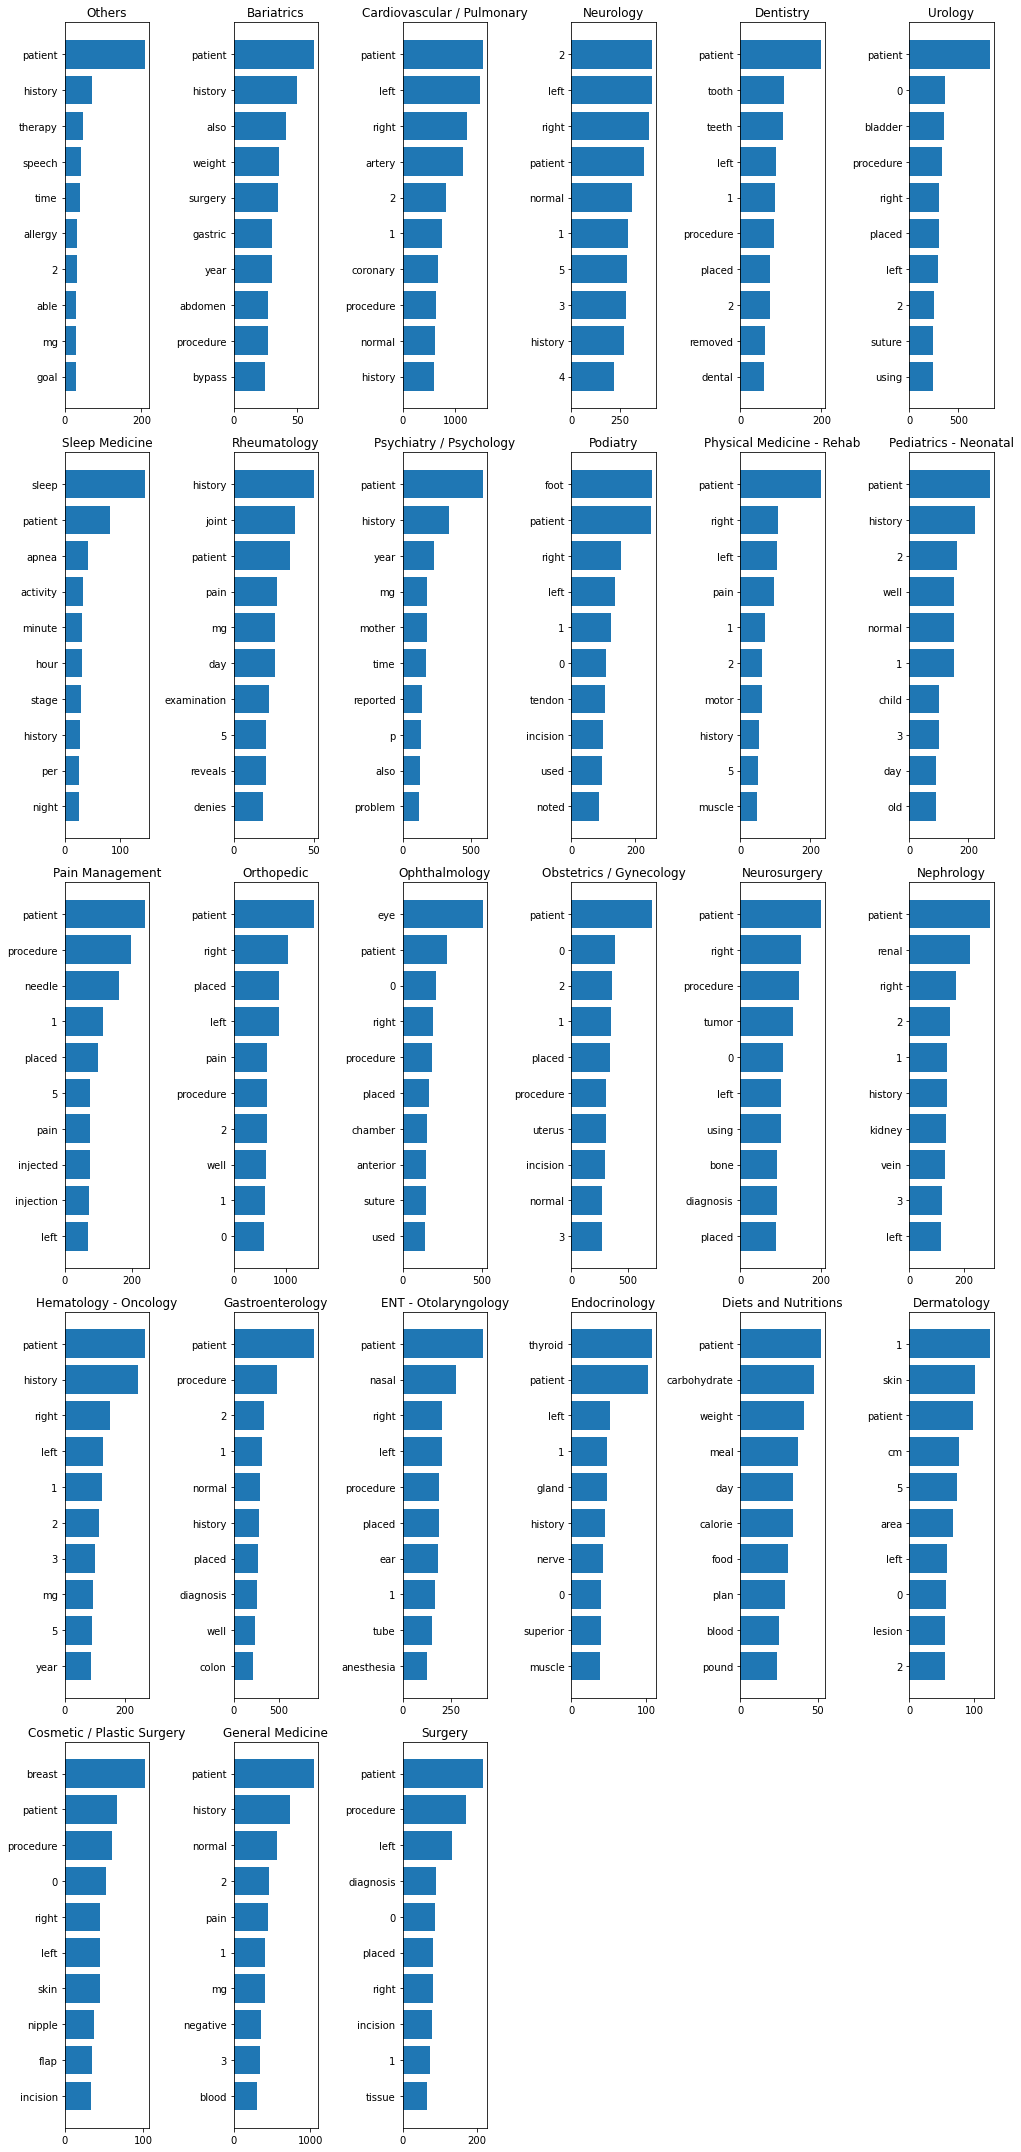

In [33]:
#Plot top 10 token for each specialty
#get unique specialty
specialties = new_df['medical_specialty'].unique()

# calculate number of rows and column
n_columns = 6
n_rows = len(specialties) // n_columns + (len(specialties) % n_columns > 0) #% is modulus operator which find the remainder. If remainder is > 0, make it 1 more row.

fig, axs = plt.subplots(n_rows, n_columns, figsize=(14, 6 * n_rows))

for idx, specialty in enumerate(specialties):
    row = idx // n_columns
    col = idx % n_columns
    
    # Filter data for this specialty
    df_specialty = new_df[new_df['medical_specialty'] == specialty]

    # Aggregate frequency counts for each word
    word_counts = df_specialty.groupby('word')['frequency'].sum()

    # Take top 10 words for readability
    word_counts = word_counts.sort_values(ascending=False).head(10)

    axs[row, col].barh(word_counts.index, word_counts.values)
    axs[row, col].set_title(f'{specialty}')
    axs[row, col].invert_yaxis()

# Remove unused subplots
if len(specialties) % n_columns != 0:
    # There might be more than one unused subplot now
    for i in range(len(specialties) % n_columns, n_columns):
        fig.delaxes(axs[row, i])

plt.tight_layout()
plt.show()

Visualizing using word cloud

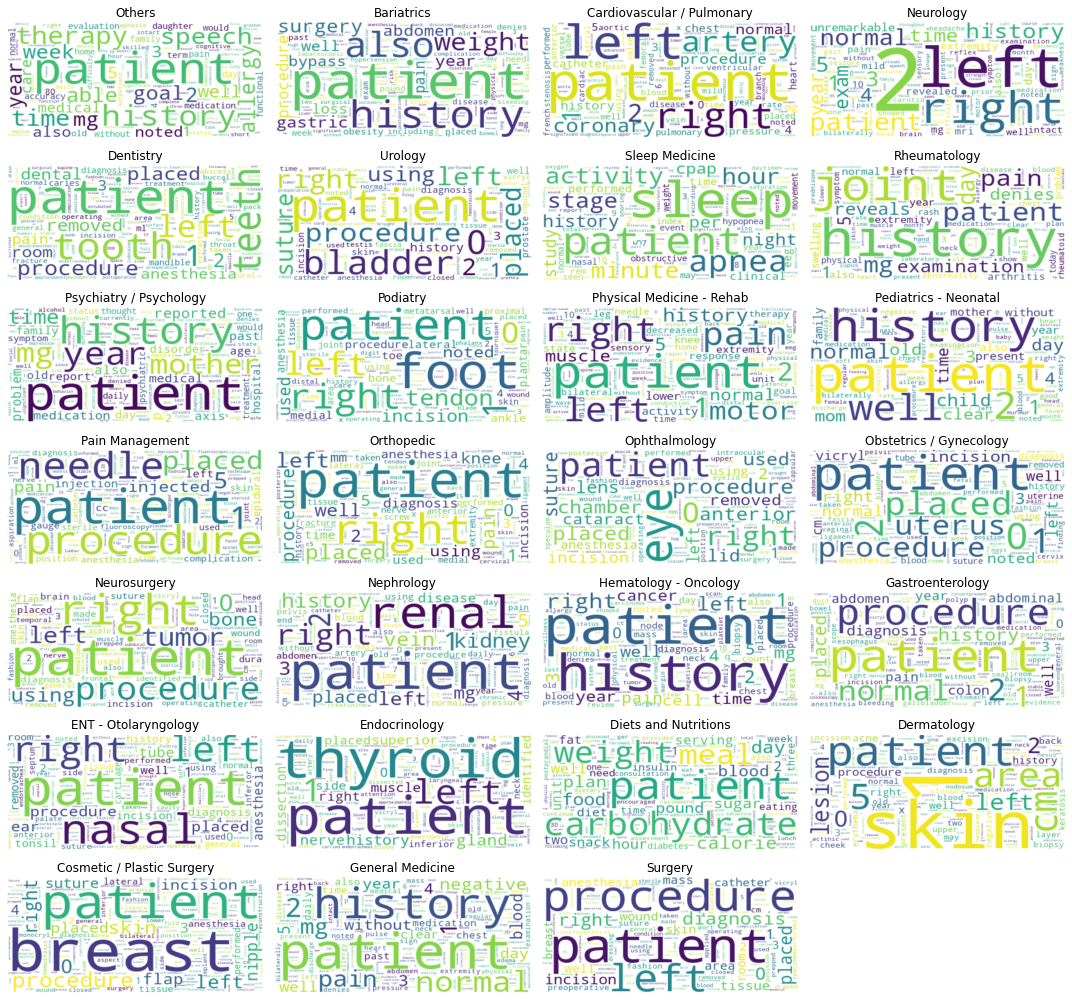

In [34]:
# calculate number of rows and column
n_columns = 4
n_rows = len(specialties) // n_columns + (len(specialties) % n_columns > 0) #% is modulus operator which find the remainder. If remainder is > 0, make it 1 more row.

fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 2 * n_rows))

for idx, specialty in enumerate(specialties):
    row = idx // n_columns
    col = idx % n_columns
    
    # Filter data for this specialty
    df_specialty = new_df[new_df['medical_specialty'] == specialty]

    # Aggregate frequency counts for each word
    freq_dict = df_specialty.groupby('word')['frequency'].sum().to_dict()
    
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq_dict) #use width, height argument to increase the resolution of the word cloud if you awnt
    
    # Display the generated image
    axs[row, col].imshow(wordcloud, interpolation='bilinear',aspect='auto') #aspect ='Auto fill the entire area with the image'
    axs[row, col].set_title(f'{specialty}')
    axs[row, col].axis('off')  # remove the axis of subplots

# remove unused subplots
if len(specialties) % n_columns != 0:
    for i in range(len(specialties) % n_columns, n_columns):
        fig.delaxes(axs[row, i])

plt.tight_layout()
plt.show()

Hmm, from the looks of it, 'patient', might be pretty uninformative as it appears a lot in many specialty and all specialty have patients. Maybe we can try removing the word patient and see the wordcloud again just for curiosity's sake.

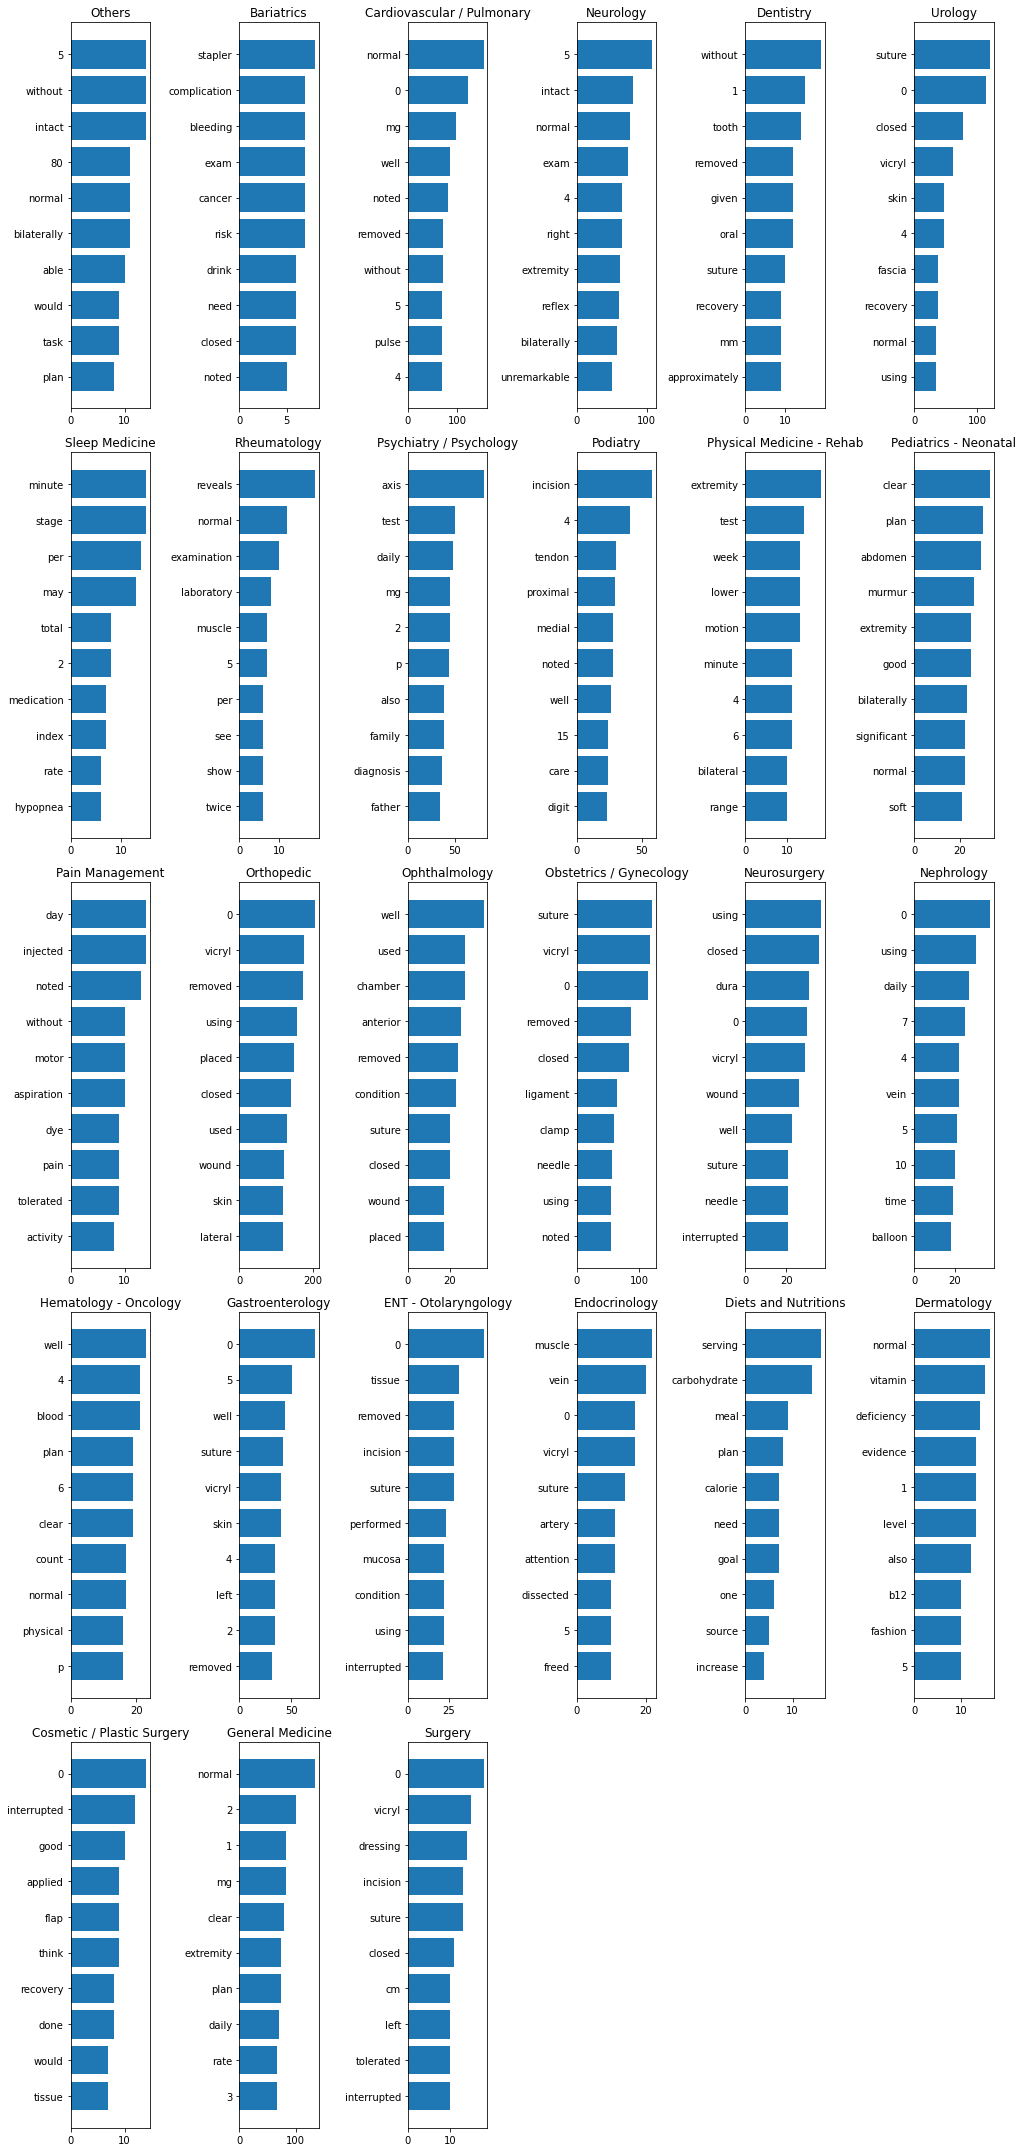

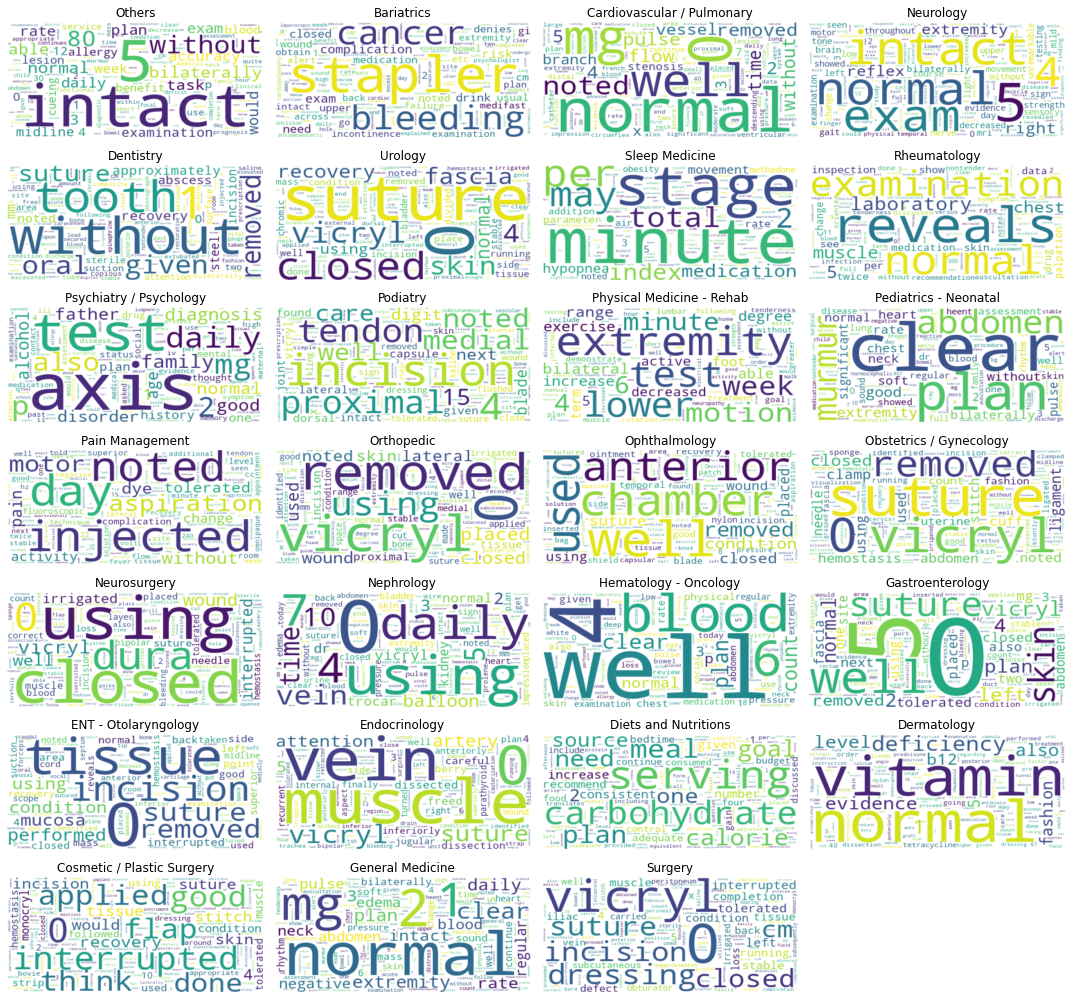

In [35]:
#get temporary DF which only contains the word patient
temp_df = new_df[new_df['word'] == 'patient']
new_df_without_patient = new_df.copy().drop(temp_df.index)

#chart
n_columns = 6
n_rows = len(specialties) // n_columns + (len(specialties) % n_columns > 0) #% is modulus operator which find the remainder. If remainder is > 0, make it 1 more row.

fig, axs = plt.subplots(n_rows, n_columns, figsize=(14, 6 * n_rows))

for idx, specialty in enumerate(specialties):
    row = idx // n_columns
    col = idx % n_columns
    
    # Filter data for this specialty
    df_specialty = new_df_without_patient[new_df_without_patient['medical_specialty'] == specialty]

    # Aggregate frequency counts for each word
    word_counts = df_specialty.groupby('word')['frequency'].sum()

    # Take top 10 words for readability
    word_counts = word_counts.sort_values(ascending=False).head(10)

    axs[row, col].barh(word_counts.index, word_counts.values)
    axs[row, col].set_title(f'{specialty}')
    axs[row, col].invert_yaxis()

# Remove unused subplots
if len(specialties) % n_columns != 0:
    # There might be more than one unused subplot now
    for i in range(len(specialties) % n_columns, n_columns):
        fig.delaxes(axs[row, i])

plt.tight_layout()
plt.show()

#word cloud
# calculate number of rows and column
n_columns = 4
n_rows = len(specialties) // n_columns + (len(specialties) % n_columns > 0) #% is modulus operator which find the remainder. If remainder is > 0, make it 1 more row.

fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 2 * n_rows))

for idx, specialty in enumerate(specialties):
    row = idx // n_columns
    col = idx % n_columns
    
    # Filter data for this specialty
    df_specialty = new_df_without_patient[new_df_without_patient['medical_specialty'] == specialty]

    # Aggregate frequency counts for each word
    freq_dict = df_specialty.groupby('word')['frequency'].sum().to_dict()
    
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq_dict) #use width, height argument to increase the resolution of the word cloud if you awnt
    
    # Display the generated image
    axs[row, col].imshow(wordcloud, interpolation='bilinear',aspect='auto') #aspect ='Auto fill the entire area with the image'
    axs[row, col].set_title(f'{specialty}')
    axs[row, col].axis('off')  # remove the axis of subplots

# remove unused subplots
if len(specialties) % n_columns != 0:
    for i in range(len(specialties) % n_columns, n_columns):
        fig.delaxes(axs[row, i])

plt.tight_layout()
plt.show()



Now we can see that each specialty do have some unique vocabs which are commonly used. For the purpose of classification with transformer the previous process are not needed but it did help to see that each classes do have unique characteristic/pattern which might be identifiable.

## Train/Test split

Splitting the data into train, validation and test set.

In [36]:
set_custom_seed.set_seed(50)

train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

df_ready = df_clean_1.copy()

#Get the index of the tran, val and test set
x_train, x_test, y_train, y_test = train_test_split(df_ready['transcription'], df_ready['label'], test_size=1 - train_ratio, stratify= df_ready['label'], random_state=50)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify = y_test, random_state=50) 


print(f'Number of x_train: {len(x_train)}\nRatio of x_train: { (len(x_train)/(len(x_train) + len(x_val) + len(x_test))):.2f}')
print(f'Number of x_val: {len(x_val)}\nRatio of x_val: { (len(x_val)/(len(x_train) + len(x_val) + len(x_test))):.2f}')
print(f'Number of x_test: {len(x_test)}\nRatio of x_test: { (len(x_test)/(len(x_train) + len(x_val) + len(x_test))):.2f}')


Number of x_train: 1836
Ratio of x_train: 0.80
Number of x_val: 230
Ratio of x_val: 0.10
Number of x_test: 230
Ratio of x_test: 0.10


In [37]:
#get the text data from df_ready and reset the index to prepare the data which is to be inputt to the pytorch data loader later.
x_train = df_ready.loc[x_train.index, 'transcription'].reset_index(drop = True)
x_val =  df_ready.loc[x_val.index, 'transcription'].reset_index(drop = True)
x_test =  df_ready.loc[x_test.index, 'transcription'].reset_index(drop = True)

y_train = df_ready.loc[y_train.index, 'label'].reset_index(drop = True)
y_val =  df_ready.loc[y_val.index, 'label'].reset_index(drop = True)
y_test =  df_ready.loc[y_test.index, 'label'].reset_index(drop = True)

In [38]:
#look at x_train
x_train.head()

0    DISCHARGE DIAGNOSES:,1.  End-stage renal disea...
1    CC:, Decreasing visual acuity.,HX: ,This 62 y/...
2    HISTORY: , The patient is a 4-month-old who pr...
3    PREOPERATIVE DIAGNOSIS:,  Bilateral inguinal h...
4    SUBJECTIVE:,  The patient's assistant brings i...
Name: transcription, dtype: object

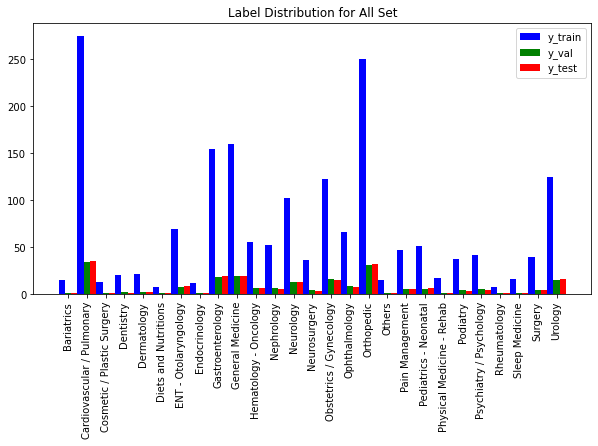

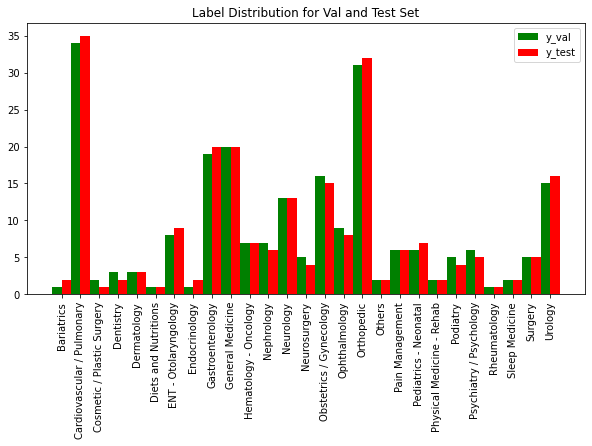

In [39]:
#print distribution of label

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the distribution of y_train, y_val, y_test
ax.hist([y_train, y_val, y_test], label=['y_train', 'y_val', 'y_test'], color=['blue', 'green', 'red'], bins=np.arange(28)-0.5, rwidth=1)

# Add a legend
ax.legend()

# Set the x ticks to be the class labels
labels = [class_number[i] for i in sorted(class_number.keys())]  # Get labels sorted by keys
ax.set_xticks(range(len(class_number)))
ax.set_xticklabels(labels, rotation=90)  # Rotate labels for better display
ax.set_title('Label Distribution for All Set')

# Show the plot
plt.show()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the distribution of y_train, y_val, y_test
ax.hist([y_val, y_test], label=['y_val', 'y_test'], color=['green', 'red'], bins=np.arange(28)-0.5, rwidth=1)

# Add a legend
ax.legend()

# Set the x ticks to be the class labels
labels = [class_number[i] for i in sorted(class_number.keys())]  # Get labels sorted by keys
ax.set_xticks(range(len(class_number)))
ax.set_xticklabels(labels, rotation=90)  # Rotate labels for better display
ax.set_title('Label Distribution for Val and Test Set')

# Show the plot
plt.show()

In [40]:
#Use list comprehension to find if there are missing class in each set or not.
print('Classes which is in train but not in val:')
missing_class_label = [value for value in np.sort(y_train.unique()) if value not in np.sort(y_val.unique())]
missing_class_name = [class_number[i] for i in missing_class_label]
print(f'The missing class label is {missing_class_label} which is {missing_class_name}')

print('\nClasses which is in val but not in test:')
missing_class_label = [value for value in np.sort(y_val.unique()) if value not in np.sort(y_test.unique())]
missing_class_name = [class_number[i] for i in missing_class_label]
print(f'The missing class label is {missing_class_label} which is {missing_class_name}')


print('\nClasses which is in train but not in test:')
missing_class_label = [value for value in np.sort(y_train.unique()) if value not in np.sort(y_test.unique())]
missing_class_name = [class_number[i] for i in missing_class_label]
print(f'The missing class label is {missing_class_label} which is {missing_class_name}')

Classes which is in train but not in val:
The missing class label is [] which is []

Classes which is in val but not in test:
The missing class label is [] which is []

Classes which is in train but not in test:
The missing class label is [] which is []


Calculate class weight for imbalance dataset to be used in loss function.

In [41]:
#Calculate classweight using SK learn and convert to tensor
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train), y = y_train)
class_weights = torch.tensor(class_weights,dtype=torch.float)
print(class_weights) 

#resource
#https://stackoverflow.com/questions/61414065/pytorch-weight-in-cross-entropy-loss <br>
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

tensor([4.5333, 0.2473, 5.2308, 3.2381, 3.0909, 8.5000, 0.9714, 5.6667, 0.4416,
        0.4250, 1.2143, 1.2830, 0.6667, 1.8378, 0.5528, 1.0303, 0.2720, 4.5333,
        1.4468, 1.3333, 4.0000, 1.7895, 1.6190, 8.5000, 4.2500, 1.7000, 0.5440])


# Model 1: BERT_LSTM_Base

The first model use BERT to get the embedding before passing it to LSTM. Using the embedding of all token in BERT and passing it to LSTM should allow for more information to be extracted as opposed to just using [CLS] token embedding alone and feed it to dense layer (see good figure explanation for the output of BERT in this [website](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f) if forget in the future). Nevertheless, this might not always be the case as seen in the experiment by [Adam for the CS224n: Natural Language Processing with Deep Learning Stanford / Winter 2019 course](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15718571.pdf) where BERT + LSTM actually resulted in a drop of performance compared to just using BERT on the Stanford Question Answering Dataset (SQuAD).

## Tokenization

The preprocessing step for BERT, including tokenization, special token addition, generation of atten_id and mask_id is done by the BertTokenizer.

In [52]:
#Resource
# https://pytorch.org/hub/huggingface_pytorch-transformers/<br>
# https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f <br>
# https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #the cased model is not case-sensitive

#Testing word tokenizer
example_text = "This is a test for BERT tokenizer with maximum 64 token."
bert_input = tokenizer(example_text,padding='max_length', max_length = 64, 
                       truncation=True, return_tensors="pt")

print(example_text)
print('\nTokenized text')
print(tokenizer.convert_ids_to_tokens(bert_input['input_ids'][0]))

print('\ninput_ids')
print(bert_input['input_ids'])
print('\ntoken_type_ids')
print(bert_input['token_type_ids'])
print('\nattention_mask')
print(bert_input['attention_mask'])
print('-----------------------------------------------------------------------------')

#Testing word tokenizer
print('This is a test for BERT tokenizer with random sample from x_train with maximum 512 token due to BERT limitation.')
example_text = str(x_train.sample(1).values)

bert_input = tokenizer(example_text,padding='max_length', max_length = 512, 
                       truncation=True, return_tensors="pt")

print(example_text)
print('\nTokenized text')
print(tokenizer.convert_ids_to_tokens(bert_input['input_ids'][0]))

print('\ninput_ids')
print(bert_input['input_ids'])
print('\ntoken_type_ids')
print(bert_input['token_type_ids'])
print('\nattention_mask')
print(bert_input['attention_mask'])
print('-----------------------------------------------------------------------------')

This is a test for BERT tokenizer with maximum 64 token.

Tokenized text
['[CLS]', 'this', 'is', 'a', 'test', 'for', 'bert', 'token', '##izer', 'with', 'maximum', '64', 'token', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

input_ids
tensor([[  101,  2023,  2003,  1037,  3231,  2005, 14324, 19204, 17629,  2007,
          4555,  4185, 19204,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,    

Arlraedy, we can see the limitation of the provided tokenizer for BERT which fail to correctly tokenize medical terms. For example, lymphoma was tokenized into subwords 'l', '##ym', '##ph', '##oma', demonstrating that this tokenizer was not built with medical term in mind and will likely hurts performance.

Also, since BERT only handle up to 512 token, we will see the amount of token for each row after tokenization with BERT tokenizer.

Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


Max token length is: 3620
Number of transcription with token length > 512 is: 1378, 60.02%
Index of transcription with maximum token length is: 1069
The transctiption with the highest token length is:
HISTORY OF PRESENT ILLNESS: ,The patient is a 79-year-old right-handed man who reports that approximately one and a half years ago, he fell down while walking in the living room from the bedroom.  At that time, he reports both legs gave away on him and he fell.  He reported that he had some lightheadedness just before he fell and was slightly confused, but was aware of what was happening around him.  He was able to get up shortly after falling and according to the patient and his son, subsequently returned back to normal.,He was then well until the 3rd of July 2008 when his legs again gave way on him.  This was not preceded by lightheadedness.  He was rushed to the hospital and was found to have pneumonia, and the fall was blamed on the pneumonia.  He started using a walker from that time

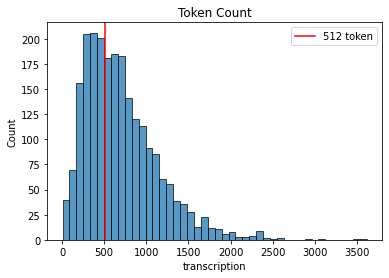

In [53]:
#Find the maximum length of token sequence. This can take some time.
token_length = df_ready['transcription'].map(tokenizer.encode).map(len)
print(f'Max token length is: {max(token_length)}')
print(f'Number of transcription with token length > 512 is: {sum(token_length > 512)}, {(sum(token_length > 512)/len(token_length))*100:.2f}%')
print(f'Index of transcription with maximum token length is: {token_length.idxmax()}')
print('The transctiption with the highest token length is:')
print(df_ready['transcription'][1069])

print('The tokenized transctiption is:')
print(tokenizer.convert_ids_to_tokens(
    tokenizer.encode
    (df_ready['transcription'][1069])))
print(f'The tokenized transctiption is from: {df_ready.medical_specialty.iloc[token_length.idxmax()]}')

sns.histplot(token_length)
plt.axvline(x = 512, color = 'r', label = '512 token')
plt.legend(loc = 'upper right')
plt.title('Token Count')
plt.show()


It looks like 60% of our corpus has  > 512 token. This will also hurt performance since the entire context won't be captured by BERT.

## Dataset Creation

In [67]:
set_custom_seed.set_seed(50)

#instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader = data_setup.create_dataloaders(x_train=x_train,
                                                                                    y_train = y_train,                
                                                                                    x_val= x_val,
                                                                                    y_val = y_val,
                                                                                    x_test = x_test,
                                                                                    y_test = y_test,
                                                                                    tokenizer = tokenizer,
                                                                                    max_length = 512, #BERT maximum length               
                                                                                    batch_size=8,
                                                                                    device = device,
                                                                                    ) 

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nut19\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [69]:
#Count the number of batch
print(f'Number of batches in train set:{len(train_dataloader)}')
print(f'Number of batches in val set:{len(val_dataloader)}')
print(f'Number of batches in test set:{len(test_dataloader)}')

#Getting a random sample from the training set
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random tokenized text from train data at index {random_number}')
single_text_embedding = train_data[random_number][0]
print(f'Dimension of a tokenized text (input Ids): {train_data[random_number][0].input_ids.size()}')
print(f'Data type: {train_data[random_number][0].input_ids.dtype}')
print(f'Label of data: {train_data[random_number][1]}')
print(f'Original tokenized text is:{tokenizer.convert_ids_to_tokens(train_data[random_number][0].input_ids.flatten())}')
print('The output from tokenizer is:')
print(single_text_embedding)

Number of batches in train set:229
Number of batches in val set:29
Number of batches in test set:29

Getting random tokenized text from train data at index 1504
Dimension of a tokenized text (input Ids): torch.Size([1, 512])
Data type: torch.int64
Label of data: 4
Original tokenized text is:['[CLS]', 'pre', '##oper', '##ative', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'post', '##pro', '##ced', '##ure', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'procedure', ':', ',', 'the', 'patient', 'gave', 'informed', 'consent', 'for', 'his', 'procedure', '.', 'after', 'informed', 'consent', 'was', 'obtained', ',', 'attention', 'was', 'turned', 'toward', 'the', 'area', 'of', 'interest', ',', 'which', 'was', 'prep', '##ped', 'and', 'draped', 'in', 'the', 'usual', 'sterile', 'fashion', '.', ',', 'local', 'an', '##est', '##hetic', 'medication', 'was', 'infiltrate', '##d', 'around', 

## Model building

In [70]:
bert = BertModel.from_pretrained('bert-base-uncased')
output_shape = len(class_number) #Use number of class as output shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
class BertClassifier(nn.Module):

    def __init__(self, output_shape, hidden_dim=50, num_layers=1, dropout=0.5, bidirectional=False):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #get the size of embedding from BERT
        embedding_dim = self.bert.config.hidden_size
        
        #define LSTM
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim, #hidden dim is the dimension of the hidden state, so the higher it is, the more feature it can capture
                            num_layers=num_layers, # Number of recurrent layers, if 2, for example, maens stacking 2 LSTM together
                            bidirectional=bidirectional,
                            batch_first=True, #make the first dimension of the input and output the batch
                            dropout=0 if num_layers < 2 else dropout)    
                            
        # If the LSTM is bidirectional, it will have 2*hidden_dim units. If not, it will have hidden_dim units
        self.dropout = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        #define lienar layer
        self.linear = nn.Linear(lstm_output_dim, output_shape) 



    def forward(self, input_id, mask):
        
        # Feed input to BERT
        outputs = self.bert(input_ids= input_id, attention_mask=mask, return_dict=True)  # returns 2 output, last_hidden_state(embedding of all token in sequence) or pooler_output(embedding of the classification token [cls] only)
        #Each token embedding's dimension is 768. So, if we use the last_idden_state to get the sequence embedding of all token, we gen tensor size of (512,768) while if you just use the pooler_output ([CLS] only), it will be size of (1,768)
        #We will use the last_hidden_state to feed the all the embedding in sequence into LSTM as pooler_output does not capture information from all the input sequence because it is only the [CLS] classifier.
        
        # Feed BERT's output to the LSTM layer (so we feed 512 embedding, each with dimension of 768)
        lstm_output, _ = self.lstm(outputs.last_hidden_state)  #LSTM will return output, (h_n, c_n). Output is output. (h_n, c_n) is the final hidden and cell states. 
        #The lstm output is (batch size, sequence length, hidden size [*2 if bidirectional = True]). It contains all output in every time step, that is to say the hidden state for every time step.
        #In this case, the shape is [1, 512, 50]. So we have 512 hidden state and each hidden stae has dimension of 50.
        #However, in classification, we only care about the last time step.
        #hence, we will only use the last time step of the output (the last value in sequence)
        final_output = lstm_output[:,-1,:]  #(Batch size, last time step, size of the output which should be the size of the hidden dimension * direction). In this case, it is [1,50]
        #This should actually be the same as h_n as it is the output is the "last hidden state" anyhow.      
        # Pass the final output through dropout and the linear layer with 27 classes. See the model summary if you're confused on the input and output of each layer.
        return self.linear(self.dropout(final_output))
    
#Instantiate model    
model_0 = BertClassifier(output_shape = output_shape).to(device) #don't forget to send to device 

#See model summary with torchinfo
# do a test pass through of an example inout data
#Bert expect two input, (input_ids, attention_mask) from the tokenizer like this: model_0(input_ids, attention_mask)
example_input_ids = torch.randint(0, 100, (1, 512)).to(device)
example_attention_mask = torch.ones((1, 512)).to(device)
summary(model_0, input_data=[example_input_ids, example_attention_mask], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the 

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
BertClassifier                                          --                        [1, 512]                  [1, 27]                   --                        --                        True
├─BertModel: 1-1                                        --                        --                        [1, 768]                  --                        --                        True
│    └─BertEmbeddings: 2-1                              --                        --                        [1, 512, 768]             --                        --                        True
│    │    └─Embedding: 3-1                              --                        [1, 512]                  [1, 512, 768]             23,440,896                23,440,896                True
│    │    └─Embedding: 3-2              

We are keeping BERT's layer frozen and train only the LSTM and linear layer.

In [72]:
# Freeze all parameters
for param in model_0.parameters():
    param.requires_grad = False

#Unfrozen only the LSTM and linear layer
for param in model_0.linear.parameters():
    param.requires_grad = True
for param in model_0.lstm.parameters():
    param.requires_grad = True    
    
#Print model summary after freezing layers
summary(model_0, input_data=[example_input_ids, example_attention_mask], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
BertClassifier                                          --                        [1, 512]                  [1, 27]                   --                        --                        Partial
├─BertModel: 1-1                                        --                        --                        [1, 768]                  --                        --                        False
│    └─BertEmbeddings: 2-1                              --                        --                        [1, 512, 768]             --                        --                        False
│    │    └─Embedding: 3-1                              --                        [1, 512]                  [1, 512, 768]             (23,440,896)              23,440,896                False
│    │    └─Embedding: 3-2        

In [59]:
#Testing the model on a single training data
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random embedding from train data at index {random_number}')
single_text_embedding = train_data[random_number][0]
print(f'Dimension of an embedding (input Ids): {train_data[random_number][0].input_ids.size()}')
print(f'Data type: {train_data[random_number][0].input_ids.dtype}')
print(f'Original tokenized text is:{tokenizer.convert_ids_to_tokens(train_data[random_number][0].input_ids.flatten())}')

# Perform a forward pass on a single image
model_0.eval() #set to eval
train_data[random_number][0].to(device)
with torch.inference_mode(): #set to inference mode
    sample_pred_logit = model_0(train_data[random_number][0].input_ids, train_data[random_number][0].attention_mask)   #predict the image on GPU

sample_pred_prob = torch.softmax(sample_pred_logit, dim = 1) #use softmax for multiclass classification to convert logit into prob
sample_pred_class = torch.argmax(sample_pred_prob, dim=1) #use argmax to find the index with the largest probability and use that as the class label
    
# Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{sample_pred_logit}\n") #Print the logit
print(f"Output prediction probabilities:\n{sample_pred_prob}\n") #Print the probability for each class
print(f"Output prediction label:\n{sample_pred_class}\n") #Select the maximum probability as predicted label.
print(f"Actual label:\n{train_data[random_number][1]}") #Get the actual label.

  


Getting random embedding from train data at index 1504
Dimension of an embedding (input Ids): torch.Size([1, 512])
Data type: torch.int64
Original tokenized text is:['[CLS]', 'pre', '##oper', '##ative', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'post', '##pro', '##ced', '##ure', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'procedure', ':', ',', 'the', 'patient', 'gave', 'informed', 'consent', 'for', 'his', 'procedure', '.', 'after', 'informed', 'consent', 'was', 'obtained', ',', 'attention', 'was', 'turned', 'toward', 'the', 'area', 'of', 'interest', ',', 'which', 'was', 'prep', '##ped', 'and', 'draped', 'in', 'the', 'usual', 'sterile', 'fashion', '.', ',', 'local', 'an', '##est', '##hetic', 'medication', 'was', 'infiltrate', '##d', 'around', 'and', 'into', 'the', 'area', 'of', 'interest', '.', 'there', 'was', 'an', 'obvious', 'skin', 'les', '##ion', 'there', 'and', 

## Training loop - Do not run if do not want to train again

In [49]:
# #define Loss function
# loss_fn = nn.CrossEntropyLoss(weight = class_weights.to(device))
# #define optimizer
# optimizer = torch.optim.Adam(model_0.parameters(), lr= 1e-4)
# # Set the seed 
# set_custom_seed.set_seed(50)

# #initialize parameter for custom train loop module
# model = model_0
# train_dataloader = train_dataloader
# val_dataloader = val_dataloader
# optimizer = optimizer
# loss_fn = loss_fn
# device = device
# target_dir = '..\model'
# figure_dir = '..\image'
# model_name = 'BERT_LSTM_base'
# epochs = 150

Training on cuda.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.28580 | Val loss: 3.25834
Train accuracy: 0.05895 | Train balanced accuracy: 0.01388 | Train F1 score: 0.03522 | Train ROC AUC score: 0.53884
Validation accuracy: 0.08696 | Validation balanced accuracy: 0.04347 | Validation F1 score: 0.03297 | Val ROC AUC score: 0.59603

Epoch: 1
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.26338 | Val loss: 3.23228
Train accuracy: 0.06659 | Train balanced accuracy: 0.00960 | Train F1 score: 0.03751 | Train ROC AUC score: 0.56543
Validation accuracy: 0.12609 | Validation balanced accuracy: 0.08349 | Validation F1 score: 0.05590 | Val ROC AUC score: 0.63212

Epoch: 2
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.23640 | Val loss: 3.20178
Train accuracy: 0.08242 | Train balanced accuracy: 0.02663 | Train F1 score: 0.05009 | Train ROC AUC score: 0.59249
Validation accuracy: 0.15652 | Validation balanced accuracy: 0.11683 | Validation F1 score: 0.08490 | Val ROC AUC score: 0.66507

Epoch: 3
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.19728 | Val loss: 3.16121
Train accuracy: 0.10098 | Train balanced accuracy: 0.04379 | Train F1 score: 0.05925 | Train ROC AUC score: 0.62741
Validation accuracy: 0.16087 | Validation balanced accuracy: 0.10686 | Validation F1 score: 0.08307 | Val ROC AUC score: 0.68968

Epoch: 4
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.14109 | Val loss: 3.10592
Train accuracy: 0.11354 | Train balanced accuracy: 0.07451 | Train F1 score: 0.08466 | Train ROC AUC score: 0.66973
Validation accuracy: 0.17391 | Validation balanced accuracy: 0.15250 | Validation F1 score: 0.12228 | Val ROC AUC score: 0.72746

Epoch: 5
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.09167 | Val loss: 3.04066
Train accuracy: 0.11736 | Train balanced accuracy: 0.08152 | Train F1 score: 0.08181 | Train ROC AUC score: 0.69465
Validation accuracy: 0.20435 | Validation balanced accuracy: 0.18427 | Validation F1 score: 0.14284 | Val ROC AUC score: 0.74070

Epoch: 6
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.03490 | Val loss: 2.98274
Train accuracy: 0.13592 | Train balanced accuracy: 0.11095 | Train F1 score: 0.10103 | Train ROC AUC score: 0.70096
Validation accuracy: 0.20435 | Validation balanced accuracy: 0.19895 | Validation F1 score: 0.14939 | Val ROC AUC score: 0.75820

Epoch: 7
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.96784 | Val loss: 2.92429
Train accuracy: 0.16812 | Train balanced accuracy: 0.12965 | Train F1 score: 0.11854 | Train ROC AUC score: 0.72837
Validation accuracy: 0.20000 | Validation balanced accuracy: 0.18699 | Validation F1 score: 0.14124 | Val ROC AUC score: 0.77171

Epoch: 8
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.90551 | Val loss: 2.86262
Train accuracy: 0.16048 | Train balanced accuracy: 0.14207 | Train F1 score: 0.12276 | Train ROC AUC score: 0.74983
Validation accuracy: 0.24348 | Validation balanced accuracy: 0.22199 | Validation F1 score: 0.17640 | Val ROC AUC score: 0.78889

Epoch: 9
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.85532 | Val loss: 2.82743
Train accuracy: 0.16703 | Train balanced accuracy: 0.13691 | Train F1 score: 0.12032 | Train ROC AUC score: 0.77301
Validation accuracy: 0.23913 | Validation balanced accuracy: 0.20544 | Validation F1 score: 0.16110 | Val ROC AUC score: 0.79498

Epoch: 10
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.82099 | Val loss: 2.80495
Train accuracy: 0.16430 | Train balanced accuracy: 0.12063 | Train F1 score: 0.11416 | Train ROC AUC score: 0.77371
Validation accuracy: 0.25217 | Validation balanced accuracy: 0.23834 | Validation F1 score: 0.19337 | Val ROC AUC score: 0.80249

Epoch: 11
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.72710 | Val loss: 2.77678
Train accuracy: 0.18614 | Train balanced accuracy: 0.17966 | Train F1 score: 0.15580 | Train ROC AUC score: 0.80677
Validation accuracy: 0.28261 | Validation balanced accuracy: 0.26534 | Validation F1 score: 0.22616 | Val ROC AUC score: 0.79782

Epoch: 12
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.69415 | Val loss: 2.74412
Train accuracy: 0.21725 | Train balanced accuracy: 0.20660 | Train F1 score: 0.18351 | Train ROC AUC score: 0.80657
Validation accuracy: 0.28696 | Validation balanced accuracy: 0.26986 | Validation F1 score: 0.22910 | Val ROC AUC score: 0.80458

Epoch: 13
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.66071 | Val loss: 2.72153
Train accuracy: 0.22434 | Train balanced accuracy: 0.21280 | Train F1 score: 0.19188 | Train ROC AUC score: 0.81466
Validation accuracy: 0.33913 | Validation balanced accuracy: 0.28474 | Validation F1 score: 0.24244 | Val ROC AUC score: 0.80321

Epoch: 14
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.65818 | Val loss: 2.69850
Train accuracy: 0.20797 | Train balanced accuracy: 0.19456 | Train F1 score: 0.17804 | Train ROC AUC score: 0.81989
Validation accuracy: 0.33478 | Validation balanced accuracy: 0.28222 | Validation F1 score: 0.25475 | Val ROC AUC score: 0.80903

Epoch: 15
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.59485 | Val loss: 2.64700
Train accuracy: 0.24727 | Train balanced accuracy: 0.24621 | Train F1 score: 0.21240 | Train ROC AUC score: 0.82548
Validation accuracy: 0.34348 | Validation balanced accuracy: 0.29932 | Validation F1 score: 0.25877 | Val ROC AUC score: 0.81531

Epoch: 16
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.54207 | Val loss: 2.64404
Train accuracy: 0.25382 | Train balanced accuracy: 0.25648 | Train F1 score: 0.22075 | Train ROC AUC score: 0.84224
Validation accuracy: 0.33913 | Validation balanced accuracy: 0.29437 | Validation F1 score: 0.26956 | Val ROC AUC score: 0.81206

Epoch: 17
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.51725 | Val loss: 2.61038
Train accuracy: 0.26201 | Train balanced accuracy: 0.23347 | Train F1 score: 0.20439 | Train ROC AUC score: 0.84690
Validation accuracy: 0.33043 | Validation balanced accuracy: 0.27711 | Validation F1 score: 0.22614 | Val ROC AUC score: 0.81983

Epoch: 18
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.46730 | Val loss: 2.58324
Train accuracy: 0.28603 | Train balanced accuracy: 0.26498 | Train F1 score: 0.23860 | Train ROC AUC score: 0.84889
Validation accuracy: 0.33913 | Validation balanced accuracy: 0.28669 | Validation F1 score: 0.23481 | Val ROC AUC score: 0.82094

Epoch: 19
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.41978 | Val loss: 2.57904
Train accuracy: 0.27948 | Train balanced accuracy: 0.28109 | Train F1 score: 0.25825 | Train ROC AUC score: 0.85978
Validation accuracy: 0.36522 | Validation balanced accuracy: 0.32427 | Validation F1 score: 0.29934 | Val ROC AUC score: 0.81613

Epoch: 20
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.40210 | Val loss: 2.55130
Train accuracy: 0.30950 | Train balanced accuracy: 0.29041 | Train F1 score: 0.26765 | Train ROC AUC score: 0.86011
Validation accuracy: 0.37826 | Validation balanced accuracy: 0.31871 | Validation F1 score: 0.28009 | Val ROC AUC score: 0.82331

Epoch: 21
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.39555 | Val loss: 2.53671
Train accuracy: 0.29858 | Train balanced accuracy: 0.28369 | Train F1 score: 0.24536 | Train ROC AUC score: 0.85890
Validation accuracy: 0.34348 | Validation balanced accuracy: 0.27749 | Validation F1 score: 0.22309 | Val ROC AUC score: 0.83439

Epoch: 22
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.35322 | Val loss: 2.52546
Train accuracy: 0.30459 | Train balanced accuracy: 0.31023 | Train F1 score: 0.26511 | Train ROC AUC score: 0.87108
Validation accuracy: 0.37391 | Validation balanced accuracy: 0.31705 | Validation F1 score: 0.28691 | Val ROC AUC score: 0.82854

Epoch: 23
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.37603 | Val loss: 2.50762
Train accuracy: 0.30731 | Train balanced accuracy: 0.27485 | Train F1 score: 0.25169 | Train ROC AUC score: 0.86310
Validation accuracy: 0.36957 | Validation balanced accuracy: 0.31913 | Validation F1 score: 0.27578 | Val ROC AUC score: 0.83780

Epoch: 24
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.33881 | Val loss: 2.49602
Train accuracy: 0.32041 | Train balanced accuracy: 0.30719 | Train F1 score: 0.27892 | Train ROC AUC score: 0.86766
Validation accuracy: 0.35652 | Validation balanced accuracy: 0.26085 | Validation F1 score: 0.22759 | Val ROC AUC score: 0.84038

Epoch: 25
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.26256 | Val loss: 2.45210
Train accuracy: 0.32533 | Train balanced accuracy: 0.30818 | Train F1 score: 0.28725 | Train ROC AUC score: 0.88059
Validation accuracy: 0.38261 | Validation balanced accuracy: 0.32442 | Validation F1 score: 0.27304 | Val ROC AUC score: 0.83104

Epoch: 26
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.22693 | Val loss: 2.45418
Train accuracy: 0.34989 | Train balanced accuracy: 0.35855 | Train F1 score: 0.31429 | Train ROC AUC score: 0.88790
Validation accuracy: 0.36522 | Validation balanced accuracy: 0.31017 | Validation F1 score: 0.24901 | Val ROC AUC score: 0.83653

Epoch: 27
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.27053 | Val loss: 2.45711
Train accuracy: 0.32806 | Train balanced accuracy: 0.29254 | Train F1 score: 0.26842 | Train ROC AUC score: 0.87686
Validation accuracy: 0.34348 | Validation balanced accuracy: 0.30269 | Validation F1 score: 0.26502 | Val ROC AUC score: 0.83071

Epoch: 28
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.22100 | Val loss: 2.53172
Train accuracy: 0.34116 | Train balanced accuracy: 0.34945 | Train F1 score: 0.32208 | Train ROC AUC score: 0.88601
Validation accuracy: 0.30000 | Validation balanced accuracy: 0.26120 | Validation F1 score: 0.23792 | Val ROC AUC score: 0.81390

Epoch: 29
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.21160 | Val loss: 2.39183
Train accuracy: 0.32260 | Train balanced accuracy: 0.35368 | Train F1 score: 0.31317 | Train ROC AUC score: 0.89003
Validation accuracy: 0.40000 | Validation balanced accuracy: 0.33679 | Validation F1 score: 0.28386 | Val ROC AUC score: 0.84531

Epoch: 30
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.13794 | Val loss: 2.40156
Train accuracy: 0.35044 | Train balanced accuracy: 0.35080 | Train F1 score: 0.31725 | Train ROC AUC score: 0.89856
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.34705 | Validation F1 score: 0.30082 | Val ROC AUC score: 0.84446

Epoch: 31
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.11247 | Val loss: 2.36692
Train accuracy: 0.37391 | Train balanced accuracy: 0.37491 | Train F1 score: 0.33488 | Train ROC AUC score: 0.90005
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.34404 | Validation F1 score: 0.30398 | Val ROC AUC score: 0.84920

Epoch: 32
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.07469 | Val loss: 2.36719
Train accuracy: 0.38537 | Train balanced accuracy: 0.38999 | Train F1 score: 0.34781 | Train ROC AUC score: 0.90598
Validation accuracy: 0.40435 | Validation balanced accuracy: 0.35528 | Validation F1 score: 0.30202 | Val ROC AUC score: 0.84739

Epoch: 33
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.06946 | Val loss: 2.34044
Train accuracy: 0.39902 | Train balanced accuracy: 0.40886 | Train F1 score: 0.37276 | Train ROC AUC score: 0.90081
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.34823 | Validation F1 score: 0.30085 | Val ROC AUC score: 0.85004

Epoch: 34
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.05212 | Val loss: 2.33070
Train accuracy: 0.39465 | Train balanced accuracy: 0.40386 | Train F1 score: 0.36173 | Train ROC AUC score: 0.90650
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.35940 | Validation F1 score: 0.30981 | Val ROC AUC score: 0.85463

Epoch: 35
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.01295 | Val loss: 2.32877
Train accuracy: 0.39793 | Train balanced accuracy: 0.41495 | Train F1 score: 0.37566 | Train ROC AUC score: 0.90959
Validation accuracy: 0.40870 | Validation balanced accuracy: 0.34268 | Validation F1 score: 0.31365 | Val ROC AUC score: 0.85407

Epoch: 36
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.03972 | Val loss: 2.31429
Train accuracy: 0.38974 | Train balanced accuracy: 0.39328 | Train F1 score: 0.36130 | Train ROC AUC score: 0.90314
Validation accuracy: 0.41304 | Validation balanced accuracy: 0.34364 | Validation F1 score: 0.29359 | Val ROC AUC score: 0.85617

Epoch: 37
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.99988 | Val loss: 2.30619
Train accuracy: 0.40229 | Train balanced accuracy: 0.39696 | Train F1 score: 0.36656 | Train ROC AUC score: 0.90991
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.36534 | Validation F1 score: 0.32667 | Val ROC AUC score: 0.85363

Epoch: 38
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.97410 | Val loss: 2.28276
Train accuracy: 0.40939 | Train balanced accuracy: 0.42023 | Train F1 score: 0.37504 | Train ROC AUC score: 0.91225
Validation accuracy: 0.42609 | Validation balanced accuracy: 0.37181 | Validation F1 score: 0.31631 | Val ROC AUC score: 0.85705

Epoch: 39
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.95054 | Val loss: 2.26298
Train accuracy: 0.40721 | Train balanced accuracy: 0.44573 | Train F1 score: 0.38889 | Train ROC AUC score: 0.91704
Validation accuracy: 0.42174 | Validation balanced accuracy: 0.34479 | Validation F1 score: 0.30101 | Val ROC AUC score: 0.85169

Epoch: 40
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.94357 | Val loss: 2.26693
Train accuracy: 0.41539 | Train balanced accuracy: 0.44034 | Train F1 score: 0.38166 | Train ROC AUC score: 0.91527
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.36380 | Validation F1 score: 0.31576 | Val ROC AUC score: 0.84975

Epoch: 41
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.88787 | Val loss: 2.27413
Train accuracy: 0.44432 | Train balanced accuracy: 0.47228 | Train F1 score: 0.41383 | Train ROC AUC score: 0.92289
Validation accuracy: 0.41304 | Validation balanced accuracy: 0.37534 | Validation F1 score: 0.30217 | Val ROC AUC score: 0.85667

Epoch: 42
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.88271 | Val loss: 2.20594
Train accuracy: 0.41430 | Train balanced accuracy: 0.46236 | Train F1 score: 0.39735 | Train ROC AUC score: 0.92404
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.38776 | Validation F1 score: 0.32387 | Val ROC AUC score: 0.86011

Epoch: 43
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.86820 | Val loss: 2.20904
Train accuracy: 0.43614 | Train balanced accuracy: 0.46112 | Train F1 score: 0.41755 | Train ROC AUC score: 0.92171
Validation accuracy: 0.42174 | Validation balanced accuracy: 0.39473 | Validation F1 score: 0.33913 | Val ROC AUC score: 0.86229

Epoch: 44
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.85461 | Val loss: 2.20658
Train accuracy: 0.42194 | Train balanced accuracy: 0.44188 | Train F1 score: 0.39279 | Train ROC AUC score: 0.92255
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.36737 | Validation F1 score: 0.31742 | Val ROC AUC score: 0.86718

Epoch: 45
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.82422 | Val loss: 2.16714
Train accuracy: 0.46015 | Train balanced accuracy: 0.49441 | Train F1 score: 0.44819 | Train ROC AUC score: 0.92689
Validation accuracy: 0.44783 | Validation balanced accuracy: 0.39790 | Validation F1 score: 0.34200 | Val ROC AUC score: 0.86999

Epoch: 46
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.78541 | Val loss: 2.15532
Train accuracy: 0.44760 | Train balanced accuracy: 0.49787 | Train F1 score: 0.43484 | Train ROC AUC score: 0.92993
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.37174 | Validation F1 score: 0.30978 | Val ROC AUC score: 0.87875

Epoch: 47
-------
Train loss: 1.80213 | Val loss: 2.22400
Train accuracy: 0.43559 | Train balanced accuracy: 0.47978 | Train F1 score: 0.42013 | Train ROC AUC score: 0.92581
Validation accuracy: 0.40000 | Validation balanced accuracy: 0.36185 | Validation F1 score: 0.30298 | Val ROC AUC score: 0.86576

Epoch: 48
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.79150 | Val loss: 2.13371
Train accuracy: 0.44760 | Train balanced accuracy: 0.49559 | Train F1 score: 0.43942 | Train ROC AUC score: 0.92716
Validation accuracy: 0.43913 | Validation balanced accuracy: 0.39178 | Validation F1 score: 0.36247 | Val ROC AUC score: 0.88189

Epoch: 49
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.75249 | Val loss: 2.15411
Train accuracy: 0.45961 | Train balanced accuracy: 0.48726 | Train F1 score: 0.44139 | Train ROC AUC score: 0.93108
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.40817 | Validation F1 score: 0.34517 | Val ROC AUC score: 0.87446

Epoch: 50
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.75232 | Val loss: 2.13898
Train accuracy: 0.46779 | Train balanced accuracy: 0.48068 | Train F1 score: 0.43878 | Train ROC AUC score: 0.93088
Validation accuracy: 0.42609 | Validation balanced accuracy: 0.39198 | Validation F1 score: 0.33549 | Val ROC AUC score: 0.87411

Epoch: 51
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.76920 | Val loss: 2.10279
Train accuracy: 0.46670 | Train balanced accuracy: 0.50632 | Train F1 score: 0.45293 | Train ROC AUC score: 0.92876
Validation accuracy: 0.43478 | Validation balanced accuracy: 0.39160 | Validation F1 score: 0.34123 | Val ROC AUC score: 0.87689

Epoch: 52
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.69255 | Val loss: 2.14762
Train accuracy: 0.47107 | Train balanced accuracy: 0.51788 | Train F1 score: 0.46321 | Train ROC AUC score: 0.93555
Validation accuracy: 0.42609 | Validation balanced accuracy: 0.39930 | Validation F1 score: 0.33536 | Val ROC AUC score: 0.87807

Epoch: 53
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.70162 | Val loss: 2.09977
Train accuracy: 0.46288 | Train balanced accuracy: 0.49764 | Train F1 score: 0.45591 | Train ROC AUC score: 0.93678
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.40748 | Validation F1 score: 0.33978 | Val ROC AUC score: 0.88034

Epoch: 54
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.65393 | Val loss: 2.13758
Train accuracy: 0.47871 | Train balanced accuracy: 0.51465 | Train F1 score: 0.45465 | Train ROC AUC score: 0.93990
Validation accuracy: 0.45217 | Validation balanced accuracy: 0.39175 | Validation F1 score: 0.34329 | Val ROC AUC score: 0.87379

Epoch: 55
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.64379 | Val loss: 2.11778
Train accuracy: 0.49290 | Train balanced accuracy: 0.54967 | Train F1 score: 0.48091 | Train ROC AUC score: 0.94107
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.39095 | Validation F1 score: 0.33782 | Val ROC AUC score: 0.87764

Epoch: 56
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.61543 | Val loss: 2.12491
Train accuracy: 0.49236 | Train balanced accuracy: 0.53632 | Train F1 score: 0.46790 | Train ROC AUC score: 0.94420
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.39404 | Validation F1 score: 0.34788 | Val ROC AUC score: 0.87707

Epoch: 57
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.59619 | Val loss: 2.07679
Train accuracy: 0.48635 | Train balanced accuracy: 0.54095 | Train F1 score: 0.49447 | Train ROC AUC score: 0.94418
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.41561 | Validation F1 score: 0.36329 | Val ROC AUC score: 0.88338

Epoch: 58
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.61627 | Val loss: 2.17849
Train accuracy: 0.49345 | Train balanced accuracy: 0.53550 | Train F1 score: 0.47791 | Train ROC AUC score: 0.94249
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.39651 | Validation F1 score: 0.32666 | Val ROC AUC score: 0.86946

Epoch: 59
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.59458 | Val loss: 2.09677
Train accuracy: 0.48472 | Train balanced accuracy: 0.53543 | Train F1 score: 0.47484 | Train ROC AUC score: 0.94404
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.40687 | Validation F1 score: 0.35959 | Val ROC AUC score: 0.88168

Epoch: 60
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.58088 | Val loss: 2.07453
Train accuracy: 0.48417 | Train balanced accuracy: 0.52527 | Train F1 score: 0.46233 | Train ROC AUC score: 0.94697
Validation accuracy: 0.41304 | Validation balanced accuracy: 0.44009 | Validation F1 score: 0.34314 | Val ROC AUC score: 0.88632

Epoch: 61
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.57342 | Val loss: 2.06138
Train accuracy: 0.48690 | Train balanced accuracy: 0.53830 | Train F1 score: 0.47545 | Train ROC AUC score: 0.94430
Validation accuracy: 0.45217 | Validation balanced accuracy: 0.43703 | Validation F1 score: 0.36821 | Val ROC AUC score: 0.88455

Epoch: 62
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.52112 | Val loss: 2.05941
Train accuracy: 0.50873 | Train balanced accuracy: 0.57156 | Train F1 score: 0.51059 | Train ROC AUC score: 0.94980
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.41282 | Validation F1 score: 0.36278 | Val ROC AUC score: 0.88235

Epoch: 63
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.51063 | Val loss: 2.14262
Train accuracy: 0.51965 | Train balanced accuracy: 0.58655 | Train F1 score: 0.52704 | Train ROC AUC score: 0.94709
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.38474 | Validation F1 score: 0.35725 | Val ROC AUC score: 0.87151

Epoch: 64
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.46955 | Val loss: 2.11715
Train accuracy: 0.51638 | Train balanced accuracy: 0.58470 | Train F1 score: 0.50791 | Train ROC AUC score: 0.95202
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.39840 | Validation F1 score: 0.35254 | Val ROC AUC score: 0.87415

Epoch: 65
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.48146 | Val loss: 2.06293
Train accuracy: 0.51365 | Train balanced accuracy: 0.57385 | Train F1 score: 0.51082 | Train ROC AUC score: 0.95096
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.42840 | Validation F1 score: 0.35759 | Val ROC AUC score: 0.88585

Epoch: 66
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.45941 | Val loss: 2.07286
Train accuracy: 0.51310 | Train balanced accuracy: 0.57986 | Train F1 score: 0.50957 | Train ROC AUC score: 0.95290
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.44745 | Validation F1 score: 0.39477 | Val ROC AUC score: 0.88221

Epoch: 67
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.45092 | Val loss: 2.05926
Train accuracy: 0.52511 | Train balanced accuracy: 0.59033 | Train F1 score: 0.53606 | Train ROC AUC score: 0.95071
Validation accuracy: 0.44783 | Validation balanced accuracy: 0.40512 | Validation F1 score: 0.35572 | Val ROC AUC score: 0.87958

Epoch: 68
-------
Train loss: 1.40919 | Val loss: 2.11999
Train accuracy: 0.52784 | Train balanced accuracy: 0.62294 | Train F1 score: 0.53782 | Train ROC AUC score: 0.95548
Validation accuracy: 0.44783 | Validation balanced accuracy: 0.39275 | Validation F1 score: 0.35473 | Val ROC AUC score: 0.87380

Epoch: 69
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.43545 | Val loss: 2.04993
Train accuracy: 0.52620 | Train balanced accuracy: 0.60758 | Train F1 score: 0.53057 | Train ROC AUC score: 0.95343
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.45379 | Validation F1 score: 0.38743 | Val ROC AUC score: 0.88182

Epoch: 70
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.40120 | Val loss: 2.00023
Train accuracy: 0.53712 | Train balanced accuracy: 0.61945 | Train F1 score: 0.54953 | Train ROC AUC score: 0.95510
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.41300 | Validation F1 score: 0.37053 | Val ROC AUC score: 0.88743

Epoch: 71
-------
Train loss: 1.54283 | Val loss: 2.01511
Train accuracy: 0.49400 | Train balanced accuracy: 0.57351 | Train F1 score: 0.48787 | Train ROC AUC score: 0.94284
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.45503 | Validation F1 score: 0.39504 | Val ROC AUC score: 0.88615

Epoch: 72
-------
Train loss: 1.41927 | Val loss: 1.98144
Train accuracy: 0.52020 | Train balanced accuracy: 0.60223 | Train F1 score: 0.52278 | Train ROC AUC score: 0.95405
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.44461 | Validation F1 score: 0.36714 | Val ROC AUC score: 0.89104

Epoch: 73
-------
Train loss: 1.39659 | Val loss: 2.02297
Train accuracy: 0.53330 | Train balanced accurac

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.23804 | Val loss: 2.30324
Train accuracy: 0.57915 | Train balanced accuracy: 0.68104 | Train F1 score: 0.60634 | Train ROC AUC score: 0.96349
Validation accuracy: 0.46087 | Validation balanced accuracy: 0.37572 | Validation F1 score: 0.33516 | Val ROC AUC score: 0.87202

Epoch: 83
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.43705 | Val loss: 1.95211
Train accuracy: 0.50710 | Train balanced accuracy: 0.59385 | Train F1 score: 0.50774 | Train ROC AUC score: 0.95009
Validation accuracy: 0.44783 | Validation balanced accuracy: 0.43410 | Validation F1 score: 0.35807 | Val ROC AUC score: 0.89371

Epoch: 84
-------
Train loss: 1.28242 | Val loss: 1.97707
Train accuracy: 0.56223 | Train balanced accuracy: 0.65276 | Train F1 score: 0.57771 | Train ROC AUC score: 0.95921
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.40159 | Validation F1 score: 0.36886 | Val ROC AUC score: 0.89343

Epoch: 85
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.19278 | Val loss: 1.95996
Train accuracy: 0.59989 | Train balanced accuracy: 0.66894 | Train F1 score: 0.60391 | Train ROC AUC score: 0.96815
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.44103 | Validation F1 score: 0.38272 | Val ROC AUC score: 0.89660

Epoch: 86
-------
Train loss: 1.20841 | Val loss: 1.97775
Train accuracy: 0.58461 | Train balanced accuracy: 0.66468 | Train F1 score: 0.60209 | Train ROC AUC score: 0.96669
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.43489 | Validation F1 score: 0.36496 | Val ROC AUC score: 0.89408

Epoch: 87
-------
Train loss: 1.16714 | Val loss: 1.95966
Train accuracy: 0.61190 | Train balanced accuracy: 0.69828 | Train F1 score: 0.61352 | Train ROC AUC score: 0.96954
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.43350 | Validation F1 score: 0.37097 | Val ROC AUC score: 0.89089

Epoch: 88
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.20337 | Val loss: 1.99372
Train accuracy: 0.60862 | Train balanced accuracy: 0.69418 | Train F1 score: 0.60918 | Train ROC AUC score: 0.96679
Validation accuracy: 0.50000 | Validation balanced accuracy: 0.42429 | Validation F1 score: 0.38416 | Val ROC AUC score: 0.88467

Epoch: 89
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.21368 | Val loss: 2.04131
Train accuracy: 0.58679 | Train balanced accuracy: 0.67726 | Train F1 score: 0.59455 | Train ROC AUC score: 0.96418
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.45355 | Validation F1 score: 0.39547 | Val ROC AUC score: 0.88622

Epoch: 90
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.12524 | Val loss: 1.90645
Train accuracy: 0.61245 | Train balanced accuracy: 0.71015 | Train F1 score: 0.63377 | Train ROC AUC score: 0.97013
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.40891 | Validation F1 score: 0.37551 | Val ROC AUC score: 0.89394

Epoch: 91
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.14994 | Val loss: 1.96223
Train accuracy: 0.61681 | Train balanced accuracy: 0.69530 | Train F1 score: 0.62413 | Train ROC AUC score: 0.96719
Validation accuracy: 0.47826 | Validation balanced accuracy: 0.45041 | Validation F1 score: 0.39439 | Val ROC AUC score: 0.89170

Epoch: 92
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.07430 | Val loss: 1.95003
Train accuracy: 0.63155 | Train balanced accuracy: 0.73393 | Train F1 score: 0.64717 | Train ROC AUC score: 0.97272
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.46165 | Validation F1 score: 0.41463 | Val ROC AUC score: 0.89111

Epoch: 93
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.13453 | Val loss: 2.03745
Train accuracy: 0.61572 | Train balanced accuracy: 0.70701 | Train F1 score: 0.64118 | Train ROC AUC score: 0.96792
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.45515 | Validation F1 score: 0.39353 | Val ROC AUC score: 0.87964

Epoch: 94
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.10723 | Val loss: 1.95400
Train accuracy: 0.60862 | Train balanced accuracy: 0.69445 | Train F1 score: 0.63028 | Train ROC AUC score: 0.97005
Validation accuracy: 0.47826 | Validation balanced accuracy: 0.44134 | Validation F1 score: 0.38905 | Val ROC AUC score: 0.89151

Epoch: 95
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.09231 | Val loss: 1.96800
Train accuracy: 0.61736 | Train balanced accuracy: 0.71565 | Train F1 score: 0.64028 | Train ROC AUC score: 0.97122
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.46948 | Validation F1 score: 0.42718 | Val ROC AUC score: 0.89113

Epoch: 96
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.09809 | Val loss: 1.97468
Train accuracy: 0.62282 | Train balanced accuracy: 0.70118 | Train F1 score: 0.63645 | Train ROC AUC score: 0.97184
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.45814 | Validation F1 score: 0.42298 | Val ROC AUC score: 0.89487

Epoch: 97
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.07974 | Val loss: 1.95096
Train accuracy: 0.62609 | Train balanced accuracy: 0.71108 | Train F1 score: 0.64716 | Train ROC AUC score: 0.97109
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.45513 | Validation F1 score: 0.39918 | Val ROC AUC score: 0.89127

Epoch: 98
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.06882 | Val loss: 1.91029
Train accuracy: 0.62937 | Train balanced accuracy: 0.71411 | Train F1 score: 0.63916 | Train ROC AUC score: 0.97213
Validation accuracy: 0.50435 | Validation balanced accuracy: 0.46655 | Validation F1 score: 0.41584 | Val ROC AUC score: 0.89584

Epoch: 99
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.02287 | Val loss: 1.93521
Train accuracy: 0.63537 | Train balanced accuracy: 0.72840 | Train F1 score: 0.65737 | Train ROC AUC score: 0.97472
Validation accuracy: 0.50000 | Validation balanced accuracy: 0.47169 | Validation F1 score: 0.43092 | Val ROC AUC score: 0.89255

Epoch: 100
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.09210 | Val loss: 1.97454
Train accuracy: 0.60535 | Train balanced accuracy: 0.70479 | Train F1 score: 0.62813 | Train ROC AUC score: 0.97009
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.44637 | Validation F1 score: 0.40694 | Val ROC AUC score: 0.89208

Epoch: 101
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.02298 | Val loss: 1.95452
Train accuracy: 0.63155 | Train balanced accuracy: 0.71800 | Train F1 score: 0.63920 | Train ROC AUC score: 0.97487
Validation accuracy: 0.48696 | Validation balanced accuracy: 0.45192 | Validation F1 score: 0.41135 | Val ROC AUC score: 0.89380

Epoch: 102
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.04154 | Val loss: 2.10397
Train accuracy: 0.63046 | Train balanced accuracy: 0.72712 | Train F1 score: 0.64791 | Train ROC AUC score: 0.97273
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.41573 | Validation F1 score: 0.37691 | Val ROC AUC score: 0.88912

Epoch: 103
-------
Train loss: 1.09372 | Val loss: 1.92372
Train accuracy: 0.63046 | Train balanced accuracy: 0.71311 | Train F1 score: 0.64020 | Train ROC AUC score: 0.97047
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.40688 | Validation F1 score: 0.38563 | Val ROC AUC score: 0.89697

Epoch: 104
-------
Train loss: 0.98768 | Val loss: 1.95462
Train accuracy: 0.65666 | Train balanced accuracy: 0.73113 | Train F1 score: 0.67535 | Train ROC AUC score: 0.97545
Validation accuracy: 0.48696 | Validation balanced accuracy: 0.45289 | Validation F1 score: 0.41173 | Val ROC AUC score: 0.88973

Epoch: 105
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.98520 | Val loss: 1.89882
Train accuracy: 0.65120 | Train balanced accuracy: 0.73616 | Train F1 score: 0.66695 | Train ROC AUC score: 0.97438
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.45610 | Validation F1 score: 0.39607 | Val ROC AUC score: 0.90355

Epoch: 106
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.97069 | Val loss: 1.88590
Train accuracy: 0.65830 | Train balanced accuracy: 0.76022 | Train F1 score: 0.68403 | Train ROC AUC score: 0.97558
Validation accuracy: 0.50870 | Validation balanced accuracy: 0.48356 | Validation F1 score: 0.42907 | Val ROC AUC score: 0.90191

Epoch: 107
-------
Train loss: 0.94913 | Val loss: 1.86407
Train accuracy: 0.64629 | Train balanced accuracy: 0.73565 | Train F1 score: 0.65865 | Train ROC AUC score: 0.97799
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.48670 | Validation F1 score: 0.44048 | Val ROC AUC score: 0.90346

Epoch: 108
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.95250 | Val loss: 1.93273
Train accuracy: 0.66485 | Train balanced accuracy: 0.76246 | Train F1 score: 0.68243 | Train ROC AUC score: 0.97755
Validation accuracy: 0.50435 | Validation balanced accuracy: 0.45199 | Validation F1 score: 0.41940 | Val ROC AUC score: 0.90100

Epoch: 109
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.94926 | Val loss: 1.90215
Train accuracy: 0.66321 | Train balanced accuracy: 0.75667 | Train F1 score: 0.68033 | Train ROC AUC score: 0.97686
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.48259 | Validation F1 score: 0.43671 | Val ROC AUC score: 0.89873

Epoch: 110
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.92400 | Val loss: 1.90868
Train accuracy: 0.67194 | Train balanced accuracy: 0.76556 | Train F1 score: 0.69877 | Train ROC AUC score: 0.97699
Validation accuracy: 0.52609 | Validation balanced accuracy: 0.47066 | Validation F1 score: 0.44816 | Val ROC AUC score: 0.89889

Epoch: 111
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.93430 | Val loss: 1.94050
Train accuracy: 0.67303 | Train balanced accuracy: 0.75594 | Train F1 score: 0.69492 | Train ROC AUC score: 0.97609
Validation accuracy: 0.50870 | Validation balanced accuracy: 0.42248 | Validation F1 score: 0.39782 | Val ROC AUC score: 0.90272

Epoch: 112
-------
Train loss: 0.92275 | Val loss: 1.96022
Train accuracy: 0.68177 | Train balanced accuracy: 0.77163 | Train F1 score: 0.69748 | Train ROC AUC score: 0.97746
Validation accuracy: 0.49565 | Validation balanced accuracy: 0.44550 | Validation F1 score: 0.40354 | Val ROC AUC score: 0.89820

Epoch: 113
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.92074 | Val loss: 1.93601
Train accuracy: 0.67358 | Train balanced accuracy: 0.75990 | Train F1 score: 0.69535 | Train ROC AUC score: 0.97873
Validation accuracy: 0.51739 | Validation balanced accuracy: 0.47808 | Validation F1 score: 0.44281 | Val ROC AUC score: 0.90030

Epoch: 114
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.89633 | Val loss: 1.92934
Train accuracy: 0.67686 | Train balanced accuracy: 0.76696 | Train F1 score: 0.70086 | Train ROC AUC score: 0.97937
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.45539 | Validation F1 score: 0.43169 | Val ROC AUC score: 0.89816

Epoch: 115
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.93478 | Val loss: 1.97348
Train accuracy: 0.65721 | Train balanced accuracy: 0.74175 | Train F1 score: 0.67571 | Train ROC AUC score: 0.97811
Validation accuracy: 0.50870 | Validation balanced accuracy: 0.42927 | Validation F1 score: 0.41178 | Val ROC AUC score: 0.89579

Epoch: 116
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.86707 | Val loss: 1.92979
Train accuracy: 0.68231 | Train balanced accuracy: 0.76977 | Train F1 score: 0.70774 | Train ROC AUC score: 0.98036
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.43543 | Validation F1 score: 0.42398 | Val ROC AUC score: 0.90002

Epoch: 117
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.87513 | Val loss: 1.92911
Train accuracy: 0.68832 | Train balanced accuracy: 0.76386 | Train F1 score: 0.70507 | Train ROC AUC score: 0.98130
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.45297 | Validation F1 score: 0.41101 | Val ROC AUC score: 0.90095

Epoch: 118
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.88256 | Val loss: 2.00235
Train accuracy: 0.68231 | Train balanced accuracy: 0.74967 | Train F1 score: 0.68575 | Train ROC AUC score: 0.98036
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.46789 | Validation F1 score: 0.42986 | Val ROC AUC score: 0.89597

Epoch: 119
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.91004 | Val loss: 1.91783
Train accuracy: 0.66266 | Train balanced accuracy: 0.76337 | Train F1 score: 0.69031 | Train ROC AUC score: 0.97818
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.48790 | Validation F1 score: 0.44189 | Val ROC AUC score: 0.89772

Epoch: 120
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.87658 | Val loss: 1.90890
Train accuracy: 0.69432 | Train balanced accuracy: 0.78436 | Train F1 score: 0.72349 | Train ROC AUC score: 0.98076
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.49307 | Validation F1 score: 0.43751 | Val ROC AUC score: 0.89975

Epoch: 121
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.88133 | Val loss: 2.00032
Train accuracy: 0.67303 | Train balanced accuracy: 0.75764 | Train F1 score: 0.68803 | Train ROC AUC score: 0.98028
Validation accuracy: 0.48696 | Validation balanced accuracy: 0.46402 | Validation F1 score: 0.41840 | Val ROC AUC score: 0.89654

Epoch: 122
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.83591 | Val loss: 1.92395
Train accuracy: 0.68504 | Train balanced accuracy: 0.79140 | Train F1 score: 0.71102 | Train ROC AUC score: 0.98207
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.47525 | Validation F1 score: 0.40884 | Val ROC AUC score: 0.90055

Epoch: 123
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.85119 | Val loss: 1.92176
Train accuracy: 0.68013 | Train balanced accuracy: 0.77805 | Train F1 score: 0.69828 | Train ROC AUC score: 0.98194
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.46249 | Validation F1 score: 0.41603 | Val ROC AUC score: 0.89634

Epoch: 124
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.81289 | Val loss: 1.92243
Train accuracy: 0.69869 | Train balanced accuracy: 0.78956 | Train F1 score: 0.72190 | Train ROC AUC score: 0.98301
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.50006 | Validation F1 score: 0.44482 | Val ROC AUC score: 0.89623

Epoch: 125
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.87186 | Val loss: 1.90248
Train accuracy: 0.68450 | Train balanced accuracy: 0.78329 | Train F1 score: 0.70035 | Train ROC AUC score: 0.97977
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.43925 | Validation F1 score: 0.40633 | Val ROC AUC score: 0.90494

Epoch: 126
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.80533 | Val loss: 1.89286
Train accuracy: 0.69760 | Train balanced accuracy: 0.77639 | Train F1 score: 0.71520 | Train ROC AUC score: 0.98251
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.49800 | Validation F1 score: 0.44860 | Val ROC AUC score: 0.90462

Epoch: 127
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.78975 | Val loss: 1.94776
Train accuracy: 0.69705 | Train balanced accuracy: 0.79224 | Train F1 score: 0.72226 | Train ROC AUC score: 0.98423
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.49022 | Validation F1 score: 0.42718 | Val ROC AUC score: 0.90024

Epoch: 128
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.80891 | Val loss: 1.98171
Train accuracy: 0.70033 | Train balanced accuracy: 0.78452 | Train F1 score: 0.72302 | Train ROC AUC score: 0.98216
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.48218 | Validation F1 score: 0.44995 | Val ROC AUC score: 0.89563

Epoch: 129
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.74899 | Val loss: 1.95216
Train accuracy: 0.71124 | Train balanced accuracy: 0.80711 | Train F1 score: 0.73645 | Train ROC AUC score: 0.98500
Validation accuracy: 0.56087 | Validation balanced accuracy: 0.51044 | Validation F1 score: 0.46215 | Val ROC AUC score: 0.90236

Epoch: 130
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.78877 | Val loss: 1.93364
Train accuracy: 0.70306 | Train balanced accuracy: 0.78803 | Train F1 score: 0.72951 | Train ROC AUC score: 0.98272
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.46640 | Validation F1 score: 0.41652 | Val ROC AUC score: 0.90214

Epoch: 131
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.77393 | Val loss: 1.95440
Train accuracy: 0.71070 | Train balanced accuracy: 0.79098 | Train F1 score: 0.72373 | Train ROC AUC score: 0.98459
Validation accuracy: 0.57391 | Validation balanced accuracy: 0.49873 | Validation F1 score: 0.45739 | Val ROC AUC score: 0.89839

Epoch: 132
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.76561 | Val loss: 2.15423
Train accuracy: 0.70688 | Train balanced accuracy: 0.79496 | Train F1 score: 0.73373 | Train ROC AUC score: 0.98433
Validation accuracy: 0.52609 | Validation balanced accuracy: 0.43000 | Validation F1 score: 0.41632 | Val ROC AUC score: 0.88885

Epoch: 133
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.79850 | Val loss: 2.04154
Train accuracy: 0.69978 | Train balanced accuracy: 0.79685 | Train F1 score: 0.72501 | Train ROC AUC score: 0.98233
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.46853 | Validation F1 score: 0.42854 | Val ROC AUC score: 0.89781

Epoch: 134
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.75599 | Val loss: 2.02110
Train accuracy: 0.72653 | Train balanced accuracy: 0.81821 | Train F1 score: 0.74860 | Train ROC AUC score: 0.98473
Validation accuracy: 0.56087 | Validation balanced accuracy: 0.49443 | Validation F1 score: 0.47248 | Val ROC AUC score: 0.89282

Epoch: 135
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.74758 | Val loss: 1.90372
Train accuracy: 0.71343 | Train balanced accuracy: 0.79811 | Train F1 score: 0.73343 | Train ROC AUC score: 0.98483
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.47001 | Validation F1 score: 0.44525 | Val ROC AUC score: 0.90548

Epoch: 136
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.73189 | Val loss: 1.96119
Train accuracy: 0.72871 | Train balanced accuracy: 0.81914 | Train F1 score: 0.75699 | Train ROC AUC score: 0.98380
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.52722 | Validation F1 score: 0.47032 | Val ROC AUC score: 0.89838

Epoch: 137
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.74877 | Val loss: 1.99401
Train accuracy: 0.71616 | Train balanced accuracy: 0.80395 | Train F1 score: 0.73847 | Train ROC AUC score: 0.98453
Validation accuracy: 0.51739 | Validation balanced accuracy: 0.47454 | Validation F1 score: 0.43347 | Val ROC AUC score: 0.89740

Epoch: 138
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.74113 | Val loss: 1.99502
Train accuracy: 0.72544 | Train balanced accuracy: 0.81678 | Train F1 score: 0.74741 | Train ROC AUC score: 0.98430
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.51891 | Validation F1 score: 0.47286 | Val ROC AUC score: 0.89824

Epoch: 139
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.73805 | Val loss: 1.99879
Train accuracy: 0.71288 | Train balanced accuracy: 0.80905 | Train F1 score: 0.73962 | Train ROC AUC score: 0.98374
Validation accuracy: 0.52609 | Validation balanced accuracy: 0.46277 | Validation F1 score: 0.41966 | Val ROC AUC score: 0.89581

Epoch: 140
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.74517 | Val loss: 1.98515
Train accuracy: 0.72271 | Train balanced accuracy: 0.79755 | Train F1 score: 0.73082 | Train ROC AUC score: 0.98337
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.47880 | Validation F1 score: 0.42734 | Val ROC AUC score: 0.89946

Epoch: 141
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.71325 | Val loss: 1.99164
Train accuracy: 0.73799 | Train balanced accuracy: 0.83889 | Train F1 score: 0.77351 | Train ROC AUC score: 0.98651
Validation accuracy: 0.56087 | Validation balanced accuracy: 0.45531 | Validation F1 score: 0.42206 | Val ROC AUC score: 0.89831

Epoch: 142
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.73587 | Val loss: 2.01459
Train accuracy: 0.72325 | Train balanced accuracy: 0.79314 | Train F1 score: 0.73808 | Train ROC AUC score: 0.98504
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.48778 | Validation F1 score: 0.43901 | Val ROC AUC score: 0.89645

Epoch: 143
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.70967 | Val loss: 1.98857
Train accuracy: 0.71998 | Train balanced accuracy: 0.81043 | Train F1 score: 0.74122 | Train ROC AUC score: 0.98562
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.48438 | Validation F1 score: 0.44122 | Val ROC AUC score: 0.89664

Epoch: 144
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.68484 | Val loss: 2.03433
Train accuracy: 0.74236 | Train balanced accuracy: 0.82601 | Train F1 score: 0.75863 | Train ROC AUC score: 0.98664
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.46616 | Validation F1 score: 0.45213 | Val ROC AUC score: 0.89593

Epoch: 145
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.68974 | Val loss: 2.01598
Train accuracy: 0.73035 | Train balanced accuracy: 0.81527 | Train F1 score: 0.75324 | Train ROC AUC score: 0.98658
Validation accuracy: 0.56087 | Validation balanced accuracy: 0.45109 | Validation F1 score: 0.42869 | Val ROC AUC score: 0.89533

Epoch: 146
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.68099 | Val loss: 2.00664
Train accuracy: 0.74400 | Train balanced accuracy: 0.83835 | Train F1 score: 0.77355 | Train ROC AUC score: 0.98692
Validation accuracy: 0.57826 | Validation balanced accuracy: 0.48727 | Validation F1 score: 0.46080 | Val ROC AUC score: 0.90240

Epoch: 147
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.67886 | Val loss: 2.06027
Train accuracy: 0.74672 | Train balanced accuracy: 0.82348 | Train F1 score: 0.76640 | Train ROC AUC score: 0.98675
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.44808 | Validation F1 score: 0.43214 | Val ROC AUC score: 0.89183

Epoch: 148
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.64025 | Val loss: 2.04263
Train accuracy: 0.74181 | Train balanced accuracy: 0.83355 | Train F1 score: 0.77073 | Train ROC AUC score: 0.98841
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.48647 | Validation F1 score: 0.44668 | Val ROC AUC score: 0.89520

Epoch: 149
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.65583 | Val loss: 2.06146
Train accuracy: 0.75218 | Train balanced accuracy: 0.83413 | Train F1 score: 0.78182 | Train ROC AUC score: 0.98687
Validation accuracy: 0.57391 | Validation balanced accuracy: 0.49234 | Validation F1 score: 0.46179 | Val ROC AUC score: 0.89578

The best model is at epoch 107
Saving checkpoint at (..\model\BERT_LSTM_base_best_epoch_107.pth)
Saving results dictionary as pickle file at (..\model\BERT_LSTM_base_best_epoch_107_train_val_results.pkl)
Plotting and saving figure at: ..\image


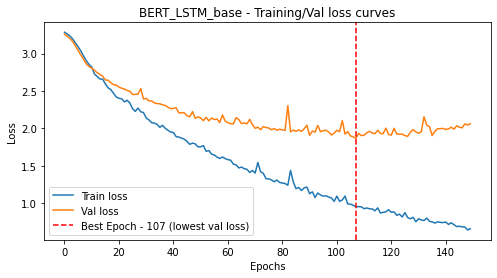

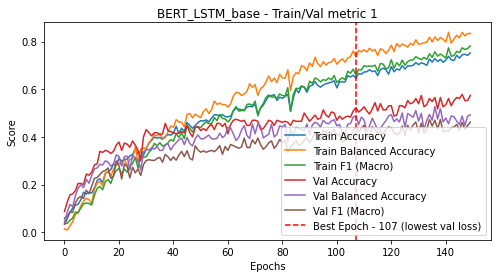

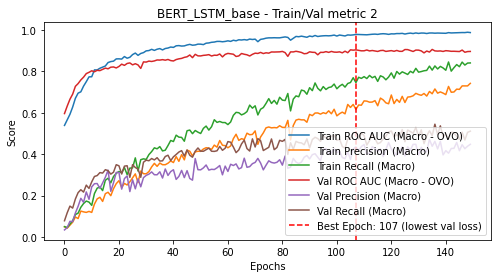

In [50]:
# #Clear memory
# import gc
# torch.cuda.empty_cache()
# gc.collect()

# #Begin training
# results = custom_train_val_loop.train_model(model = model,
#                       train_dataloader = train_dataloader,
#                       val_dataloader = val_dataloader,
#                       optimizer = optimizer,
#                       loss_fn = loss_fn,
#                       device = device,
#                       target_dir = target_dir,
#                       figure_dir = figure_dir,
#                       model_name = model_name,
#                       epochs = epochs)

## Test set evaluation

In [75]:
#instantiate model with the same architecture
loaded_model_0 = BertClassifier(output_shape = output_shape).to(device)

#since I saved many keys in the pth file, I need to specify that I want to load model_state_dict.
loaded_model_0.load_state_dict(torch.load(f = '..\model\BERT_LSTM_base_best_epoch_107.pth')['model_state_dict'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Inferencing on cuda.


  0%|          | 0/29 [00:00<?, ?it/s]

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\an

                            precision    recall  f1-score   support

                Bariatrics       0.00      0.00      0.00         2
Cardiovascular / Pulmonary       0.64      0.66      0.65        35
Cosmetic / Plastic Surgery       0.00      0.00      0.00         1
                 Dentistry       0.00      0.00      0.00         2
               Dermatology       1.00      0.67      0.80         3
      Diets and Nutritions       0.50      1.00      0.67         1
      ENT - Otolaryngology       0.55      0.67      0.60         9
             Endocrinology       1.00      1.00      1.00         2
          Gastroenterology       0.50      0.65      0.57        20
          General Medicine       0.12      0.10      0.11        20
     Hematology - Oncology       0.60      0.43      0.50         7
                Nephrology       0.25      0.50      0.33         6
                 Neurology       0.53      0.69      0.60        13
              Neurosurgery       0.25      0.50

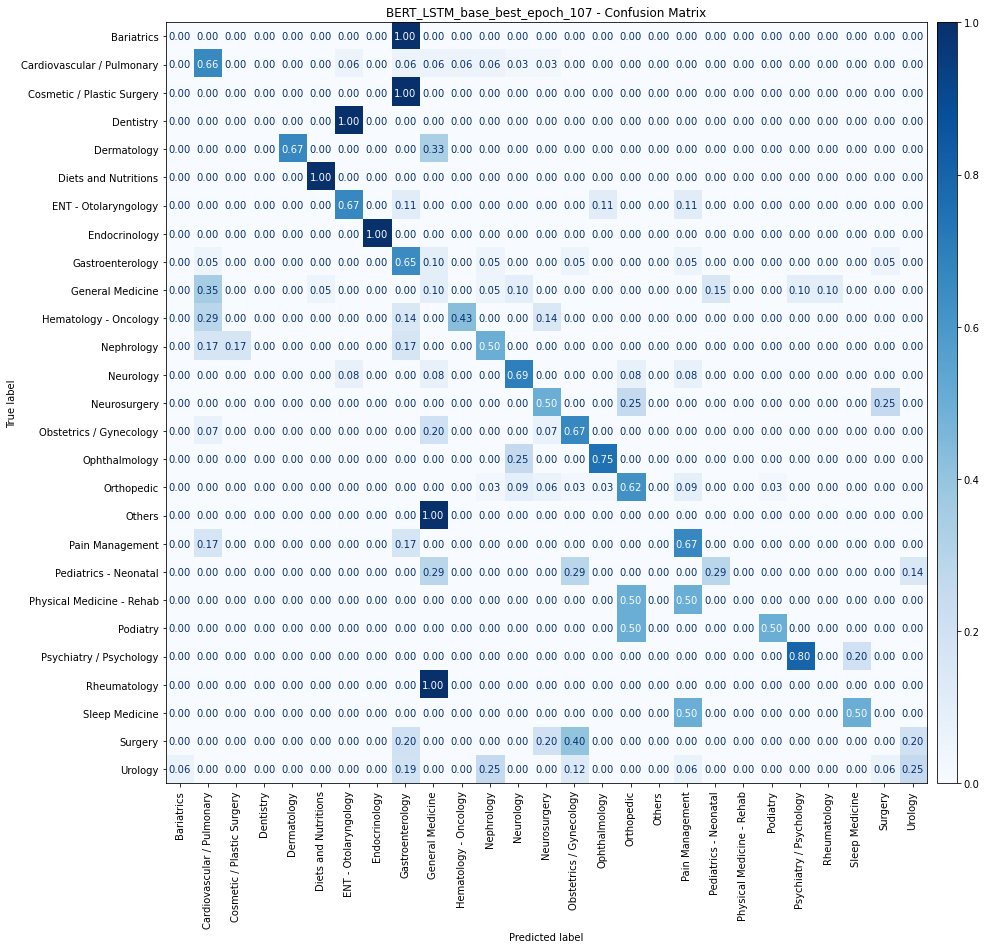

---------------------
Inference time for all test sample (cuda): 3.66 seconds
Number of all sample: 230 samples
Inference time for one sample (cuda): 0.02 seconds
---------------------
Accuracy: 0.52
Balanced accuracy: 0.44
ROC AUC (Macro - OVO): 0.91
Precision (Macro): 0.42
Recall (Macro): 0.44
F1 (Macro): 0.41
---------------------
Saving results dictionary as pickle file at (..\model\BERT_LSTM_base_best_epoch_107_test_results.pkl)


In [76]:
#initialize parameter
results_dir = '..\model'
figure_dir = '..\image'

results = test_set_evaluation.test_set_report(model = loaded_model_0,
                                              model_file_name = 'BERT_LSTM_base_best_epoch_107',
                                              results_dir = results_dir,
                                              figure_dir = figure_dir,
                                              test_dataloader = test_dataloader,
                                              class_map = class_number)

I will be looking at F1 macro score as all the classe should be treated equally regardless of the sample presented. A score of 0.41 in this case means the model still is not practical and will likely send the patient to the wrong specialties. This poor performance might be due to the limitation of BERT since it is trained with 512 token only due to quadratic increase in computational cost of larger context length [(Devlin j, 2018)](https://arxiv.org/abs/1810.04805). This obviously fails to capture the entire context of the corpus. Even though we can make BERT accept longer input, the model has not been trained with that and as such the embedding of token > 512 would be ill-defined and likely fail to capture the meaning of the words. Note that this is not 512 words but 512 token, including special tokens so the amount of words capture by BERT is actually < 510. There are many strategies to work around this limitation for long document, including propcessing text in chunk and aggregating the classifiers.

# Model 2: BERT_LSTM_truncate_from_left

[(Sun C, 2020)](https://arxiv.org/pdf/1905.05583.pdf) examined various strategy for fine-tuning BERT. One of the element tested was truncation strategy. They found that for IMDb dataset, for simple truncation, truncation from left (keep the last 510 tokens) performed better than truncation from right (keep the first 510 tokens). This suggested that more information is stored in IMDb dataset in the tail rather in the head. Perhaps the same is true in this medical transciption dataset. 

## Tokenization

In [42]:
#https://stackoverflow.com/questions/72202295/how-to-apply-max-length-to-truncate-the-token-sequence-from-the-left-in-a-huggin

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation_side = 'left') #the cased model is note case-sensitive

#Testing word tokenizer
example_text = "This is a test for BERT tokenizer with maximum 64 token and truncation left."
bert_input = tokenizer(example_text,padding='max_length', max_length = 64, 
                       truncation=True, return_tensors="pt")

print(example_text)
print('\nTokenized text')
print(tokenizer.convert_ids_to_tokens(bert_input['input_ids'][0]))

print('\ninput_ids')
print(bert_input['input_ids'])
print('\ntoken_type_ids')
print(bert_input['token_type_ids'])
print('\nattention_mask')
print(bert_input['attention_mask'])
print('-----------------------------------------------------------------------------')

#Testing word tokenizer
print('This is a test for BERT tokenizer with random sample from x_train with maximum 512 token truncation left due to BERT limitation.')
example_text = str(x_train.sample(1).values)

bert_input = tokenizer(example_text,padding='max_length', max_length = 512, 
                       truncation=True, return_tensors="pt")

print(example_text)
print('\nTokenized text')
print(tokenizer.convert_ids_to_tokens(bert_input['input_ids'][0]))

print('\ninput_ids')
print(bert_input['input_ids'])
print('\ntoken_type_ids')
print(bert_input['token_type_ids'])
print('\nattention_mask')
print(bert_input['attention_mask'])
print('-----------------------------------------------------------------------------')

This is a test for BERT tokenizer with maximum 64 token and truncation left.

Tokenized text
['[CLS]', 'this', 'is', 'a', 'test', 'for', 'bert', 'token', '##izer', 'with', 'maximum', '64', 'token', 'and', 'tr', '##un', '##cation', 'left', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

input_ids
tensor([[  101,  2023,  2003,  1037,  3231,  2005, 14324, 19204, 17629,  2007,
          4555,  4185, 19204,  1998, 19817,  4609, 10719,  2187,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,  

In [78]:
set_custom_seed.set_seed(50)

#instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation_side = 'left')
train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader = data_setup.create_dataloaders(x_train=x_train,
                                                                                    y_train = y_train,                
                                                                                    x_val= x_val,
                                                                                    y_val = y_val,
                                                                                    x_test = x_test,
                                                                                    y_test = y_test,
                                                                                    tokenizer = tokenizer,
                                                                                    max_length = 512, #BERT maximum length               
                                                                                    batch_size=8,
                                                                                    device = device
                                                                                    ) 

In [79]:
#Count the number of batch
print(f'Number of batches in train set:{len(train_dataloader)}')
print(f'Number of batches in val set:{len(val_dataloader)}')
print(f'Number of batches in test set:{len(test_dataloader)}')

#Getting a random sample from the training set
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random tokenized text from train data at index {random_number}')
single_text_embedding = train_data[random_number][0]
print(f'Dimension of a tokenized text (input Ids): {train_data[random_number][0].input_ids.size()}')
print(f'Data type: {train_data[random_number][0].input_ids.dtype}')
print(f'Label of data: {train_data[random_number][1]}')
print(f'Original tokenized text is:{tokenizer.convert_ids_to_tokens(train_data[random_number][0].input_ids.flatten())}')
print('The output from tokenizer is:')
print(single_text_embedding)

Number of batches in train set:229
Number of batches in val set:29
Number of batches in test set:29

Getting random tokenized text from train data at index 1712
Dimension of a tokenized text (input Ids): torch.Size([1, 512])
Data type: torch.int64
Label of data: 22
Original tokenized text is:['[CLS]', ',', 'judgment', ':', 'impaired', '.', 'the', 'patient', 'is', 'alert', 'and', 'oriented', 'to', 'person', ',', 'place', ',', 'date', ',', 'year', ',', 'but', 'not', 'day', 'of', 'the', 'week', '.', ',', 'laboratory', 'data', ':', ',', 'sodium', '144', ',', 'potassium', '4', '.', '2', ',', 'chloride', '106', ',', 'bi', '##carbon', '##ate', '27', ',', 'glucose', '183', ',', 'bun', '23', ',', 'cr', '##ea', '##tin', '##ine', '1', '.', '1', ',', 'and', 'calcium', '10', '.', '6', '.', 'ace', '##tam', '##ino', '##ph', '##en', 'level', '3', '.', '3', 'and', 'sal', '##ic', '##yla', '##te', 'level', 'less', 'than', '0', '.', '14', '.', 'wb', '##c', '7', '.', '41', ',', 'hem', '##og', '##lo', '##bi

## Model building

In [80]:
bert = BertModel.from_pretrained('bert-base-uncased')
output_shape = len(class_number) #Use number of class as output shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
class BertClassifier(nn.Module):

    def __init__(self, output_shape, hidden_dim=50, num_layers=1, dropout=0.5, bidirectional=False):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #get the size of embedding from BERT
        embedding_dim = self.bert.config.hidden_size
        
        #define LSTM
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim, #hidden dim is the dimension of the hidden state, so the higher it is, the more feature it can capture
                            num_layers=num_layers, # Number of recurrent layers, if 2, for example, maens stacking 2 LSTM together
                            bidirectional=bidirectional,
                            batch_first=True, #make the first dimension of the input and output the batch
                            dropout=0 if num_layers < 2 else dropout)    
                            
        # If the LSTM is bidirectional, it will have 2*hidden_dim units. If not, it will have hidden_dim units
        self.dropout = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        #define lienar layer
        self.linear = nn.Linear(lstm_output_dim, output_shape) 



    def forward(self, input_id, mask):
        
        # Feed input to BERT
        outputs = self.bert(input_ids= input_id, attention_mask=mask, return_dict=True)  # returns 2 output, last_hidden_state(embedding of all token) or pooler_output( embedding of the classification token only)
        #We will use the last_hidden_state as pooler_output does not capture information from sequence well according to huggingface documentation.
        
        # Feed BERT's output to the LSTM layer
        lstm_output, _ = self.lstm(outputs.last_hidden_state)  #LSTM will return output, (h_n, c_n). Output is output. (h_n, c_n) is the final hidden and cell states. 
        #The lstm output is (batch size, sequence length, hidden size [*2 if bidirectional = True]). It contains all output in every time step, that is to say the hidden state for every time step.
        #However, in classification, we only care about the last time step.
        #hence, we will only use the last time step of the output (the last value in sequence)
        final_output = lstm_output[:,-1,:]   #(Batch size, last time step, size of the output which should be the size of the hidden dimension * direction).
        #This should actually be the same as h_n as it is the output is the "last hidden state" anyhow.           

        # Pass the final output through dropout and the linear layer
        return self.linear(self.dropout(final_output))
    
#Instantiate model    
model_1 = BertClassifier(output_shape = output_shape).to(device) #don't forget to send to device 

#See model summary with torchinfo
# do a test pass through of an example inout data
#Bert expect two input, (input_ids, attention_mask) from the tokenizer like this: model_0(input_ids, attention_mask)
example_input_ids = torch.randint(0, 100, (1, 512)).to(device)
example_attention_mask = torch.ones((1, 512)).to(device)
summary(model_1, input_data=[example_input_ids, example_attention_mask], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the 

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
BertClassifier                                          --                        [1, 512]                  [1, 27]                   --                        --                        True
├─BertModel: 1-1                                        --                        --                        [1, 768]                  --                        --                        True
│    └─BertEmbeddings: 2-1                              --                        --                        [1, 512, 768]             --                        --                        True
│    │    └─Embedding: 3-1                              --                        [1, 512]                  [1, 512, 768]             23,440,896                23,440,896                True
│    │    └─Embedding: 3-2              

Freezing BERT's layer.

In [82]:
# Freeze all parameters
for param in model_1.parameters():
    param.requires_grad = False

#Unfrozen only the LSTM and linear layer
for param in model_1.linear.parameters():
    param.requires_grad = True
for param in model_1.lstm.parameters():
    param.requires_grad = True    
    
#Print model summary after freezing layers
summary(model_1, input_data=[example_input_ids, example_attention_mask], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
BertClassifier                                          --                        [1, 512]                  [1, 27]                   --                        --                        Partial
├─BertModel: 1-1                                        --                        --                        [1, 768]                  --                        --                        False
│    └─BertEmbeddings: 2-1                              --                        --                        [1, 512, 768]             --                        --                        False
│    │    └─Embedding: 3-1                              --                        [1, 512]                  [1, 512, 768]             (23,440,896)              23,440,896                False
│    │    └─Embedding: 3-2        

In [83]:
#Testing the model on a single training data
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random embedding from train data at index {random_number}')
single_text_embedding = train_data[random_number][0]
print(f'Dimension of an embedding (input Ids): {train_data[random_number][0].input_ids.size()}')
print(f'Data type: {train_data[random_number][0].input_ids.dtype}')
print(f'Original tokenized text is:{tokenizer.convert_ids_to_tokens(train_data[random_number][0].input_ids.flatten())}')

# Perform a forward pass on a single image
model_1.eval() #set to eval
train_data[random_number][0].to(device)
with torch.inference_mode(): #set to inference mode
    sample_pred_logit = model_1(train_data[random_number][0].input_ids, train_data[random_number][0].attention_mask)   #predict the image on GPU

sample_pred_prob = torch.softmax(sample_pred_logit, dim = 1) #use softmax for multiclass classification to convert logit into prob
sample_pred_class = torch.argmax(sample_pred_prob, dim=1) #use argmax to find the index with the largest probability and use that as the class label
    
# Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{sample_pred_logit}\n") #Print the logit
print(f"Output prediction probabilities:\n{sample_pred_prob}\n") #Print the probability for each class
print(f"Output prediction label:\n{sample_pred_class}\n") #Select the maximum probability as predicted label.
print(f"Actual label:\n{train_data[random_number][1]}") #Get the actual label.

  


Getting random embedding from train data at index 1504
Dimension of an embedding (input Ids): torch.Size([1, 512])
Data type: torch.int64
Original tokenized text is:['[CLS]', 'pre', '##oper', '##ative', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'post', '##pro', '##ced', '##ure', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'procedure', ':', ',', 'the', 'patient', 'gave', 'informed', 'consent', 'for', 'his', 'procedure', '.', 'after', 'informed', 'consent', 'was', 'obtained', ',', 'attention', 'was', 'turned', 'toward', 'the', 'area', 'of', 'interest', ',', 'which', 'was', 'prep', '##ped', 'and', 'draped', 'in', 'the', 'usual', 'sterile', 'fashion', '.', ',', 'local', 'an', '##est', '##hetic', 'medication', 'was', 'infiltrate', '##d', 'around', 'and', 'into', 'the', 'area', 'of', 'interest', '.', 'there', 'was', 'an', 'obvious', 'skin', 'les', '##ion', 'there', 'and', 

## Training loop - Do not run if do not want to train again.

In [48]:
# #define Loss function
# loss_fn = nn.CrossEntropyLoss(weight = class_weights.to(device))
# #define optimizer
# optimizer = torch.optim.Adam(model_1.parameters(), lr= 1e-4)
# # Set the seed 
# set_custom_seed.set_seed(50)

# #initialize parameter for custom train loop module
# model = model_1
# train_dataloader = train_dataloader
# val_dataloader = val_dataloader
# optimizer = optimizer
# loss_fn = loss_fn
# device = device
# target_dir = '..\model'
# figure_dir = '..\image'
# model_name = 'BERT_LSTM_truncate_left'
# epochs = 150

Training on cuda.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.28955 | Val loss: 3.27121
Train accuracy: 0.05568 | Train balanced accuracy: 0.00604 | Train F1 score: 0.03075 | Train ROC AUC score: 0.53295
Validation accuracy: 0.10000 | Validation balanced accuracy: 0.07376 | Validation F1 score: 0.04651 | Val ROC AUC score: 0.56093

Epoch: 1
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.26120 | Val loss: 3.24369
Train accuracy: 0.06550 | Train balanced accuracy: 0.01442 | Train F1 score: 0.03752 | Train ROC AUC score: 0.57834
Validation accuracy: 0.13043 | Validation balanced accuracy: 0.08560 | Validation F1 score: 0.06258 | Val ROC AUC score: 0.60991

Epoch: 2
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.22362 | Val loss: 3.20811
Train accuracy: 0.07751 | Train balanced accuracy: 0.02364 | Train F1 score: 0.04271 | Train ROC AUC score: 0.61820
Validation accuracy: 0.13478 | Validation balanced accuracy: 0.10758 | Validation F1 score: 0.07705 | Val ROC AUC score: 0.63682

Epoch: 3
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.18685 | Val loss: 3.17563
Train accuracy: 0.09825 | Train balanced accuracy: 0.04777 | Train F1 score: 0.06883 | Train ROC AUC score: 0.63712
Validation accuracy: 0.13913 | Validation balanced accuracy: 0.10620 | Validation F1 score: 0.07226 | Val ROC AUC score: 0.65773

Epoch: 4
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.14875 | Val loss: 3.13249
Train accuracy: 0.10808 | Train balanced accuracy: 0.05846 | Train F1 score: 0.07239 | Train ROC AUC score: 0.67169
Validation accuracy: 0.15217 | Validation balanced accuracy: 0.09579 | Validation F1 score: 0.07142 | Val ROC AUC score: 0.69702

Epoch: 5
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.09360 | Val loss: 3.08471
Train accuracy: 0.12009 | Train balanced accuracy: 0.07680 | Train F1 score: 0.08329 | Train ROC AUC score: 0.69374
Validation accuracy: 0.18261 | Validation balanced accuracy: 0.14194 | Validation F1 score: 0.11718 | Val ROC AUC score: 0.72102

Epoch: 6
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.03710 | Val loss: 3.02907
Train accuracy: 0.13155 | Train balanced accuracy: 0.09729 | Train F1 score: 0.09532 | Train ROC AUC score: 0.71300
Validation accuracy: 0.16522 | Validation balanced accuracy: 0.13434 | Validation F1 score: 0.10572 | Val ROC AUC score: 0.75029

Epoch: 7
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.97506 | Val loss: 2.98387
Train accuracy: 0.14629 | Train balanced accuracy: 0.12415 | Train F1 score: 0.11054 | Train ROC AUC score: 0.72776
Validation accuracy: 0.19565 | Validation balanced accuracy: 0.15741 | Validation F1 score: 0.11281 | Val ROC AUC score: 0.76184

Epoch: 8
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.92912 | Val loss: 2.94550
Train accuracy: 0.14574 | Train balanced accuracy: 0.11160 | Train F1 score: 0.10356 | Train ROC AUC score: 0.75295
Validation accuracy: 0.17391 | Validation balanced accuracy: 0.14014 | Validation F1 score: 0.10178 | Val ROC AUC score: 0.77301

Epoch: 9
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.88677 | Val loss: 2.89019
Train accuracy: 0.16594 | Train balanced accuracy: 0.13875 | Train F1 score: 0.12129 | Train ROC AUC score: 0.75994
Validation accuracy: 0.19565 | Validation balanced accuracy: 0.17162 | Validation F1 score: 0.12973 | Val ROC AUC score: 0.78652

Epoch: 10
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.84620 | Val loss: 2.86157
Train accuracy: 0.17795 | Train balanced accuracy: 0.15870 | Train F1 score: 0.14108 | Train ROC AUC score: 0.77192
Validation accuracy: 0.20435 | Validation balanced accuracy: 0.16546 | Validation F1 score: 0.14191 | Val ROC AUC score: 0.79277

Epoch: 11
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.80471 | Val loss: 2.81726
Train accuracy: 0.18559 | Train balanced accuracy: 0.19271 | Train F1 score: 0.16990 | Train ROC AUC score: 0.77998
Validation accuracy: 0.25652 | Validation balanced accuracy: 0.20092 | Validation F1 score: 0.16800 | Val ROC AUC score: 0.81176

Epoch: 12
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.76756 | Val loss: 2.79605
Train accuracy: 0.17959 | Train balanced accuracy: 0.17419 | Train F1 score: 0.14666 | Train ROC AUC score: 0.78673
Validation accuracy: 0.25217 | Validation balanced accuracy: 0.19818 | Validation F1 score: 0.18410 | Val ROC AUC score: 0.80717

Epoch: 13
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.74063 | Val loss: 2.75039
Train accuracy: 0.20961 | Train balanced accuracy: 0.19553 | Train F1 score: 0.17065 | Train ROC AUC score: 0.79518
Validation accuracy: 0.27391 | Validation balanced accuracy: 0.21683 | Validation F1 score: 0.18532 | Val ROC AUC score: 0.81907

Epoch: 14
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.66861 | Val loss: 2.73914
Train accuracy: 0.20742 | Train balanced accuracy: 0.23253 | Train F1 score: 0.20151 | Train ROC AUC score: 0.81754
Validation accuracy: 0.26087 | Validation balanced accuracy: 0.20333 | Validation F1 score: 0.17194 | Val ROC AUC score: 0.82170

Epoch: 15
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.66542 | Val loss: 2.70249
Train accuracy: 0.22107 | Train balanced accuracy: 0.22863 | Train F1 score: 0.19400 | Train ROC AUC score: 0.81109
Validation accuracy: 0.27826 | Validation balanced accuracy: 0.21743 | Validation F1 score: 0.17790 | Val ROC AUC score: 0.82322

Epoch: 16
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.61733 | Val loss: 2.68977
Train accuracy: 0.21834 | Train balanced accuracy: 0.23368 | Train F1 score: 0.19781 | Train ROC AUC score: 0.82709
Validation accuracy: 0.30000 | Validation balanced accuracy: 0.22293 | Validation F1 score: 0.18594 | Val ROC AUC score: 0.83063

Epoch: 17
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.58798 | Val loss: 2.65670
Train accuracy: 0.22926 | Train balanced accuracy: 0.23607 | Train F1 score: 0.19799 | Train ROC AUC score: 0.82876
Validation accuracy: 0.30000 | Validation balanced accuracy: 0.23527 | Validation F1 score: 0.19760 | Val ROC AUC score: 0.83443

Epoch: 18
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.54825 | Val loss: 2.65942
Train accuracy: 0.23745 | Train balanced accuracy: 0.24412 | Train F1 score: 0.20985 | Train ROC AUC score: 0.83631
Validation accuracy: 0.30870 | Validation balanced accuracy: 0.23490 | Validation F1 score: 0.20660 | Val ROC AUC score: 0.83230

Epoch: 19
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.51727 | Val loss: 2.62214
Train accuracy: 0.24509 | Train balanced accuracy: 0.26588 | Train F1 score: 0.22343 | Train ROC AUC score: 0.84388
Validation accuracy: 0.31304 | Validation balanced accuracy: 0.22667 | Validation F1 score: 0.20894 | Val ROC AUC score: 0.83860

Epoch: 20
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.47737 | Val loss: 2.59203
Train accuracy: 0.27893 | Train balanced accuracy: 0.30619 | Train F1 score: 0.27238 | Train ROC AUC score: 0.84541
Validation accuracy: 0.30000 | Validation balanced accuracy: 0.22311 | Validation F1 score: 0.18910 | Val ROC AUC score: 0.84362

Epoch: 21
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.45910 | Val loss: 2.59210
Train accuracy: 0.26638 | Train balanced accuracy: 0.27761 | Train F1 score: 0.23846 | Train ROC AUC score: 0.84747
Validation accuracy: 0.31739 | Validation balanced accuracy: 0.24293 | Validation F1 score: 0.21004 | Val ROC AUC score: 0.83690

Epoch: 22
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.44284 | Val loss: 2.58613
Train accuracy: 0.26146 | Train balanced accuracy: 0.27575 | Train F1 score: 0.23953 | Train ROC AUC score: 0.85324
Validation accuracy: 0.30870 | Validation balanced accuracy: 0.22364 | Validation F1 score: 0.19381 | Val ROC AUC score: 0.84018

Epoch: 23
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.43175 | Val loss: 2.55190
Train accuracy: 0.27238 | Train balanced accuracy: 0.27698 | Train F1 score: 0.24191 | Train ROC AUC score: 0.85671
Validation accuracy: 0.33043 | Validation balanced accuracy: 0.25250 | Validation F1 score: 0.22975 | Val ROC AUC score: 0.84450

Epoch: 24
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.36155 | Val loss: 2.51076
Train accuracy: 0.29749 | Train balanced accuracy: 0.31308 | Train F1 score: 0.28115 | Train ROC AUC score: 0.86745
Validation accuracy: 0.34348 | Validation balanced accuracy: 0.24742 | Validation F1 score: 0.21698 | Val ROC AUC score: 0.85103

Epoch: 25
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.33213 | Val loss: 2.49751
Train accuracy: 0.30622 | Train balanced accuracy: 0.30803 | Train F1 score: 0.28043 | Train ROC AUC score: 0.87012
Validation accuracy: 0.33478 | Validation balanced accuracy: 0.24512 | Validation F1 score: 0.21240 | Val ROC AUC score: 0.84960

Epoch: 26
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.29326 | Val loss: 2.51156
Train accuracy: 0.31550 | Train balanced accuracy: 0.33069 | Train F1 score: 0.29084 | Train ROC AUC score: 0.88108
Validation accuracy: 0.30870 | Validation balanced accuracy: 0.22863 | Validation F1 score: 0.19756 | Val ROC AUC score: 0.84900

Epoch: 27
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.31758 | Val loss: 2.44861
Train accuracy: 0.30786 | Train balanced accuracy: 0.32292 | Train F1 score: 0.28571 | Train ROC AUC score: 0.87027
Validation accuracy: 0.36957 | Validation balanced accuracy: 0.24806 | Validation F1 score: 0.24184 | Val ROC AUC score: 0.85245

Epoch: 28
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.25133 | Val loss: 2.43748
Train accuracy: 0.34170 | Train balanced accuracy: 0.36913 | Train F1 score: 0.32669 | Train ROC AUC score: 0.88258
Validation accuracy: 0.30870 | Validation balanced accuracy: 0.22888 | Validation F1 score: 0.19905 | Val ROC AUC score: 0.85469

Epoch: 29
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.24538 | Val loss: 2.46603
Train accuracy: 0.31441 | Train balanced accuracy: 0.34131 | Train F1 score: 0.29447 | Train ROC AUC score: 0.88438
Validation accuracy: 0.30870 | Validation balanced accuracy: 0.22517 | Validation F1 score: 0.19313 | Val ROC AUC score: 0.84595

Epoch: 30
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.21892 | Val loss: 2.42361
Train accuracy: 0.32533 | Train balanced accuracy: 0.36873 | Train F1 score: 0.31357 | Train ROC AUC score: 0.88594
Validation accuracy: 0.33913 | Validation balanced accuracy: 0.23867 | Validation F1 score: 0.22058 | Val ROC AUC score: 0.85659

Epoch: 31
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.17457 | Val loss: 2.40296
Train accuracy: 0.34498 | Train balanced accuracy: 0.37326 | Train F1 score: 0.32722 | Train ROC AUC score: 0.88968
Validation accuracy: 0.33478 | Validation balanced accuracy: 0.24460 | Validation F1 score: 0.21631 | Val ROC AUC score: 0.85845

Epoch: 32
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.16015 | Val loss: 2.38544
Train accuracy: 0.33406 | Train balanced accuracy: 0.35237 | Train F1 score: 0.30975 | Train ROC AUC score: 0.89491
Validation accuracy: 0.36522 | Validation balanced accuracy: 0.25450 | Validation F1 score: 0.24156 | Val ROC AUC score: 0.85997

Epoch: 33
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.12482 | Val loss: 2.41197
Train accuracy: 0.35535 | Train balanced accuracy: 0.38782 | Train F1 score: 0.34639 | Train ROC AUC score: 0.89674
Validation accuracy: 0.33043 | Validation balanced accuracy: 0.23217 | Validation F1 score: 0.21889 | Val ROC AUC score: 0.85456

Epoch: 34
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.12494 | Val loss: 2.36300
Train accuracy: 0.35753 | Train balanced accuracy: 0.37929 | Train F1 score: 0.33751 | Train ROC AUC score: 0.89433
Validation accuracy: 0.37391 | Validation balanced accuracy: 0.27648 | Validation F1 score: 0.26985 | Val ROC AUC score: 0.86328

Epoch: 35
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.07584 | Val loss: 2.35970
Train accuracy: 0.38592 | Train balanced accuracy: 0.43462 | Train F1 score: 0.37906 | Train ROC AUC score: 0.90428
Validation accuracy: 0.35217 | Validation balanced accuracy: 0.26868 | Validation F1 score: 0.25849 | Val ROC AUC score: 0.86143

Epoch: 36
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.05917 | Val loss: 2.31525
Train accuracy: 0.37172 | Train balanced accuracy: 0.42160 | Train F1 score: 0.36713 | Train ROC AUC score: 0.90398
Validation accuracy: 0.39130 | Validation balanced accuracy: 0.28733 | Validation F1 score: 0.27821 | Val ROC AUC score: 0.86569

Epoch: 37
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.04310 | Val loss: 2.30889
Train accuracy: 0.37336 | Train balanced accuracy: 0.40841 | Train F1 score: 0.36535 | Train ROC AUC score: 0.90712
Validation accuracy: 0.37391 | Validation balanced accuracy: 0.29531 | Validation F1 score: 0.28819 | Val ROC AUC score: 0.86719

Epoch: 38
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.02924 | Val loss: 2.31008
Train accuracy: 0.37937 | Train balanced accuracy: 0.42788 | Train F1 score: 0.37212 | Train ROC AUC score: 0.90434
Validation accuracy: 0.34783 | Validation balanced accuracy: 0.29077 | Validation F1 score: 0.26989 | Val ROC AUC score: 0.86866

Epoch: 39
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.00083 | Val loss: 2.29934
Train accuracy: 0.39138 | Train balanced accuracy: 0.43510 | Train F1 score: 0.37988 | Train ROC AUC score: 0.91289
Validation accuracy: 0.38261 | Validation balanced accuracy: 0.29417 | Validation F1 score: 0.28029 | Val ROC AUC score: 0.86443

Epoch: 40
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.95645 | Val loss: 2.25957
Train accuracy: 0.39902 | Train balanced accuracy: 0.44802 | Train F1 score: 0.39120 | Train ROC AUC score: 0.91750
Validation accuracy: 0.37391 | Validation balanced accuracy: 0.30011 | Validation F1 score: 0.29411 | Val ROC AUC score: 0.86817

Epoch: 41
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.94894 | Val loss: 2.24241
Train accuracy: 0.39847 | Train balanced accuracy: 0.45119 | Train F1 score: 0.39441 | Train ROC AUC score: 0.91445
Validation accuracy: 0.39130 | Validation balanced accuracy: 0.29027 | Validation F1 score: 0.29691 | Val ROC AUC score: 0.87309

Epoch: 42
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.92059 | Val loss: 2.19922
Train accuracy: 0.41048 | Train balanced accuracy: 0.46529 | Train F1 score: 0.41219 | Train ROC AUC score: 0.91811
Validation accuracy: 0.38696 | Validation balanced accuracy: 0.28614 | Validation F1 score: 0.27044 | Val ROC AUC score: 0.87760

Epoch: 43
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.89253 | Val loss: 2.21884
Train accuracy: 0.40884 | Train balanced accuracy: 0.47671 | Train F1 score: 0.40878 | Train ROC AUC score: 0.92219
Validation accuracy: 0.39130 | Validation balanced accuracy: 0.29780 | Validation F1 score: 0.29124 | Val ROC AUC score: 0.87286

Epoch: 44
-------
Train loss: 1.92265 | Val loss: 2.18791
Train accuracy: 0.40175 | Train balanced accuracy: 0.45515 | Train F1 score: 0.39721 | Train ROC AUC score: 0.91971
Validation accuracy: 0.41304 | Validation balanced accuracy: 0.31024 | Validation F1 score: 0.30849 | Val ROC AUC score: 0.87832

Epoch: 45
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.02237 | Val loss: 2.73601
Train accuracy: 0.37937 | Train balanced accuracy: 0.43963 | Train F1 score: 0.38432 | Train ROC AUC score: 0.90071
Validation accuracy: 0.27391 | Validation balanced accuracy: 0.17520 | Validation F1 score: 0.14738 | Val ROC AUC score: 0.82500

Epoch: 46
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.18530 | Val loss: 2.34289
Train accuracy: 0.31878 | Train balanced accuracy: 0.38730 | Train F1 score: 0.30436 | Train ROC AUC score: 0.89077
Validation accuracy: 0.33478 | Validation balanced accuracy: 0.32978 | Validation F1 score: 0.28014 | Val ROC AUC score: 0.85380

Epoch: 47
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.97593 | Val loss: 2.26882
Train accuracy: 0.37063 | Train balanced accuracy: 0.45959 | Train F1 score: 0.37710 | Train ROC AUC score: 0.91294
Validation accuracy: 0.37391 | Validation balanced accuracy: 0.31634 | Validation F1 score: 0.28780 | Val ROC AUC score: 0.85396

Epoch: 48
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.87143 | Val loss: 2.23480
Train accuracy: 0.39465 | Train balanced accuracy: 0.47077 | Train F1 score: 0.40271 | Train ROC AUC score: 0.92358
Validation accuracy: 0.37826 | Validation balanced accuracy: 0.29690 | Validation F1 score: 0.28764 | Val ROC AUC score: 0.85813

Epoch: 49
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.88957 | Val loss: 2.21141
Train accuracy: 0.40775 | Train balanced accuracy: 0.45206 | Train F1 score: 0.39225 | Train ROC AUC score: 0.92013
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.33321 | Validation F1 score: 0.32515 | Val ROC AUC score: 0.86528

Epoch: 50
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.84884 | Val loss: 2.16006
Train accuracy: 0.41758 | Train balanced accuracy: 0.46605 | Train F1 score: 0.41827 | Train ROC AUC score: 0.92529
Validation accuracy: 0.40435 | Validation balanced accuracy: 0.31644 | Validation F1 score: 0.29739 | Val ROC AUC score: 0.87386

Epoch: 51
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.84328 | Val loss: 2.19421
Train accuracy: 0.41594 | Train balanced accuracy: 0.49494 | Train F1 score: 0.43827 | Train ROC AUC score: 0.92181
Validation accuracy: 0.40435 | Validation balanced accuracy: 0.35490 | Validation F1 score: 0.33483 | Val ROC AUC score: 0.87075

Epoch: 52
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.82584 | Val loss: 2.18732
Train accuracy: 0.41648 | Train balanced accuracy: 0.49463 | Train F1 score: 0.43027 | Train ROC AUC score: 0.92537
Validation accuracy: 0.39130 | Validation balanced accuracy: 0.37864 | Validation F1 score: 0.34598 | Val ROC AUC score: 0.86967

Epoch: 53
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.78329 | Val loss: 2.14123
Train accuracy: 0.42740 | Train balanced accuracy: 0.49429 | Train F1 score: 0.42653 | Train ROC AUC score: 0.92834
Validation accuracy: 0.41304 | Validation balanced accuracy: 0.36446 | Validation F1 score: 0.34091 | Val ROC AUC score: 0.88019

Epoch: 54
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.74436 | Val loss: 2.16507
Train accuracy: 0.43668 | Train balanced accuracy: 0.50316 | Train F1 score: 0.44735 | Train ROC AUC score: 0.93366
Validation accuracy: 0.41304 | Validation balanced accuracy: 0.34280 | Validation F1 score: 0.32205 | Val ROC AUC score: 0.87567

Epoch: 55
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.75012 | Val loss: 2.13735
Train accuracy: 0.44323 | Train balanced accuracy: 0.53291 | Train F1 score: 0.45878 | Train ROC AUC score: 0.93068
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.36337 | Validation F1 score: 0.33597 | Val ROC AUC score: 0.87596

Epoch: 56
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.71536 | Val loss: 2.11062
Train accuracy: 0.45742 | Train balanced accuracy: 0.52801 | Train F1 score: 0.45859 | Train ROC AUC score: 0.93778
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.34231 | Validation F1 score: 0.33316 | Val ROC AUC score: 0.87785

Epoch: 57
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.71897 | Val loss: 2.09539
Train accuracy: 0.44924 | Train balanced accuracy: 0.50763 | Train F1 score: 0.45451 | Train ROC AUC score: 0.93445
Validation accuracy: 0.42609 | Validation balanced accuracy: 0.37056 | Validation F1 score: 0.35236 | Val ROC AUC score: 0.88615

Epoch: 58
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.72304 | Val loss: 2.10920
Train accuracy: 0.45197 | Train balanced accuracy: 0.52205 | Train F1 score: 0.47081 | Train ROC AUC score: 0.93372
Validation accuracy: 0.43478 | Validation balanced accuracy: 0.37659 | Validation F1 score: 0.34229 | Val ROC AUC score: 0.87799

Epoch: 59
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.68010 | Val loss: 2.07766
Train accuracy: 0.47271 | Train balanced accuracy: 0.53963 | Train F1 score: 0.47465 | Train ROC AUC score: 0.93689
Validation accuracy: 0.44783 | Validation balanced accuracy: 0.34417 | Validation F1 score: 0.34239 | Val ROC AUC score: 0.88720

Epoch: 60
-------
Train loss: 1.67828 | Val loss: 2.08851
Train accuracy: 0.46452 | Train balanced accuracy: 0.52832 | Train F1 score: 0.46969 | Train ROC AUC score: 0.93744
Validation accuracy: 0.42174 | Validation balanced accuracy: 0.37898 | Validation F1 score: 0.34398 | Val ROC AUC score: 0.88438

Epoch: 61
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.69309 | Val loss: 2.05294
Train accuracy: 0.44814 | Train balanced accuracy: 0.51136 | Train F1 score: 0.44625 | Train ROC AUC score: 0.93456
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.38091 | Validation F1 score: 0.33811 | Val ROC AUC score: 0.88954

Epoch: 62
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.61319 | Val loss: 2.06581
Train accuracy: 0.46343 | Train balanced accuracy: 0.54803 | Train F1 score: 0.47443 | Train ROC AUC score: 0.94326
Validation accuracy: 0.46087 | Validation balanced accuracy: 0.35229 | Validation F1 score: 0.34127 | Val ROC AUC score: 0.88251

Epoch: 63
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.61887 | Val loss: 2.08910
Train accuracy: 0.48144 | Train balanced accuracy: 0.55754 | Train F1 score: 0.49164 | Train ROC AUC score: 0.94124
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.30856 | Validation F1 score: 0.32223 | Val ROC AUC score: 0.88057

Epoch: 64
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.61859 | Val loss: 2.04742
Train accuracy: 0.46397 | Train balanced accuracy: 0.52629 | Train F1 score: 0.46934 | Train ROC AUC score: 0.94055
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.37671 | Validation F1 score: 0.34033 | Val ROC AUC score: 0.88380

Epoch: 65
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.59379 | Val loss: 2.05020
Train accuracy: 0.47162 | Train balanced accuracy: 0.54263 | Train F1 score: 0.47938 | Train ROC AUC score: 0.94361
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.35476 | Validation F1 score: 0.33893 | Val ROC AUC score: 0.88458

Epoch: 66
-------
Train loss: 1.62031 | Val loss: 2.18227
Train accuracy: 0.47817 | Train balanced accuracy: 0.57385 | Train F1 score: 0.48812 | Train ROC AUC score: 0.93983
Validation accuracy: 0.40435 | Validation balanced accuracy: 0.37059 | Validation F1 score: 0.34658 | Val ROC AUC score: 0.86146

Epoch: 67
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.62579 | Val loss: 2.08276
Train accuracy: 0.45906 | Train balanced accuracy: 0.53370 | Train F1 score: 0.45764 | Train ROC AUC score: 0.94105
Validation accuracy: 0.43478 | Validation balanced accuracy: 0.35894 | Validation F1 score: 0.33510 | Val ROC AUC score: 0.88455

Epoch: 68
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.55062 | Val loss: 2.03184
Train accuracy: 0.49127 | Train balanced accuracy: 0.56707 | Train F1 score: 0.50878 | Train ROC AUC score: 0.94707
Validation accuracy: 0.43913 | Validation balanced accuracy: 0.37173 | Validation F1 score: 0.35774 | Val ROC AUC score: 0.88894

Epoch: 69
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.54277 | Val loss: 1.98879
Train accuracy: 0.48908 | Train balanced accuracy: 0.57886 | Train F1 score: 0.50483 | Train ROC AUC score: 0.94608
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.34801 | Validation F1 score: 0.34538 | Val ROC AUC score: 0.89252

Epoch: 70
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.53635 | Val loss: 2.02166
Train accuracy: 0.49345 | Train balanced accuracy: 0.57649 | Train F1 score: 0.50672 | Train ROC AUC score: 0.94699
Validation accuracy: 0.43478 | Validation balanced accuracy: 0.34344 | Validation F1 score: 0.33103 | Val ROC AUC score: 0.88929

Epoch: 71
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.49858 | Val loss: 2.09108
Train accuracy: 0.50382 | Train balanced accuracy: 0.60361 | Train F1 score: 0.53497 | Train ROC AUC score: 0.94957
Validation accuracy: 0.42609 | Validation balanced accuracy: 0.35546 | Validation F1 score: 0.33396 | Val ROC AUC score: 0.87821

Epoch: 72
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.49108 | Val loss: 1.95450
Train accuracy: 0.49400 | Train balanced accuracy: 0.57210 | Train F1 score: 0.50080 | Train ROC AUC score: 0.95163
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.39594 | Validation F1 score: 0.38534 | Val ROC AUC score: 0.89959

Epoch: 73
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.51210 | Val loss: 1.97120
Train accuracy: 0.49618 | Train balanced accuracy: 0.56253 | Train F1 score: 0.50615 | Train ROC AUC score: 0.94709
Validation accuracy: 0.46957 | Validation balanced accuracy: 0.40921 | Validation F1 score: 0.39156 | Val ROC AUC score: 0.89288

Epoch: 74
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.44277 | Val loss: 1.94949
Train accuracy: 0.52456 | Train balanced accuracy: 0.61189 | Train F1 score: 0.53756 | Train ROC AUC score: 0.95293
Validation accuracy: 0.42609 | Validation balanced accuracy: 0.39865 | Validation F1 score: 0.36971 | Val ROC AUC score: 0.89500

Epoch: 75
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.46388 | Val loss: 1.97242
Train accuracy: 0.51528 | Train balanced accuracy: 0.60531 | Train F1 score: 0.53247 | Train ROC AUC score: 0.95218
Validation accuracy: 0.46087 | Validation balanced accuracy: 0.40186 | Validation F1 score: 0.37297 | Val ROC AUC score: 0.89277

Epoch: 76
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.52211 | Val loss: 2.02696
Train accuracy: 0.50273 | Train balanced accuracy: 0.56527 | Train F1 score: 0.49728 | Train ROC AUC score: 0.94495
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.35839 | Validation F1 score: 0.34893 | Val ROC AUC score: 0.88339

Epoch: 77
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.43691 | Val loss: 2.01251
Train accuracy: 0.51146 | Train balanced accuracy: 0.62141 | Train F1 score: 0.52846 | Train ROC AUC score: 0.95400
Validation accuracy: 0.44783 | Validation balanced accuracy: 0.39668 | Validation F1 score: 0.38918 | Val ROC AUC score: 0.88088

Epoch: 78
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.42883 | Val loss: 1.93530
Train accuracy: 0.52238 | Train balanced accuracy: 0.61225 | Train F1 score: 0.54728 | Train ROC AUC score: 0.95516
Validation accuracy: 0.45217 | Validation balanced accuracy: 0.40511 | Validation F1 score: 0.39043 | Val ROC AUC score: 0.89569

Epoch: 79
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.42890 | Val loss: 1.94845
Train accuracy: 0.51528 | Train balanced accuracy: 0.60577 | Train F1 score: 0.53450 | Train ROC AUC score: 0.95185
Validation accuracy: 0.43913 | Validation balanced accuracy: 0.38879 | Validation F1 score: 0.36572 | Val ROC AUC score: 0.89828

Epoch: 80
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.40324 | Val loss: 1.92249
Train accuracy: 0.51747 | Train balanced accuracy: 0.60656 | Train F1 score: 0.53673 | Train ROC AUC score: 0.95606
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.40463 | Validation F1 score: 0.39070 | Val ROC AUC score: 0.90150

Epoch: 81
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.39425 | Val loss: 1.89918
Train accuracy: 0.52456 | Train balanced accuracy: 0.63533 | Train F1 score: 0.55257 | Train ROC AUC score: 0.95485
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.40249 | Validation F1 score: 0.37654 | Val ROC AUC score: 0.90009

Epoch: 82
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.34799 | Val loss: 1.91500
Train accuracy: 0.54476 | Train balanced accuracy: 0.63874 | Train F1 score: 0.57462 | Train ROC AUC score: 0.95833
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.38014 | Validation F1 score: 0.36638 | Val ROC AUC score: 0.90093

Epoch: 83
-------
Train loss: 1.32803 | Val loss: 1.90245
Train accuracy: 0.54803 | Train balanced accuracy: 0.63659 | Train F1 score: 0.56161 | Train ROC AUC score: 0.96096
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.41431 | Validation F1 score: 0.40461 | Val ROC AUC score: 0.90299

Epoch: 84
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.43839 | Val loss: 2.16243
Train accuracy: 0.51419 | Train balanced accuracy: 0.57962 | Train F1 score: 0.52792 | Train ROC AUC score: 0.94962
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.38074 | Validation F1 score: 0.36068 | Val ROC AUC score: 0.87520

Epoch: 85
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.35158 | Val loss: 1.91453
Train accuracy: 0.52893 | Train balanced accuracy: 0.62917 | Train F1 score: 0.55877 | Train ROC AUC score: 0.95757
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.43691 | Validation F1 score: 0.40548 | Val ROC AUC score: 0.90421

Epoch: 86
-------
Train loss: 1.33266 | Val loss: 1.94240
Train accuracy: 0.55295 | Train balanced accuracy: 0.64040 | Train F1 score: 0.57138 | Train ROC AUC score: 0.95970
Validation accuracy: 0.43913 | Validation balanced accuracy: 0.39906 | Validation F1 score: 0.38607 | Val ROC AUC score: 0.89257

Epoch: 87
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.29593 | Val loss: 1.93830
Train accuracy: 0.55950 | Train balanced accuracy: 0.63377 | Train F1 score: 0.56481 | Train ROC AUC score: 0.96119
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.41198 | Validation F1 score: 0.40414 | Val ROC AUC score: 0.89426

Epoch: 88
-------
Train loss: 1.28797 | Val loss: 1.96132
Train accuracy: 0.56277 | Train balanced accuracy: 0.65661 | Train F1 score: 0.58273 | Train ROC AUC score: 0.96139
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.39785 | Validation F1 score: 0.37478 | Val ROC AUC score: 0.89427

Epoch: 89
-------
Train loss: 1.28276 | Val loss: 1.89624
Train accuracy: 0.56496 | Train balanced accuracy: 0.66578 | Train F1 score: 0.59298 | Train ROC AUC score: 0.96222
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.39881 | Validation F1 score: 0.38633 | Val ROC AUC score: 0.89858

Epoch: 90
-------
Train loss: 1.27498 | Val loss: 1.94159
Train accuracy: 0.55895 | Train balanced accurac

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.27363 | Val loss: 1.92226
Train accuracy: 0.55731 | Train balanced accuracy: 0.65413 | Train F1 score: 0.57872 | Train ROC AUC score: 0.96157
Validation accuracy: 0.51739 | Validation balanced accuracy: 0.42100 | Validation F1 score: 0.40566 | Val ROC AUC score: 0.89901

Epoch: 92
-------
Train loss: 1.34272 | Val loss: 1.91950
Train accuracy: 0.52074 | Train balanced accuracy: 0.62821 | Train F1 score: 0.53329 | Train ROC AUC score: 0.95526
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.39439 | Validation F1 score: 0.37582 | Val ROC AUC score: 0.89545

Epoch: 93
-------
Train loss: 1.25116 | Val loss: 1.87525
Train accuracy: 0.56277 | Train balanced accuracy: 0.66170 | Train F1 score: 0.57916 | Train ROC AUC score: 0.96383
Validation accuracy: 0.47826 | Validation balanced accuracy: 0.42332 | Validation F1 score: 0.40838 | Val ROC AUC score: 0.89906

Epoch: 94
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.23842 | Val loss: 1.88740
Train accuracy: 0.57806 | Train balanced accuracy: 0.67740 | Train F1 score: 0.60032 | Train ROC AUC score: 0.96407
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.38399 | Validation F1 score: 0.37250 | Val ROC AUC score: 0.90473

Epoch: 95
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.23911 | Val loss: 1.92905
Train accuracy: 0.54967 | Train balanced accuracy: 0.65220 | Train F1 score: 0.58047 | Train ROC AUC score: 0.96258
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.44577 | Validation F1 score: 0.42797 | Val ROC AUC score: 0.89323

Epoch: 96
-------
Train loss: 1.25396 | Val loss: 1.90989
Train accuracy: 0.55459 | Train balanced accuracy: 0.64894 | Train F1 score: 0.57423 | Train ROC AUC score: 0.96265
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.38975 | Validation F1 score: 0.37032 | Val ROC AUC score: 0.89964

Epoch: 97
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.20362 | Val loss: 1.85850
Train accuracy: 0.57424 | Train balanced accuracy: 0.66782 | Train F1 score: 0.59951 | Train ROC AUC score: 0.96731
Validation accuracy: 0.50435 | Validation balanced accuracy: 0.40492 | Validation F1 score: 0.41270 | Val ROC AUC score: 0.90681

Epoch: 98
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.21469 | Val loss: 1.86978
Train accuracy: 0.55677 | Train balanced accuracy: 0.66690 | Train F1 score: 0.58627 | Train ROC AUC score: 0.96386
Validation accuracy: 0.50435 | Validation balanced accuracy: 0.45120 | Validation F1 score: 0.41769 | Val ROC AUC score: 0.90124

Epoch: 99
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.20297 | Val loss: 1.88238
Train accuracy: 0.56769 | Train balanced accuracy: 0.66494 | Train F1 score: 0.59291 | Train ROC AUC score: 0.96646
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.42365 | Validation F1 score: 0.39481 | Val ROC AUC score: 0.90248

Epoch: 100
-------
Train loss: 1.19364 | Val loss: 1.82407
Train accuracy: 0.57533 | Train balanced accuracy: 0.66900 | Train F1 score: 0.59987 | Train ROC AUC score: 0.96850
Validation accuracy: 0.50435 | Validation balanced accuracy: 0.41820 | Validation F1 score: 0.40632 | Val ROC AUC score: 0.90923

Epoch: 101
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.20088 | Val loss: 1.83500
Train accuracy: 0.56769 | Train balanced accuracy: 0.66692 | Train F1 score: 0.59092 | Train ROC AUC score: 0.96512
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.39858 | Validation F1 score: 0.38844 | Val ROC AUC score: 0.90212

Epoch: 102
-------
Train loss: 1.15825 | Val loss: 1.93512
Train accuracy: 0.58515 | Train balanced accuracy: 0.69274 | Train F1 score: 0.61441 | Train ROC AUC score: 0.96912
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.38029 | Validation F1 score: 0.38607 | Val ROC AUC score: 0.89760

Epoch: 103
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.17679 | Val loss: 1.83361
Train accuracy: 0.57096 | Train balanced accuracy: 0.66988 | Train F1 score: 0.60117 | Train ROC AUC score: 0.96740
Validation accuracy: 0.47826 | Validation balanced accuracy: 0.39385 | Validation F1 score: 0.37798 | Val ROC AUC score: 0.90673

Epoch: 104
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.13468 | Val loss: 1.86825
Train accuracy: 0.58570 | Train balanced accuracy: 0.69211 | Train F1 score: 0.61307 | Train ROC AUC score: 0.96949
Validation accuracy: 0.48696 | Validation balanced accuracy: 0.39587 | Validation F1 score: 0.38126 | Val ROC AUC score: 0.89666

Epoch: 105
-------
Train loss: 1.11877 | Val loss: 1.88908
Train accuracy: 0.60262 | Train balanced accuracy: 0.70520 | Train F1 score: 0.63302 | Train ROC AUC score: 0.97042
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.41894 | Validation F1 score: 0.41272 | Val ROC AUC score: 0.89706

Epoch: 106
-------
Train loss: 1.13996 | Val loss: 1.88073
Train accuracy: 0.59607 | Train balanced accuracy: 0.70792 | Train F1 score: 0.62691 | Train ROC AUC score: 0.96880
Validation accuracy: 0.50000 | Validation balanced accuracy: 0.41485 | Validation F1 score: 0.40348 | Val ROC AUC score: 0.89790

Epoch: 107
-------
Train loss: 1.18251 | Val loss: 1.87380
Train accuracy: 0.56878 | Train balanced accu

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.28651 | Val loss: 1.95333
Train accuracy: 0.52893 | Train balanced accuracy: 0.64607 | Train F1 score: 0.56404 | Train ROC AUC score: 0.95995
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.39131 | Validation F1 score: 0.39678 | Val ROC AUC score: 0.88628

Epoch: 111
-------
Train loss: 1.11575 | Val loss: 1.92285
Train accuracy: 0.58570 | Train balanced accuracy: 0.68516 | Train F1 score: 0.60359 | Train ROC AUC score: 0.96960
Validation accuracy: 0.49565 | Validation balanced accuracy: 0.41187 | Validation F1 score: 0.40581 | Val ROC AUC score: 0.88939

Epoch: 112
-------
Train loss: 1.07691 | Val loss: 1.91936
Train accuracy: 0.61190 | Train balanced accuracy: 0.71006 | Train F1 score: 0.64231 | Train ROC AUC score: 0.97283
Validation accuracy: 0.48696 | Validation balanced accuracy: 0.40433 | Validation F1 score: 0.41065 | Val ROC AUC score: 0.88955

Epoch: 113
-------
Train loss: 1.07827 | Val loss: 1.87983
Train accuracy: 0.60535 | Train balanced accu

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.03741 | Val loss: 1.83102
Train accuracy: 0.61845 | Train balanced accuracy: 0.72601 | Train F1 score: 0.64957 | Train ROC AUC score: 0.97472
Validation accuracy: 0.50000 | Validation balanced accuracy: 0.40522 | Validation F1 score: 0.39695 | Val ROC AUC score: 0.90513

Epoch: 120
-------
Train loss: 0.98509 | Val loss: 1.83526
Train accuracy: 0.62664 | Train balanced accuracy: 0.71898 | Train F1 score: 0.64995 | Train ROC AUC score: 0.97685
Validation accuracy: 0.51739 | Validation balanced accuracy: 0.41172 | Validation F1 score: 0.41319 | Val ROC AUC score: 0.90633

Epoch: 121
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.95746 | Val loss: 1.82027
Train accuracy: 0.63100 | Train balanced accuracy: 0.73698 | Train F1 score: 0.65777 | Train ROC AUC score: 0.97848
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.41342 | Validation F1 score: 0.40960 | Val ROC AUC score: 0.91327

Epoch: 122
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.99495 | Val loss: 1.80117
Train accuracy: 0.64683 | Train balanced accuracy: 0.73408 | Train F1 score: 0.66253 | Train ROC AUC score: 0.97700
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.42740 | Validation F1 score: 0.43779 | Val ROC AUC score: 0.90882

Epoch: 123
-------
Train loss: 0.96751 | Val loss: 1.78110
Train accuracy: 0.63100 | Train balanced accuracy: 0.73388 | Train F1 score: 0.66134 | Train ROC AUC score: 0.97814
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.44503 | Validation F1 score: 0.44305 | Val ROC AUC score: 0.90801

Epoch: 124
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.94995 | Val loss: 1.79703
Train accuracy: 0.64738 | Train balanced accuracy: 0.74510 | Train F1 score: 0.68835 | Train ROC AUC score: 0.97719
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.47010 | Validation F1 score: 0.45271 | Val ROC AUC score: 0.90764

Epoch: 125
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.98050 | Val loss: 2.21498
Train accuracy: 0.63701 | Train balanced accuracy: 0.72810 | Train F1 score: 0.65983 | Train ROC AUC score: 0.97716
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.36230 | Validation F1 score: 0.33800 | Val ROC AUC score: 0.88445

Epoch: 126
-------
Train loss: 1.02828 | Val loss: 1.86779
Train accuracy: 0.62991 | Train balanced accuracy: 0.72298 | Train F1 score: 0.64695 | Train ROC AUC score: 0.97356
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.40099 | Validation F1 score: 0.39848 | Val ROC AUC score: 0.90136

Epoch: 127
-------
Train loss: 0.95509 | Val loss: 1.79399
Train accuracy: 0.63264 | Train balanced accuracy: 0.74743 | Train F1 score: 0.67188 | Train ROC AUC score: 0.97807
Validation accuracy: 0.50870 | Validation balanced accuracy: 0.45837 | Validation F1 score: 0.44811 | Val ROC AUC score: 0.90827

Epoch: 128
-------
Train loss: 0.95003 | Val loss: 1.81523
Train accuracy: 0.64847 | Train balanced accu

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.94013 | Val loss: 1.82396
Train accuracy: 0.64410 | Train balanced accuracy: 0.74940 | Train F1 score: 0.67416 | Train ROC AUC score: 0.97834
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.45217 | Validation F1 score: 0.43493 | Val ROC AUC score: 0.90621

Epoch: 130
-------
Train loss: 0.98148 | Val loss: 1.87310
Train accuracy: 0.63755 | Train balanced accuracy: 0.74473 | Train F1 score: 0.67669 | Train ROC AUC score: 0.97641
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.42137 | Validation F1 score: 0.41769 | Val ROC AUC score: 0.90600

Epoch: 131
-------
Train loss: 0.94023 | Val loss: 1.77953
Train accuracy: 0.64520 | Train balanced accuracy: 0.73955 | Train F1 score: 0.67428 | Train ROC AUC score: 0.97832
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.42410 | Validation F1 score: 0.41658 | Val ROC AUC score: 0.91356

Epoch: 132
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.91593 | Val loss: 1.87339
Train accuracy: 0.65611 | Train balanced accuracy: 0.75864 | Train F1 score: 0.69003 | Train ROC AUC score: 0.97907
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.42456 | Validation F1 score: 0.42138 | Val ROC AUC score: 0.90789

Epoch: 133
-------
Train loss: 0.92262 | Val loss: 1.81175
Train accuracy: 0.65448 | Train balanced accuracy: 0.75670 | Train F1 score: 0.67851 | Train ROC AUC score: 0.97886
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.46262 | Validation F1 score: 0.43168 | Val ROC AUC score: 0.91089

Epoch: 134
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.88008 | Val loss: 1.83444
Train accuracy: 0.65830 | Train balanced accuracy: 0.76670 | Train F1 score: 0.69813 | Train ROC AUC score: 0.97986
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.43545 | Validation F1 score: 0.44418 | Val ROC AUC score: 0.90954

Epoch: 135
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.87667 | Val loss: 1.91806
Train accuracy: 0.65666 | Train balanced accuracy: 0.75685 | Train F1 score: 0.68289 | Train ROC AUC score: 0.98081
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.37923 | Validation F1 score: 0.38419 | Val ROC AUC score: 0.90385

Epoch: 136
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.92067 | Val loss: 1.78873
Train accuracy: 0.65120 | Train balanced accuracy: 0.71689 | Train F1 score: 0.66800 | Train ROC AUC score: 0.97931
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.45109 | Validation F1 score: 0.43517 | Val ROC AUC score: 0.91113

Epoch: 137
-------
Train loss: 0.85088 | Val loss: 1.80964
Train accuracy: 0.67686 | Train balanced accuracy: 0.76667 | Train F1 score: 0.69442 | Train ROC AUC score: 0.98240
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.44706 | Validation F1 score: 0.44703 | Val ROC AUC score: 0.90707

Epoch: 138
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.85842 | Val loss: 1.80002
Train accuracy: 0.66758 | Train balanced accuracy: 0.76632 | Train F1 score: 0.69768 | Train ROC AUC score: 0.98129
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.43567 | Validation F1 score: 0.42770 | Val ROC AUC score: 0.91086

Epoch: 139
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.86498 | Val loss: 1.81546
Train accuracy: 0.66539 | Train balanced accuracy: 0.76273 | Train F1 score: 0.68778 | Train ROC AUC score: 0.97957
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.44771 | Validation F1 score: 0.44241 | Val ROC AUC score: 0.90926

Epoch: 140
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.81753 | Val loss: 1.78587
Train accuracy: 0.66758 | Train balanced accuracy: 0.78857 | Train F1 score: 0.70766 | Train ROC AUC score: 0.98262
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.42011 | Validation F1 score: 0.42534 | Val ROC AUC score: 0.90921

Epoch: 141
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.85160 | Val loss: 1.79816
Train accuracy: 0.68013 | Train balanced accuracy: 0.77688 | Train F1 score: 0.71997 | Train ROC AUC score: 0.98094
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.46021 | Validation F1 score: 0.44888 | Val ROC AUC score: 0.91207

Epoch: 142
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.88639 | Val loss: 1.78998
Train accuracy: 0.66376 | Train balanced accuracy: 0.72485 | Train F1 score: 0.67528 | Train ROC AUC score: 0.98087
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.45274 | Validation F1 score: 0.44698 | Val ROC AUC score: 0.90861

Epoch: 143
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.80043 | Val loss: 1.81188
Train accuracy: 0.69269 | Train balanced accuracy: 0.79124 | Train F1 score: 0.72626 | Train ROC AUC score: 0.98307
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.42607 | Validation F1 score: 0.42351 | Val ROC AUC score: 0.90795

Epoch: 144
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.85648 | Val loss: 1.74313
Train accuracy: 0.67031 | Train balanced accuracy: 0.76564 | Train F1 score: 0.69544 | Train ROC AUC score: 0.98185
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.43045 | Validation F1 score: 0.42823 | Val ROC AUC score: 0.91495

Epoch: 145
-------
Train loss: 0.80415 | Val loss: 1.78992
Train accuracy: 0.67576 | Train balanced accuracy: 0.77329 | Train F1 score: 0.70670 | Train ROC AUC score: 0.98328
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.44520 | Validation F1 score: 0.44828 | Val ROC AUC score: 0.91291

Epoch: 146
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.81053 | Val loss: 1.77242
Train accuracy: 0.68832 | Train balanced accuracy: 0.79405 | Train F1 score: 0.72322 | Train ROC AUC score: 0.98297
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.45170 | Validation F1 score: 0.43319 | Val ROC AUC score: 0.91229

Epoch: 147
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.81274 | Val loss: 1.76817
Train accuracy: 0.69705 | Train balanced accuracy: 0.79205 | Train F1 score: 0.72141 | Train ROC AUC score: 0.98304
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.44221 | Validation F1 score: 0.43533 | Val ROC AUC score: 0.91120

Epoch: 148
-------
Train loss: 0.79517 | Val loss: 1.78628
Train accuracy: 0.69323 | Train balanced accuracy: 0.78101 | Train F1 score: 0.72956 | Train ROC AUC score: 0.98320
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.48930 | Validation F1 score: 0.45943 | Val ROC AUC score: 0.90630

Epoch: 149
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.83443 | Val loss: 1.74687
Train accuracy: 0.66921 | Train balanced accuracy: 0.75545 | Train F1 score: 0.69572 | Train ROC AUC score: 0.98165
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.45073 | Validation F1 score: 0.42798 | Val ROC AUC score: 0.91200

The best model is at epoch 144
Saving checkpoint at (..\model\BERT_LSTM_truncate_left_best_epoch_144.pth)
Saving results dictionary as pickle file at (..\model\BERT_LSTM_truncate_left_best_epoch_144_train_val_results.pkl)
Plotting and saving figure at: ..\image


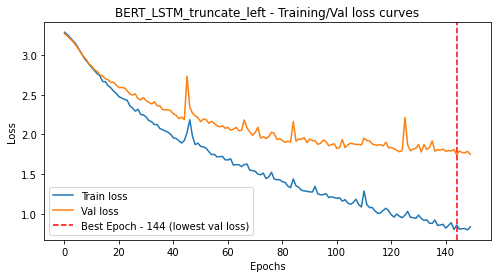

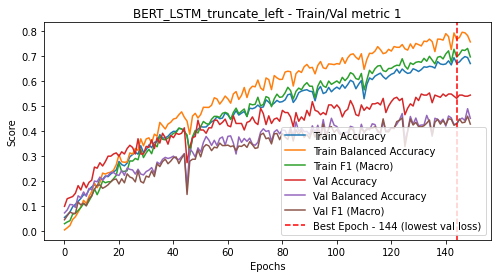

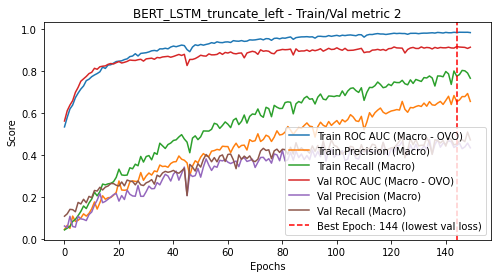

In [49]:
# #Clear memory
# import gc
# torch.cuda.empty_cache()
# gc.collect()

# #Begin training
# results = custom_train_val_loop.train_model(model = model,
#                       train_dataloader = train_dataloader,
#                       val_dataloader = val_dataloader,
#                       optimizer = optimizer,
#                       loss_fn = loss_fn,
#                       device = device,
#                       target_dir = target_dir,
#                       figure_dir = figure_dir,
#                       model_name = model_name,
#                       epochs = epochs)

## Test set evaluation

In [84]:
#instantiate model with the same architecture
loaded_model_1 = BertClassifier(output_shape = output_shape).to(device)

#since I saved many keys in the pth file, I need to specify that I want to load model_state_dict.
loaded_model_1.load_state_dict(torch.load(f = '..\model\BERT_LSTM_truncate_left_best_epoch_144.pth')['model_state_dict'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Inferencing on cuda.


  0%|          | 0/29 [00:00<?, ?it/s]

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\an

                            precision    recall  f1-score   support

                Bariatrics       0.00      0.00      0.00         2
Cardiovascular / Pulmonary       0.70      0.74      0.72        35
Cosmetic / Plastic Surgery       0.00      0.00      0.00         1
                 Dentistry       0.00      0.00      0.00         2
               Dermatology       0.25      0.33      0.29         3
      Diets and Nutritions       0.00      0.00      0.00         1
      ENT - Otolaryngology       0.38      0.33      0.35         9
             Endocrinology       0.00      0.00      0.00         2
          Gastroenterology       0.41      0.35      0.38        20
          General Medicine       0.40      0.30      0.34        20
     Hematology - Oncology       0.14      0.14      0.14         7
                Nephrology       0.27      0.50      0.35         6
                 Neurology       0.54      0.54      0.54        13
              Neurosurgery       0.67      0.50

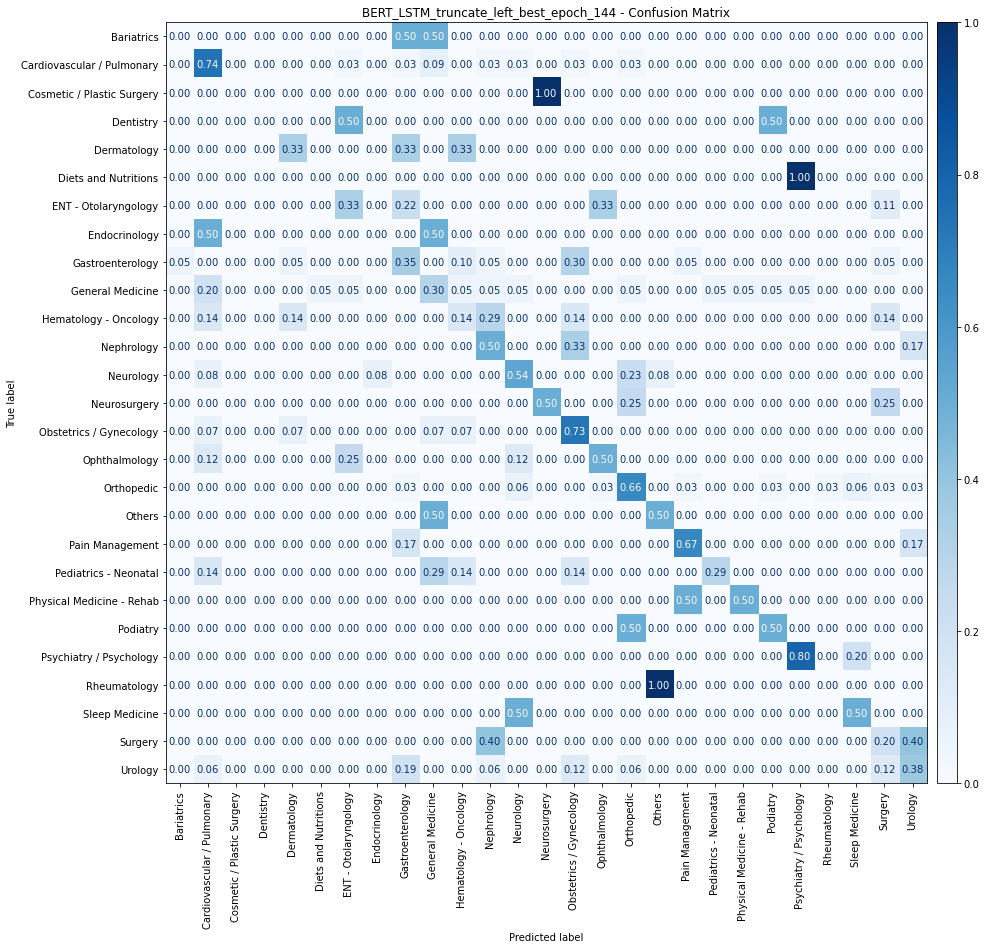

---------------------
Inference time for all test sample (cuda): 3.83 seconds
Number of all sample: 230 samples
Inference time for one sample (cuda): 0.02 seconds
---------------------
Accuracy: 0.50
Balanced accuracy: 0.37
ROC AUC (Macro - OVO): 0.90
Precision (Macro): 0.35
Recall (Macro): 0.37
F1 (Macro): 0.35
---------------------
Saving results dictionary as pickle file at (..\model\BERT_LSTM_truncate_left_best_epoch_144_test_results.pkl)


In [85]:
#initialize parameter
results_dir = '..\model'
figure_dir = '..\image'

results = test_set_evaluation.test_set_report(model = loaded_model_1,
                                              model_file_name = 'BERT_LSTM_truncate_left_best_epoch_144',
                                              results_dir = results_dir,
                                              figure_dir = figure_dir,
                                              test_dataloader = test_dataloader,
                                              class_map = class_number)

# Results Comparison

In [86]:
model_results = []
with open('..\model\BERT_LSTM_base_best_epoch_107_test_results.pkl', 'rb') as f:
    loaded_results_1 = pickle.load(f) 
model_results.append(loaded_results_1)
with open('..\model\BERT_LSTM_truncate_left_best_epoch_144_test_results.pkl', 'rb') as f:
    loaded_results_2 = pickle.load(f)    
model_results.append(loaded_results_2)

In [87]:
columns_name = {'model_name':'Model', 
                'test_f1':'F1', 
                'test_precision':'Precision', 
                'test_recall':'Recall', 
                'test_balanced_accuracy':'Balanced Accuracy', 
                'inference_time_one_sample':'Inference time for 1 sample'}
pd.set_option('display.precision', 3)
pd.DataFrame(model_results, columns = ['model_name', 'test_f1', 'test_precision', 'test_recall', 'test_balanced_accuracy', 'inference_time_one_sample']).rename(columns = columns_name).sort_values('F1', ascending= False)

Model     F1  Precision  Recall  \
0           BERT_LSTM_base_best_epoch_107  0.412      0.417   0.441   
1  BERT_LSTM_truncate_left_best_epoch_144  0.350      0.351   0.369   

   Balanced Accuracy  Inference time for 1 sample  
0              0.441                        0.016  
1              0.369                        0.017

Welp. That did not go as well as expected. Trancation from left resulted in substantially worse performance. Perhaps Most of the information is at the head of the transcription. Nevertheless, from the loss curve, it would appear that training longer might still be beneficial but I limit myself to 150 epoch in this case.

# Model 3: BERT_bidirectional_LSTM

The LSTM used in the last 2 models was unidirectional. In [2005, Graves](https://www.cs.toronto.edu/~graves/ijcnn_2005.pdf) presented bidirectional LSTM (BLSTM) network. In contrast to unidirectional LSTM, bidirectional LSTM process the sequence in two direction, forward and backward, allowing the model to capture information from both the past and present. As noted by the author, this seems to violate casuality but the behavior is much like how we, human, analyse information. When we are reading, information presented in the current, or next, passage can helps elucidate previous information from the previous passage. In practice, this effectively double the amount of hidden neuron of the LSTM. BLSTM beat LSTM in the phenome classification task from audio in the TIMIT database by 3% in the paper. <br> <br>
![](..\image\bidirectional_LSTM.png)

We will try applying BLSTM to our medical transcription task.

## Tokenization

Since in our last experiment, trauncation from left did not yield good results, we revert to default truncation.

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #the cased model is note case-sensitive

#Testing word tokenizer
example_text = "This is a test for BERT tokenizer with maximum 64 token and truncation left."
bert_input = tokenizer(example_text,padding='max_length', max_length = 64, 
                       truncation=True, return_tensors="pt")

print(example_text)
print('\nTokenized text')
print(tokenizer.convert_ids_to_tokens(bert_input['input_ids'][0]))

print('\ninput_ids')
print(bert_input['input_ids'])
print('\ntoken_type_ids')
print(bert_input['token_type_ids'])
print('\nattention_mask')
print(bert_input['attention_mask'])
print('-----------------------------------------------------------------------------')

#Testing word tokenizer
print('This is a test for BERT tokenizer with random sample from x_train with maximum 512 token truncation left due to BERT limitation.')
example_text = str(x_train.sample(1).values)

bert_input = tokenizer(example_text,padding='max_length', max_length = 512, 
                       truncation=True, return_tensors="pt")

print(example_text)
print('\nTokenized text')
print(tokenizer.convert_ids_to_tokens(bert_input['input_ids'][0]))

print('\ninput_ids')
print(bert_input['input_ids'])
print('\ntoken_type_ids')
print(bert_input['token_type_ids'])
print('\nattention_mask')
print(bert_input['attention_mask'])
print('-----------------------------------------------------------------------------')

This is a test for BERT tokenizer with maximum 64 token and truncation left.

Tokenized text
['[CLS]', 'this', 'is', 'a', 'test', 'for', 'bert', 'token', '##izer', 'with', 'maximum', '64', 'token', 'and', 'tr', '##un', '##cation', 'left', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

input_ids
tensor([[  101,  2023,  2003,  1037,  3231,  2005, 14324, 19204, 17629,  2007,
          4555,  4185, 19204,  1998, 19817,  4609, 10719,  2187,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,  

In [42]:
set_custom_seed.set_seed(50)

#instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader = data_setup.create_dataloaders(x_train=x_train,
                                                                                    y_train = y_train,                
                                                                                    x_val= x_val,
                                                                                    y_val = y_val,
                                                                                    x_test = x_test,
                                                                                    y_test = y_test,
                                                                                    tokenizer = tokenizer,
                                                                                    max_length = 512, #BERT maximum length               
                                                                                    batch_size=8,
                                                                                    device = device
                                                                                    ) 

In [43]:
#Count the number of batch
print(f'Number of batches in train set:{len(train_dataloader)}')
print(f'Number of batches in val set:{len(val_dataloader)}')
print(f'Number of batches in test set:{len(test_dataloader)}')

#Getting a random sample from the training set
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random tokenized text from train data at index {random_number}')
single_text_embedding = train_data[random_number][0]
print(f'Dimension of a tokenized text (input Ids): {train_data[random_number][0].input_ids.size()}')
print(f'Data type: {train_data[random_number][0].input_ids.dtype}')
print(f'Label of data: {train_data[random_number][1]}')
print(f'Original tokenized text is:{tokenizer.convert_ids_to_tokens(train_data[random_number][0].input_ids.flatten())}')
print('The output from tokenizer is:')
print(single_text_embedding)

Number of batches in train set:229
Number of batches in val set:29
Number of batches in test set:29

Getting random tokenized text from train data at index 1712
Dimension of a tokenized text (input Ids): torch.Size([1, 512])
Data type: torch.int64
Label of data: 22
Original tokenized text is:['[CLS]', 'history', 'of', 'present', 'illness', ':', ',', 'the', 'patient', 'is', 'a', '69', '-', 'year', '-', 'old', 'single', 'caucasian', 'female', 'with', 'a', 'past', 'medical', 'history', 'of', 'sc', '##hi', '##zo', '##af', '##fect', '##ive', 'disorder', ',', 'diabetes', ',', 'os', '##te', '##oa', '##rth', '##rit', '##is', ',', 'h', '##yp', '##oth', '##yr', '##oid', '##ism', ',', 'ge', '##rd', ',', 'and', 'd', '##ys', '##lip', '##ide', '##mia', 'who', 'presents', 'to', 'the', 'emergency', 'room', 'with', 'the', 'complaint', 'of', '"', 'mani', '##c', '"', 'symptoms', 'due', 'to', 'recent', 'medication', 'adjustments', '.', 'the', 'patient', 'had', 'been', 'admitted', 'to', 'st', '.', 'luke', 

## Model Building

In [44]:
bert = BertModel.from_pretrained('bert-base-uncased')
output_shape = len(class_number) #Use number of class as output shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This time, we are going to set bidirectional = True.

In [58]:
class BertClassifier(nn.Module):

    def __init__(self, output_shape, hidden_dim=50, num_layers=1, dropout=0.5, bidirectional=False):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #get the size of embedding from BERT
        embedding_dim = self.bert.config.hidden_size
        
        #define LSTM
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True, 
                            dropout=0 if num_layers < 2 else dropout)    
                            
        # If the LSTM is bidirectional, it will have 2*hidden_dim units. 
        self.dropout = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        #define lienar layer
        self.linear = nn.Linear(lstm_output_dim, output_shape) 



    def forward(self, input_id, mask):
        
        # Feed input to BERT
        outputs = self.bert(input_ids= input_id, attention_mask=mask, return_dict=True)  
        
        # Feed BERT's output to the LSTM layer
        lstm_output, _ = self.lstm(outputs.last_hidden_state)  
        #When bidirectional=True, output will contain a concatenation of the forward and reverse hidden states at each time step in the sequence.
        final_output = lstm_output[:,-1,:]        

        # Pass the final output through dropout and the linear layer
        return self.linear(self.dropout(final_output))
    
#Instantiate model    
model_2 = BertClassifier(output_shape = output_shape, bidirectional=True).to(device) #don't forget to send to device 

#See model summary with torchinfo
#do a test pass through of an example inout data
#Bert expect two input, (input_ids, attention_mask) from the tokenizer like this: model_0(input_ids, attention_mask)
example_input_ids = torch.randint(0, 100, (1, 512)).to(device)
example_attention_mask = torch.ones((1, 512)).to(device)
summary(model_2, input_data=[example_input_ids, example_attention_mask], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the 

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
BertClassifier                                          --                        [1, 512]                  [1, 27]                   --                        --                        True
├─BertModel: 1-1                                        --                        --                        [1, 768]                  --                        --                        True
│    └─BertEmbeddings: 2-1                              --                        --                        [1, 512, 768]             --                        --                        True
│    │    └─Embedding: 3-1                              --                        [1, 512]                  [1, 512, 768]             23,440,896                23,440,896                True
│    │    └─Embedding: 3-2              

You can see that the output of LSTM has been increased from 50 -> 100 as it multiplies the hidden unit by 2. The total params is also increased.

In [46]:
# Freeze all parameters
for param in model_2.parameters():
    param.requires_grad = False

#Unfrozen only the LSTM and linear layer
for param in model_2.linear.parameters():
    param.requires_grad = True
for param in model_2.lstm.parameters():
    param.requires_grad = True    
    
#Print model summary after freezing layers
summary(model_2, input_data=[example_input_ids, example_attention_mask], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
BertClassifier                                          --                        [1, 512]                  [1, 27]                   --                        --                        Partial
├─BertModel: 1-1                                        --                        --                        [1, 768]                  --                        --                        False
│    └─BertEmbeddings: 2-1                              --                        --                        [1, 512, 768]             --                        --                        False
│    │    └─Embedding: 3-1                              --                        [1, 512]                  [1, 512, 768]             (23,440,896)              23,440,896                False
│    │    └─Embedding: 3-2        

In [47]:
#Testing the model on a single training data
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random embedding from train data at index {random_number}')
single_text_embedding = train_data[random_number][0]
print(f'Dimension of an embedding (input Ids): {train_data[random_number][0].input_ids.size()}')
print(f'Data type: {train_data[random_number][0].input_ids.dtype}')
print(f'Original tokenized text is:{tokenizer.convert_ids_to_tokens(train_data[random_number][0].input_ids.flatten())}')

# Perform a forward pass on a single image
model_2.eval() #set to eval
train_data[random_number][0].to(device)
with torch.inference_mode(): #set to inference mode
    sample_pred_logit = model_2(train_data[random_number][0].input_ids, train_data[random_number][0].attention_mask)   #predict the image on GPU

sample_pred_prob = torch.softmax(sample_pred_logit, dim = 1) #use softmax for multiclass classification to convert logit into prob
sample_pred_class = torch.argmax(sample_pred_prob, dim=1) #use argmax to find the index with the largest probability and use that as the class label
    
# Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{sample_pred_logit}\n") #Print the logit
print(f"Output prediction probabilities:\n{sample_pred_prob}\n") #Print the probability for each class
print(f"Output prediction label:\n{sample_pred_class}\n") #Select the maximum probability as predicted label.
print(f"Actual label:\n{train_data[random_number][1]}") #Get the actual label.

  


Getting random embedding from train data at index 1504
Dimension of an embedding (input Ids): torch.Size([1, 512])
Data type: torch.int64
Original tokenized text is:['[CLS]', 'pre', '##oper', '##ative', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'post', '##pro', '##ced', '##ure', 'diagnosis', ':', ',', 'wo', '##rri', '##some', 'skin', 'les', '##ion', ',', 'left', 'hand', '.', ',', 'procedure', ':', ',', 'the', 'patient', 'gave', 'informed', 'consent', 'for', 'his', 'procedure', '.', 'after', 'informed', 'consent', 'was', 'obtained', ',', 'attention', 'was', 'turned', 'toward', 'the', 'area', 'of', 'interest', ',', 'which', 'was', 'prep', '##ped', 'and', 'draped', 'in', 'the', 'usual', 'sterile', 'fashion', '.', ',', 'local', 'an', '##est', '##hetic', 'medication', 'was', 'infiltrate', '##d', 'around', 'and', 'into', 'the', 'area', 'of', 'interest', '.', 'there', 'was', 'an', 'obvious', 'skin', 'les', '##ion', 'there', 'and', 

## Training loop - do not run if do not want to train again.

In [48]:
# #define Loss function
# loss_fn = nn.CrossEntropyLoss(weight = class_weights.to(device))
# #define optimizer
# optimizer = torch.optim.Adam(model_2.parameters(), lr= 1e-4)
# # Set the seed 
# set_custom_seed.set_seed(50)

# #initialize parameter for custom train loop module
# model = model_2
# train_dataloader = train_dataloader
# val_dataloader = val_dataloader
# optimizer = optimizer
# loss_fn = loss_fn
# device = device
# target_dir = '..\model'
# figure_dir = '..\image'
# model_name = 'BERT_LSTM_bidirectional'
# epochs = 150

Training on cuda.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.29958 | Val loss: 3.26249
Train accuracy: 0.03330 | Train balanced accuracy: 0.00089 | Train F1 score: 0.02266 | Train ROC AUC score: 0.51660
Validation accuracy: 0.07826 | Validation balanced accuracy: 0.05298 | Validation F1 score: 0.05502 | Val ROC AUC score: 0.58298

Epoch: 1
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.26440 | Val loss: 3.21986
Train accuracy: 0.06496 | Train balanced accuracy: 0.02302 | Train F1 score: 0.03990 | Train ROC AUC score: 0.55911
Validation accuracy: 0.11739 | Validation balanced accuracy: 0.06470 | Validation F1 score: 0.05998 | Val ROC AUC score: 0.64761

Epoch: 2
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.21413 | Val loss: 3.17849
Train accuracy: 0.10317 | Train balanced accuracy: 0.04675 | Train F1 score: 0.06042 | Train ROC AUC score: 0.61327
Validation accuracy: 0.15217 | Validation balanced accuracy: 0.08749 | Validation F1 score: 0.07149 | Val ROC AUC score: 0.67206

Epoch: 3
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.16071 | Val loss: 3.13182
Train accuracy: 0.12391 | Train balanced accuracy: 0.06515 | Train F1 score: 0.07317 | Train ROC AUC score: 0.65824
Validation accuracy: 0.14348 | Validation balanced accuracy: 0.07707 | Validation F1 score: 0.06468 | Val ROC AUC score: 0.69558

Epoch: 4
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.12272 | Val loss: 3.09354
Train accuracy: 0.13974 | Train balanced accuracy: 0.07711 | Train F1 score: 0.09065 | Train ROC AUC score: 0.67980
Validation accuracy: 0.15652 | Validation balanced accuracy: 0.08422 | Validation F1 score: 0.06517 | Val ROC AUC score: 0.70689

Epoch: 5
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 3.05040 | Val loss: 3.03499
Train accuracy: 0.15120 | Train balanced accuracy: 0.10295 | Train F1 score: 0.11482 | Train ROC AUC score: 0.72153
Validation accuracy: 0.18696 | Validation balanced accuracy: 0.10063 | Validation F1 score: 0.07798 | Val ROC AUC score: 0.72761

Epoch: 6
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.98892 | Val loss: 2.99391
Train accuracy: 0.16921 | Train balanced accuracy: 0.11258 | Train F1 score: 0.12113 | Train ROC AUC score: 0.73999
Validation accuracy: 0.17826 | Validation balanced accuracy: 0.12092 | Validation F1 score: 0.09289 | Val ROC AUC score: 0.74103

Epoch: 7
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.94618 | Val loss: 2.95578
Train accuracy: 0.15775 | Train balanced accuracy: 0.12215 | Train F1 score: 0.11378 | Train ROC AUC score: 0.74592
Validation accuracy: 0.17826 | Validation balanced accuracy: 0.14458 | Validation F1 score: 0.11691 | Val ROC AUC score: 0.75152

Epoch: 8
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.88372 | Val loss: 2.90276
Train accuracy: 0.16266 | Train balanced accuracy: 0.13453 | Train F1 score: 0.12991 | Train ROC AUC score: 0.76953
Validation accuracy: 0.23478 | Validation balanced accuracy: 0.16618 | Validation F1 score: 0.13716 | Val ROC AUC score: 0.76732

Epoch: 9
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.86440 | Val loss: 2.87667
Train accuracy: 0.17849 | Train balanced accuracy: 0.12643 | Train F1 score: 0.12228 | Train ROC AUC score: 0.76716
Validation accuracy: 0.24348 | Validation balanced accuracy: 0.19003 | Validation F1 score: 0.17758 | Val ROC AUC score: 0.76633

Epoch: 10
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.80732 | Val loss: 2.83762
Train accuracy: 0.18777 | Train balanced accuracy: 0.16487 | Train F1 score: 0.16295 | Train ROC AUC score: 0.78392
Validation accuracy: 0.26957 | Validation balanced accuracy: 0.19871 | Validation F1 score: 0.17748 | Val ROC AUC score: 0.77818

Epoch: 11
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.76572 | Val loss: 2.82079
Train accuracy: 0.20415 | Train balanced accuracy: 0.17061 | Train F1 score: 0.16364 | Train ROC AUC score: 0.79242
Validation accuracy: 0.27826 | Validation balanced accuracy: 0.19541 | Validation F1 score: 0.17558 | Val ROC AUC score: 0.77148

Epoch: 12
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.72511 | Val loss: 2.78066
Train accuracy: 0.21779 | Train balanced accuracy: 0.19211 | Train F1 score: 0.17983 | Train ROC AUC score: 0.79799
Validation accuracy: 0.29130 | Validation balanced accuracy: 0.24062 | Validation F1 score: 0.20133 | Val ROC AUC score: 0.78152

Epoch: 13
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.68877 | Val loss: 2.83121
Train accuracy: 0.23144 | Train balanced accuracy: 0.22369 | Train F1 score: 0.20622 | Train ROC AUC score: 0.80970
Validation accuracy: 0.23043 | Validation balanced accuracy: 0.18888 | Validation F1 score: 0.16034 | Val ROC AUC score: 0.76287

Epoch: 14
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.68618 | Val loss: 2.75781
Train accuracy: 0.22544 | Train balanced accuracy: 0.20294 | Train F1 score: 0.18748 | Train ROC AUC score: 0.80722
Validation accuracy: 0.26522 | Validation balanced accuracy: 0.23739 | Validation F1 score: 0.19777 | Val ROC AUC score: 0.77616

Epoch: 15
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.61758 | Val loss: 2.72877
Train accuracy: 0.25382 | Train balanced accuracy: 0.23255 | Train F1 score: 0.21497 | Train ROC AUC score: 0.82232
Validation accuracy: 0.28696 | Validation balanced accuracy: 0.21028 | Validation F1 score: 0.18995 | Val ROC AUC score: 0.78092

Epoch: 16
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.57648 | Val loss: 2.70053
Train accuracy: 0.25819 | Train balanced accuracy: 0.22956 | Train F1 score: 0.20302 | Train ROC AUC score: 0.83126
Validation accuracy: 0.30870 | Validation balanced accuracy: 0.26921 | Validation F1 score: 0.21826 | Val ROC AUC score: 0.79077

Epoch: 17
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.57110 | Val loss: 2.68183
Train accuracy: 0.24509 | Train balanced accuracy: 0.24311 | Train F1 score: 0.21430 | Train ROC AUC score: 0.82961
Validation accuracy: 0.30870 | Validation balanced accuracy: 0.25069 | Validation F1 score: 0.22197 | Val ROC AUC score: 0.79737

Epoch: 18
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.51228 | Val loss: 2.66731
Train accuracy: 0.27784 | Train balanced accuracy: 0.28114 | Train F1 score: 0.25380 | Train ROC AUC score: 0.84471
Validation accuracy: 0.31739 | Validation balanced accuracy: 0.26345 | Validation F1 score: 0.22776 | Val ROC AUC score: 0.79087

Epoch: 19
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.48082 | Val loss: 2.64349
Train accuracy: 0.27456 | Train balanced accuracy: 0.26773 | Train F1 score: 0.23549 | Train ROC AUC score: 0.84440
Validation accuracy: 0.34348 | Validation balanced accuracy: 0.26316 | Validation F1 score: 0.23122 | Val ROC AUC score: 0.79955

Epoch: 20
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.42666 | Val loss: 2.60454
Train accuracy: 0.30240 | Train balanced accuracy: 0.27828 | Train F1 score: 0.25220 | Train ROC AUC score: 0.85570
Validation accuracy: 0.33478 | Validation balanced accuracy: 0.27474 | Validation F1 score: 0.24164 | Val ROC AUC score: 0.80724

Epoch: 21
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.38748 | Val loss: 2.56135
Train accuracy: 0.31332 | Train balanced accuracy: 0.29569 | Train F1 score: 0.26653 | Train ROC AUC score: 0.86292
Validation accuracy: 0.36087 | Validation balanced accuracy: 0.33060 | Validation F1 score: 0.27069 | Val ROC AUC score: 0.81990

Epoch: 22
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.37398 | Val loss: 2.71163
Train accuracy: 0.32205 | Train balanced accuracy: 0.31379 | Train F1 score: 0.27215 | Train ROC AUC score: 0.86108
Validation accuracy: 0.26087 | Validation balanced accuracy: 0.21346 | Validation F1 score: 0.18725 | Val ROC AUC score: 0.79257

Epoch: 23
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.40399 | Val loss: 2.56251
Train accuracy: 0.27238 | Train balanced accuracy: 0.27965 | Train F1 score: 0.24176 | Train ROC AUC score: 0.85532
Validation accuracy: 0.35217 | Validation balanced accuracy: 0.35268 | Validation F1 score: 0.28780 | Val ROC AUC score: 0.81142

Epoch: 24
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.32544 | Val loss: 2.56909
Train accuracy: 0.31332 | Train balanced accuracy: 0.31717 | Train F1 score: 0.28145 | Train ROC AUC score: 0.87462
Validation accuracy: 0.34783 | Validation balanced accuracy: 0.33010 | Validation F1 score: 0.28496 | Val ROC AUC score: 0.80015

Epoch: 25
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.31220 | Val loss: 2.48975
Train accuracy: 0.31714 | Train balanced accuracy: 0.31483 | Train F1 score: 0.28689 | Train ROC AUC score: 0.87569
Validation accuracy: 0.33913 | Validation balanced accuracy: 0.35391 | Validation F1 score: 0.28364 | Val ROC AUC score: 0.83005

Epoch: 26
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.27249 | Val loss: 2.51501
Train accuracy: 0.33133 | Train balanced accuracy: 0.33362 | Train F1 score: 0.29133 | Train ROC AUC score: 0.87905
Validation accuracy: 0.33478 | Validation balanced accuracy: 0.29728 | Validation F1 score: 0.25026 | Val ROC AUC score: 0.81619

Epoch: 27
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.23238 | Val loss: 2.47018
Train accuracy: 0.32424 | Train balanced accuracy: 0.32130 | Train F1 score: 0.29172 | Train ROC AUC score: 0.88607
Validation accuracy: 0.40435 | Validation balanced accuracy: 0.34504 | Validation F1 score: 0.30903 | Val ROC AUC score: 0.82515

Epoch: 28
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.16869 | Val loss: 2.45917
Train accuracy: 0.36190 | Train balanced accuracy: 0.35533 | Train F1 score: 0.31174 | Train ROC AUC score: 0.89211
Validation accuracy: 0.38696 | Validation balanced accuracy: 0.34084 | Validation F1 score: 0.29019 | Val ROC AUC score: 0.82876

Epoch: 29
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.18432 | Val loss: 2.43672
Train accuracy: 0.35535 | Train balanced accuracy: 0.35816 | Train F1 score: 0.32019 | Train ROC AUC score: 0.88591
Validation accuracy: 0.38261 | Validation balanced accuracy: 0.37597 | Validation F1 score: 0.29239 | Val ROC AUC score: 0.83819

Epoch: 30
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.18411 | Val loss: 2.42719
Train accuracy: 0.33679 | Train balanced accuracy: 0.34893 | Train F1 score: 0.30859 | Train ROC AUC score: 0.88692
Validation accuracy: 0.37826 | Validation balanced accuracy: 0.35853 | Validation F1 score: 0.29141 | Val ROC AUC score: 0.84295

Epoch: 31
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.15153 | Val loss: 2.44034
Train accuracy: 0.33734 | Train balanced accuracy: 0.35941 | Train F1 score: 0.30612 | Train ROC AUC score: 0.89384
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.36485 | Validation F1 score: 0.31630 | Val ROC AUC score: 0.82950

Epoch: 32
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.08866 | Val loss: 2.39920
Train accuracy: 0.38592 | Train balanced accuracy: 0.38056 | Train F1 score: 0.33407 | Train ROC AUC score: 0.90361
Validation accuracy: 0.37826 | Validation balanced accuracy: 0.37713 | Validation F1 score: 0.29661 | Val ROC AUC score: 0.84761

Epoch: 33
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.17983 | Val loss: 2.41346
Train accuracy: 0.34607 | Train balanced accuracy: 0.37223 | Train F1 score: 0.32325 | Train ROC AUC score: 0.88747
Validation accuracy: 0.36522 | Validation balanced accuracy: 0.36388 | Validation F1 score: 0.28525 | Val ROC AUC score: 0.83543

Epoch: 34
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.16396 | Val loss: 2.39536
Train accuracy: 0.35590 | Train balanced accuracy: 0.39364 | Train F1 score: 0.34189 | Train ROC AUC score: 0.88900
Validation accuracy: 0.38261 | Validation balanced accuracy: 0.36895 | Validation F1 score: 0.30115 | Val ROC AUC score: 0.83579

Epoch: 35
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.08765 | Val loss: 2.38287
Train accuracy: 0.36299 | Train balanced accuracy: 0.39486 | Train F1 score: 0.34384 | Train ROC AUC score: 0.89963
Validation accuracy: 0.37391 | Validation balanced accuracy: 0.37845 | Validation F1 score: 0.29987 | Val ROC AUC score: 0.84228

Epoch: 36
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.06741 | Val loss: 2.35572
Train accuracy: 0.36463 | Train balanced accuracy: 0.39470 | Train F1 score: 0.34488 | Train ROC AUC score: 0.90032
Validation accuracy: 0.39565 | Validation balanced accuracy: 0.36773 | Validation F1 score: 0.30377 | Val ROC AUC score: 0.84848

Epoch: 37
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 2.00318 | Val loss: 2.35936
Train accuracy: 0.38428 | Train balanced accuracy: 0.41850 | Train F1 score: 0.37117 | Train ROC AUC score: 0.90825
Validation accuracy: 0.40435 | Validation balanced accuracy: 0.38594 | Validation F1 score: 0.32588 | Val ROC AUC score: 0.84724

Epoch: 38
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.99033 | Val loss: 2.35534
Train accuracy: 0.38810 | Train balanced accuracy: 0.41731 | Train F1 score: 0.37526 | Train ROC AUC score: 0.91114
Validation accuracy: 0.40870 | Validation balanced accuracy: 0.36446 | Validation F1 score: 0.31627 | Val ROC AUC score: 0.83877

Epoch: 39
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.94839 | Val loss: 2.32409
Train accuracy: 0.41539 | Train balanced accuracy: 0.44617 | Train F1 score: 0.39115 | Train ROC AUC score: 0.91561
Validation accuracy: 0.40870 | Validation balanced accuracy: 0.36434 | Validation F1 score: 0.32108 | Val ROC AUC score: 0.84442

Epoch: 40
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.94467 | Val loss: 2.31978
Train accuracy: 0.39956 | Train balanced accuracy: 0.43872 | Train F1 score: 0.38443 | Train ROC AUC score: 0.91510
Validation accuracy: 0.39130 | Validation balanced accuracy: 0.36382 | Validation F1 score: 0.31476 | Val ROC AUC score: 0.84506

Epoch: 41
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.89648 | Val loss: 2.30513
Train accuracy: 0.41648 | Train balanced accuracy: 0.44926 | Train F1 score: 0.39858 | Train ROC AUC score: 0.92043
Validation accuracy: 0.38696 | Validation balanced accuracy: 0.37373 | Validation F1 score: 0.31133 | Val ROC AUC score: 0.85298

Epoch: 42
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.93361 | Val loss: 2.38222
Train accuracy: 0.39410 | Train balanced accuracy: 0.43435 | Train F1 score: 0.38249 | Train ROC AUC score: 0.91044
Validation accuracy: 0.39130 | Validation balanced accuracy: 0.36853 | Validation F1 score: 0.31864 | Val ROC AUC score: 0.84370

Epoch: 43
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.88920 | Val loss: 2.26681
Train accuracy: 0.41594 | Train balanced accuracy: 0.45144 | Train F1 score: 0.40117 | Train ROC AUC score: 0.91831
Validation accuracy: 0.44783 | Validation balanced accuracy: 0.40698 | Validation F1 score: 0.34843 | Val ROC AUC score: 0.85137

Epoch: 44
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.82039 | Val loss: 2.25300
Train accuracy: 0.44323 | Train balanced accuracy: 0.48596 | Train F1 score: 0.43559 | Train ROC AUC score: 0.92565
Validation accuracy: 0.43043 | Validation balanced accuracy: 0.39629 | Validation F1 score: 0.33331 | Val ROC AUC score: 0.84686

Epoch: 45
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.80525 | Val loss: 2.25644
Train accuracy: 0.43886 | Train balanced accuracy: 0.46787 | Train F1 score: 0.43008 | Train ROC AUC score: 0.92869
Validation accuracy: 0.46087 | Validation balanced accuracy: 0.41904 | Validation F1 score: 0.36225 | Val ROC AUC score: 0.84819

Epoch: 46
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.83031 | Val loss: 2.24290
Train accuracy: 0.40939 | Train balanced accuracy: 0.45367 | Train F1 score: 0.40254 | Train ROC AUC score: 0.92482
Validation accuracy: 0.42174 | Validation balanced accuracy: 0.40556 | Validation F1 score: 0.33370 | Val ROC AUC score: 0.84906

Epoch: 47
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.77495 | Val loss: 2.21067
Train accuracy: 0.43996 | Train balanced accuracy: 0.48694 | Train F1 score: 0.43936 | Train ROC AUC score: 0.93010
Validation accuracy: 0.43913 | Validation balanced accuracy: 0.38448 | Validation F1 score: 0.33991 | Val ROC AUC score: 0.85486

Epoch: 48
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.75916 | Val loss: 2.18670
Train accuracy: 0.44651 | Train balanced accuracy: 0.46689 | Train F1 score: 0.41766 | Train ROC AUC score: 0.93318
Validation accuracy: 0.41739 | Validation balanced accuracy: 0.39029 | Validation F1 score: 0.33623 | Val ROC AUC score: 0.87082

Epoch: 49
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.69688 | Val loss: 2.25168
Train accuracy: 0.46179 | Train balanced accuracy: 0.51817 | Train F1 score: 0.46897 | Train ROC AUC score: 0.93861
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.40379 | Validation F1 score: 0.35958 | Val ROC AUC score: 0.85634

Epoch: 50
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.78004 | Val loss: 2.22643
Train accuracy: 0.44651 | Train balanced accuracy: 0.46050 | Train F1 score: 0.42122 | Train ROC AUC score: 0.92817
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.41465 | Validation F1 score: 0.35264 | Val ROC AUC score: 0.85933

Epoch: 51
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.70883 | Val loss: 2.21100
Train accuracy: 0.46616 | Train balanced accuracy: 0.48767 | Train F1 score: 0.43850 | Train ROC AUC score: 0.93529
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.42136 | Validation F1 score: 0.35433 | Val ROC AUC score: 0.85850

Epoch: 52
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.66492 | Val loss: 2.23773
Train accuracy: 0.46452 | Train balanced accuracy: 0.50345 | Train F1 score: 0.46354 | Train ROC AUC score: 0.94094
Validation accuracy: 0.42609 | Validation balanced accuracy: 0.40421 | Validation F1 score: 0.33071 | Val ROC AUC score: 0.85876

Epoch: 53
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.68347 | Val loss: 2.17195
Train accuracy: 0.45251 | Train balanced accuracy: 0.48597 | Train F1 score: 0.43172 | Train ROC AUC score: 0.93652
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.39062 | Validation F1 score: 0.34399 | Val ROC AUC score: 0.86039

Epoch: 54
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.69302 | Val loss: 2.22745
Train accuracy: 0.45524 | Train balanced accuracy: 0.51298 | Train F1 score: 0.44598 | Train ROC AUC score: 0.93393
Validation accuracy: 0.42174 | Validation balanced accuracy: 0.37585 | Validation F1 score: 0.32375 | Val ROC AUC score: 0.85262

Epoch: 55
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.62633 | Val loss: 2.19797
Train accuracy: 0.46507 | Train balanced accuracy: 0.52104 | Train F1 score: 0.45359 | Train ROC AUC score: 0.94271
Validation accuracy: 0.43913 | Validation balanced accuracy: 0.40175 | Validation F1 score: 0.35822 | Val ROC AUC score: 0.85897

Epoch: 56
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.68080 | Val loss: 2.21235
Train accuracy: 0.45415 | Train balanced accuracy: 0.51566 | Train F1 score: 0.46416 | Train ROC AUC score: 0.93667
Validation accuracy: 0.45217 | Validation balanced accuracy: 0.42438 | Validation F1 score: 0.36992 | Val ROC AUC score: 0.85351

Epoch: 57
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.72692 | Val loss: 2.19264
Train accuracy: 0.42904 | Train balanced accuracy: 0.50599 | Train F1 score: 0.42683 | Train ROC AUC score: 0.93111
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.42670 | Validation F1 score: 0.40646 | Val ROC AUC score: 0.85656

Epoch: 58
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.61648 | Val loss: 2.16835
Train accuracy: 0.48253 | Train balanced accuracy: 0.53069 | Train F1 score: 0.47724 | Train ROC AUC score: 0.94203
Validation accuracy: 0.46087 | Validation balanced accuracy: 0.41306 | Validation F1 score: 0.37943 | Val ROC AUC score: 0.85704

Epoch: 59
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.56364 | Val loss: 2.14118
Train accuracy: 0.50382 | Train balanced accuracy: 0.56557 | Train F1 score: 0.50372 | Train ROC AUC score: 0.94728
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.38606 | Validation F1 score: 0.35779 | Val ROC AUC score: 0.86794

Epoch: 60
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.59186 | Val loss: 2.16872
Train accuracy: 0.46725 | Train balanced accuracy: 0.54129 | Train F1 score: 0.47387 | Train ROC AUC score: 0.94616
Validation accuracy: 0.43478 | Validation balanced accuracy: 0.38595 | Validation F1 score: 0.35267 | Val ROC AUC score: 0.85898

Epoch: 61
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.50913 | Val loss: 2.10121
Train accuracy: 0.50819 | Train balanced accuracy: 0.56926 | Train F1 score: 0.51085 | Train ROC AUC score: 0.94949
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.40083 | Validation F1 score: 0.36391 | Val ROC AUC score: 0.87355

Epoch: 62
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.52066 | Val loss: 2.18640
Train accuracy: 0.49891 | Train balanced accuracy: 0.54846 | Train F1 score: 0.49027 | Train ROC AUC score: 0.95003
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.36758 | Validation F1 score: 0.33017 | Val ROC AUC score: 0.86572

Epoch: 63
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.49393 | Val loss: 2.11136
Train accuracy: 0.50000 | Train balanced accuracy: 0.56851 | Train F1 score: 0.49497 | Train ROC AUC score: 0.95083
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.43314 | Validation F1 score: 0.39300 | Val ROC AUC score: 0.87015

Epoch: 64
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.47532 | Val loss: 2.12785
Train accuracy: 0.51965 | Train balanced accuracy: 0.58230 | Train F1 score: 0.51535 | Train ROC AUC score: 0.95239
Validation accuracy: 0.46087 | Validation balanced accuracy: 0.40755 | Validation F1 score: 0.38429 | Val ROC AUC score: 0.86358

Epoch: 65
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.50437 | Val loss: 2.10957
Train accuracy: 0.50600 | Train balanced accuracy: 0.57502 | Train F1 score: 0.51282 | Train ROC AUC score: 0.94867
Validation accuracy: 0.44348 | Validation balanced accuracy: 0.39646 | Validation F1 score: 0.34417 | Val ROC AUC score: 0.87438

Epoch: 66
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.45475 | Val loss: 2.06730
Train accuracy: 0.53603 | Train balanced accuracy: 0.59822 | Train F1 score: 0.53485 | Train ROC AUC score: 0.95412
Validation accuracy: 0.45652 | Validation balanced accuracy: 0.40460 | Validation F1 score: 0.36848 | Val ROC AUC score: 0.87304

Epoch: 67
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.46393 | Val loss: 2.07047
Train accuracy: 0.51583 | Train balanced accuracy: 0.59363 | Train F1 score: 0.53357 | Train ROC AUC score: 0.95303
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.46844 | Validation F1 score: 0.41335 | Val ROC AUC score: 0.87372

Epoch: 68
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.45377 | Val loss: 2.03866
Train accuracy: 0.50491 | Train balanced accuracy: 0.58319 | Train F1 score: 0.51112 | Train ROC AUC score: 0.95515
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.44236 | Validation F1 score: 0.38456 | Val ROC AUC score: 0.87453

Epoch: 69
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.39857 | Val loss: 2.04740
Train accuracy: 0.52074 | Train balanced accuracy: 0.61410 | Train F1 score: 0.54376 | Train ROC AUC score: 0.95692
Validation accuracy: 0.45217 | Validation balanced accuracy: 0.42580 | Validation F1 score: 0.37765 | Val ROC AUC score: 0.87357

Epoch: 70
-------
Train loss: 1.41271 | Val loss: 2.01876
Train accuracy: 0.52620 | Train balanced accuracy: 0.59930 | Train F1 score: 0.53966 | Train ROC AUC score: 0.95731
Validation accuracy: 0.47826 | Validation balanced accuracy: 0.45840 | Validation F1 score: 0.41765 | Val ROC AUC score: 0.87161

Epoch: 71
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.37876 | Val loss: 2.04418
Train accuracy: 0.52838 | Train balanced accuracy: 0.60685 | Train F1 score: 0.54501 | Train ROC AUC score: 0.95777
Validation accuracy: 0.48261 | Validation balanced accuracy: 0.43818 | Validation F1 score: 0.37961 | Val ROC AUC score: 0.87529

Epoch: 72
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.36319 | Val loss: 2.01210
Train accuracy: 0.53221 | Train balanced accuracy: 0.62973 | Train F1 score: 0.54638 | Train ROC AUC score: 0.95879
Validation accuracy: 0.50435 | Validation balanced accuracy: 0.48284 | Validation F1 score: 0.43023 | Val ROC AUC score: 0.87649

Epoch: 73
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.33946 | Val loss: 2.00032
Train accuracy: 0.52620 | Train balanced accuracy: 0.61630 | Train F1 score: 0.54540 | Train ROC AUC score: 0.96074
Validation accuracy: 0.50435 | Validation balanced accuracy: 0.48144 | Validation F1 score: 0.43931 | Val ROC AUC score: 0.87933

Epoch: 74
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.38435 | Val loss: 1.99055
Train accuracy: 0.51201 | Train balanced accuracy: 0.57328 | Train F1 score: 0.51878 | Train ROC AUC score: 0.95624
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.47260 | Validation F1 score: 0.44599 | Val ROC AUC score: 0.89347

Epoch: 75
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.30141 | Val loss: 2.04027
Train accuracy: 0.54967 | Train balanced accuracy: 0.63251 | Train F1 score: 0.57128 | Train ROC AUC score: 0.96329
Validation accuracy: 0.51739 | Validation balanced accuracy: 0.48593 | Validation F1 score: 0.44494 | Val ROC AUC score: 0.87730

Epoch: 76
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.30816 | Val loss: 2.01126
Train accuracy: 0.54694 | Train balanced accuracy: 0.60122 | Train F1 score: 0.54405 | Train ROC AUC score: 0.96149
Validation accuracy: 0.48696 | Validation balanced accuracy: 0.46007 | Validation F1 score: 0.43437 | Val ROC AUC score: 0.88424

Epoch: 77
-------
Train loss: 1.29809 | Val loss: 2.14138
Train accuracy: 0.56605 | Train balanced accuracy: 0.65110 | Train F1 score: 0.58252 | Train ROC AUC score: 0.96224
Validation accuracy: 0.47391 | Validation balanced accuracy: 0.43538 | Validation F1 score: 0.39744 | Val ROC AUC score: 0.87065

Epoch: 78
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.26997 | Val loss: 2.06602
Train accuracy: 0.55622 | Train balanced accuracy: 0.63176 | Train F1 score: 0.56512 | Train ROC AUC score: 0.96293
Validation accuracy: 0.48696 | Validation balanced accuracy: 0.46629 | Validation F1 score: 0.42093 | Val ROC AUC score: 0.87025

Epoch: 79
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.26683 | Val loss: 2.11678
Train accuracy: 0.55841 | Train balanced accuracy: 0.66426 | Train F1 score: 0.58915 | Train ROC AUC score: 0.96408
Validation accuracy: 0.47826 | Validation balanced accuracy: 0.42836 | Validation F1 score: 0.39460 | Val ROC AUC score: 0.86677

Epoch: 80
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.37348 | Val loss: 2.01961
Train accuracy: 0.53330 | Train balanced accuracy: 0.61136 | Train F1 score: 0.55015 | Train ROC AUC score: 0.95656
Validation accuracy: 0.46522 | Validation balanced accuracy: 0.46406 | Validation F1 score: 0.41324 | Val ROC AUC score: 0.87952

Epoch: 81
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.32779 | Val loss: 2.04281
Train accuracy: 0.53548 | Train balanced accuracy: 0.61737 | Train F1 score: 0.54897 | Train ROC AUC score: 0.96199
Validation accuracy: 0.50000 | Validation balanced accuracy: 0.45482 | Validation F1 score: 0.42054 | Val ROC AUC score: 0.86055

Epoch: 82
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.23446 | Val loss: 2.01893
Train accuracy: 0.56605 | Train balanced accuracy: 0.65177 | Train F1 score: 0.58945 | Train ROC AUC score: 0.96678
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.48479 | Validation F1 score: 0.43947 | Val ROC AUC score: 0.86239

Epoch: 83
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.28131 | Val loss: 1.98127
Train accuracy: 0.55076 | Train balanced accuracy: 0.63266 | Train F1 score: 0.56304 | Train ROC AUC score: 0.96314
Validation accuracy: 0.51739 | Validation balanced accuracy: 0.48973 | Validation F1 score: 0.46342 | Val ROC AUC score: 0.87700

Epoch: 84
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.23156 | Val loss: 2.01335
Train accuracy: 0.56332 | Train balanced accuracy: 0.64795 | Train F1 score: 0.56997 | Train ROC AUC score: 0.96607
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.46261 | Validation F1 score: 0.45334 | Val ROC AUC score: 0.87081

Epoch: 85
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.17531 | Val loss: 2.03645
Train accuracy: 0.58024 | Train balanced accuracy: 0.68122 | Train F1 score: 0.61195 | Train ROC AUC score: 0.96846
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.45525 | Validation F1 score: 0.44703 | Val ROC AUC score: 0.87190

Epoch: 86
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.19979 | Val loss: 1.95342
Train accuracy: 0.56659 | Train balanced accuracy: 0.65855 | Train F1 score: 0.59874 | Train ROC AUC score: 0.96782
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.51714 | Validation F1 score: 0.47933 | Val ROC AUC score: 0.87999

Epoch: 87
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.15237 | Val loss: 1.99963
Train accuracy: 0.59007 | Train balanced accuracy: 0.67183 | Train F1 score: 0.60763 | Train ROC AUC score: 0.97109
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.45327 | Validation F1 score: 0.43536 | Val ROC AUC score: 0.87559

Epoch: 88
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.15239 | Val loss: 1.99057
Train accuracy: 0.59007 | Train balanced accuracy: 0.67614 | Train F1 score: 0.60984 | Train ROC AUC score: 0.97048
Validation accuracy: 0.50870 | Validation balanced accuracy: 0.45656 | Validation F1 score: 0.42151 | Val ROC AUC score: 0.88209

Epoch: 89
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.11766 | Val loss: 1.99490
Train accuracy: 0.59552 | Train balanced accuracy: 0.70525 | Train F1 score: 0.62659 | Train ROC AUC score: 0.97162
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.46635 | Validation F1 score: 0.44232 | Val ROC AUC score: 0.88568

Epoch: 90
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.13052 | Val loss: 2.06773
Train accuracy: 0.59443 | Train balanced accuracy: 0.68101 | Train F1 score: 0.61507 | Train ROC AUC score: 0.97154
Validation accuracy: 0.52174 | Validation balanced accuracy: 0.45031 | Validation F1 score: 0.43109 | Val ROC AUC score: 0.87398

Epoch: 91
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.09257 | Val loss: 1.99733
Train accuracy: 0.60262 | Train balanced accuracy: 0.69541 | Train F1 score: 0.62988 | Train ROC AUC score: 0.97393
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.52274 | Validation F1 score: 0.48281 | Val ROC AUC score: 0.87742

Epoch: 92
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.10503 | Val loss: 2.01061
Train accuracy: 0.59498 | Train balanced accuracy: 0.69498 | Train F1 score: 0.61659 | Train ROC AUC score: 0.97160
Validation accuracy: 0.51739 | Validation balanced accuracy: 0.46189 | Validation F1 score: 0.44477 | Val ROC AUC score: 0.87254

Epoch: 93
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.09270 | Val loss: 2.01073
Train accuracy: 0.59934 | Train balanced accuracy: 0.70618 | Train F1 score: 0.63349 | Train ROC AUC score: 0.97286
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.47677 | Validation F1 score: 0.46993 | Val ROC AUC score: 0.87667

Epoch: 94
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.09850 | Val loss: 1.99574
Train accuracy: 0.60371 | Train balanced accuracy: 0.68806 | Train F1 score: 0.62794 | Train ROC AUC score: 0.97154
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.47986 | Validation F1 score: 0.46440 | Val ROC AUC score: 0.87392

Epoch: 95
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.06382 | Val loss: 2.00556
Train accuracy: 0.59880 | Train balanced accuracy: 0.69301 | Train F1 score: 0.62911 | Train ROC AUC score: 0.97414
Validation accuracy: 0.52609 | Validation balanced accuracy: 0.47997 | Validation F1 score: 0.43863 | Val ROC AUC score: 0.88549

Epoch: 96
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.08313 | Val loss: 2.04739
Train accuracy: 0.60153 | Train balanced accuracy: 0.70749 | Train F1 score: 0.63085 | Train ROC AUC score: 0.97315
Validation accuracy: 0.50870 | Validation balanced accuracy: 0.45292 | Validation F1 score: 0.42738 | Val ROC AUC score: 0.88230

Epoch: 97
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.08719 | Val loss: 1.95089
Train accuracy: 0.59989 | Train balanced accuracy: 0.69494 | Train F1 score: 0.62292 | Train ROC AUC score: 0.97310
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.46508 | Validation F1 score: 0.44836 | Val ROC AUC score: 0.89664

Epoch: 98
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.05808 | Val loss: 2.05578
Train accuracy: 0.60972 | Train balanced accuracy: 0.70245 | Train F1 score: 0.63369 | Train ROC AUC score: 0.97238
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.46141 | Validation F1 score: 0.44336 | Val ROC AUC score: 0.88150

Epoch: 99
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.04822 | Val loss: 1.97697
Train accuracy: 0.60426 | Train balanced accuracy: 0.69948 | Train F1 score: 0.63238 | Train ROC AUC score: 0.97404
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.49380 | Validation F1 score: 0.47399 | Val ROC AUC score: 0.88426

Epoch: 100
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.02787 | Val loss: 1.98021
Train accuracy: 0.61463 | Train balanced accuracy: 0.71818 | Train F1 score: 0.65129 | Train ROC AUC score: 0.97603
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.46541 | Validation F1 score: 0.44844 | Val ROC AUC score: 0.88398

Epoch: 101
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.11685 | Val loss: 1.96846
Train accuracy: 0.59934 | Train balanced accuracy: 0.69481 | Train F1 score: 0.61872 | Train ROC AUC score: 0.97088
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.51166 | Validation F1 score: 0.45369 | Val ROC AUC score: 0.87706

Epoch: 102
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.04312 | Val loss: 1.99678
Train accuracy: 0.61736 | Train balanced accuracy: 0.71659 | Train F1 score: 0.64378 | Train ROC AUC score: 0.97534
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.49759 | Validation F1 score: 0.46816 | Val ROC AUC score: 0.88465

Epoch: 103
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.02347 | Val loss: 1.99468
Train accuracy: 0.61408 | Train balanced accuracy: 0.72993 | Train F1 score: 0.65890 | Train ROC AUC score: 0.97579
Validation accuracy: 0.51304 | Validation balanced accuracy: 0.45882 | Validation F1 score: 0.41531 | Val ROC AUC score: 0.88992

Epoch: 104
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.16063 | Val loss: 2.04660
Train accuracy: 0.58297 | Train balanced accuracy: 0.67901 | Train F1 score: 0.61011 | Train ROC AUC score: 0.96777
Validation accuracy: 0.49130 | Validation balanced accuracy: 0.46907 | Validation F1 score: 0.43957 | Val ROC AUC score: 0.87096

Epoch: 105
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.19722 | Val loss: 2.00618
Train accuracy: 0.56059 | Train balanced accuracy: 0.66435 | Train F1 score: 0.57431 | Train ROC AUC score: 0.96655
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.49985 | Validation F1 score: 0.47482 | Val ROC AUC score: 0.87739

Epoch: 106
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.03767 | Val loss: 2.00386
Train accuracy: 0.60590 | Train balanced accuracy: 0.70190 | Train F1 score: 0.62831 | Train ROC AUC score: 0.97523
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.48987 | Validation F1 score: 0.45669 | Val ROC AUC score: 0.87745

Epoch: 107
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 1.00293 | Val loss: 1.95446
Train accuracy: 0.61954 | Train balanced accuracy: 0.72260 | Train F1 score: 0.65067 | Train ROC AUC score: 0.97576
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.48797 | Validation F1 score: 0.46516 | Val ROC AUC score: 0.88295

Epoch: 108
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.96295 | Val loss: 1.94013
Train accuracy: 0.63537 | Train balanced accuracy: 0.74122 | Train F1 score: 0.66955 | Train ROC AUC score: 0.97945
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.49978 | Validation F1 score: 0.46787 | Val ROC AUC score: 0.89056

Epoch: 109
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.94442 | Val loss: 1.96973
Train accuracy: 0.63264 | Train balanced accuracy: 0.74946 | Train F1 score: 0.67470 | Train ROC AUC score: 0.97993
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.48688 | Validation F1 score: 0.45802 | Val ROC AUC score: 0.89520

Epoch: 110
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.95200 | Val loss: 2.00984
Train accuracy: 0.62937 | Train balanced accuracy: 0.73005 | Train F1 score: 0.66428 | Train ROC AUC score: 0.97891
Validation accuracy: 0.55652 | Validation balanced accuracy: 0.49957 | Validation F1 score: 0.48005 | Val ROC AUC score: 0.88993

Epoch: 111
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.98083 | Val loss: 1.98598
Train accuracy: 0.63428 | Train balanced accuracy: 0.71966 | Train F1 score: 0.66081 | Train ROC AUC score: 0.97613
Validation accuracy: 0.53043 | Validation balanced accuracy: 0.47504 | Validation F1 score: 0.44716 | Val ROC AUC score: 0.88053

Epoch: 112
-------
Train loss: 0.93882 | Val loss: 2.03421
Train accuracy: 0.64465 | Train balanced accuracy: 0.76109 | Train F1 score: 0.68278 | Train ROC AUC score: 0.97871
Validation accuracy: 0.53913 | Validation balanced accuracy: 0.46715 | Validation F1 score: 0.44987 | Val ROC AUC score: 0.88508

Epoch: 113
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.94224 | Val loss: 1.99718
Train accuracy: 0.63646 | Train balanced accuracy: 0.73331 | Train F1 score: 0.67077 | Train ROC AUC score: 0.97850
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.46868 | Validation F1 score: 0.44871 | Val ROC AUC score: 0.88611

Epoch: 114
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.89657 | Val loss: 1.97991
Train accuracy: 0.64738 | Train balanced accuracy: 0.74402 | Train F1 score: 0.68024 | Train ROC AUC score: 0.98127
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.49846 | Validation F1 score: 0.47210 | Val ROC AUC score: 0.87922

Epoch: 115
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.90547 | Val loss: 2.00876
Train accuracy: 0.64192 | Train balanced accuracy: 0.74628 | Train F1 score: 0.68541 | Train ROC AUC score: 0.98020
Validation accuracy: 0.55652 | Validation balanced accuracy: 0.49540 | Validation F1 score: 0.48700 | Val ROC AUC score: 0.89000

Epoch: 116
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.90646 | Val loss: 1.98660
Train accuracy: 0.63810 | Train balanced accuracy: 0.73800 | Train F1 score: 0.67573 | Train ROC AUC score: 0.97933
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.48957 | Validation F1 score: 0.46213 | Val ROC AUC score: 0.89336

Epoch: 117
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.89902 | Val loss: 2.02935
Train accuracy: 0.65557 | Train balanced accuracy: 0.75855 | Train F1 score: 0.69321 | Train ROC AUC score: 0.98042
Validation accuracy: 0.55652 | Validation balanced accuracy: 0.46995 | Validation F1 score: 0.45953 | Val ROC AUC score: 0.88270

Epoch: 118
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.86830 | Val loss: 1.91942
Train accuracy: 0.67085 | Train balanced accuracy: 0.76806 | Train F1 score: 0.70226 | Train ROC AUC score: 0.98136
Validation accuracy: 0.57391 | Validation balanced accuracy: 0.51034 | Validation F1 score: 0.49508 | Val ROC AUC score: 0.88528

Epoch: 119
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.85457 | Val loss: 1.92668
Train accuracy: 0.66648 | Train balanced accuracy: 0.75863 | Train F1 score: 0.69386 | Train ROC AUC score: 0.98280
Validation accuracy: 0.55652 | Validation balanced accuracy: 0.49159 | Validation F1 score: 0.47517 | Val ROC AUC score: 0.88360

Epoch: 120
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.90548 | Val loss: 1.97078
Train accuracy: 0.64574 | Train balanced accuracy: 0.73426 | Train F1 score: 0.67060 | Train ROC AUC score: 0.97937
Validation accuracy: 0.57391 | Validation balanced accuracy: 0.47867 | Validation F1 score: 0.47382 | Val ROC AUC score: 0.87268

Epoch: 121
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.84625 | Val loss: 2.01427
Train accuracy: 0.67303 | Train balanced accuracy: 0.77500 | Train F1 score: 0.71643 | Train ROC AUC score: 0.98266
Validation accuracy: 0.56957 | Validation balanced accuracy: 0.54564 | Validation F1 score: 0.49630 | Val ROC AUC score: 0.87185

Epoch: 122
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.81485 | Val loss: 2.07033
Train accuracy: 0.66921 | Train balanced accuracy: 0.77126 | Train F1 score: 0.71082 | Train ROC AUC score: 0.98367
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.47220 | Validation F1 score: 0.44960 | Val ROC AUC score: 0.87246

Epoch: 123
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.84865 | Val loss: 2.03458
Train accuracy: 0.66648 | Train balanced accuracy: 0.77493 | Train F1 score: 0.70959 | Train ROC AUC score: 0.98202
Validation accuracy: 0.55652 | Validation balanced accuracy: 0.49173 | Validation F1 score: 0.46510 | Val ROC AUC score: 0.87546

Epoch: 124
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.83254 | Val loss: 1.95686
Train accuracy: 0.66648 | Train balanced accuracy: 0.78407 | Train F1 score: 0.70278 | Train ROC AUC score: 0.98294
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.50718 | Validation F1 score: 0.47558 | Val ROC AUC score: 0.88885

Epoch: 125
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.78680 | Val loss: 2.03832
Train accuracy: 0.69159 | Train balanced accuracy: 0.79894 | Train F1 score: 0.73452 | Train ROC AUC score: 0.98530
Validation accuracy: 0.55652 | Validation balanced accuracy: 0.45521 | Validation F1 score: 0.46498 | Val ROC AUC score: 0.87700

Epoch: 126
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.81690 | Val loss: 1.90751
Train accuracy: 0.68068 | Train balanced accuracy: 0.77542 | Train F1 score: 0.71916 | Train ROC AUC score: 0.98349
Validation accuracy: 0.57826 | Validation balanced accuracy: 0.55202 | Validation F1 score: 0.51843 | Val ROC AUC score: 0.88797

Epoch: 127
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.80352 | Val loss: 1.99885
Train accuracy: 0.67686 | Train balanced accuracy: 0.77168 | Train F1 score: 0.70747 | Train ROC AUC score: 0.98417
Validation accuracy: 0.54348 | Validation balanced accuracy: 0.49263 | Validation F1 score: 0.45675 | Val ROC AUC score: 0.88351

Epoch: 128
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.81959 | Val loss: 2.01078
Train accuracy: 0.67576 | Train balanced accuracy: 0.77612 | Train F1 score: 0.70694 | Train ROC AUC score: 0.98291
Validation accuracy: 0.56087 | Validation balanced accuracy: 0.47108 | Validation F1 score: 0.46547 | Val ROC AUC score: 0.87915

Epoch: 129
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.79893 | Val loss: 1.98207
Train accuracy: 0.68341 | Train balanced accuracy: 0.78902 | Train F1 score: 0.72532 | Train ROC AUC score: 0.98519
Validation accuracy: 0.55652 | Validation balanced accuracy: 0.48679 | Validation F1 score: 0.45815 | Val ROC AUC score: 0.87990

Epoch: 130
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.77387 | Val loss: 1.98393
Train accuracy: 0.69269 | Train balanced accuracy: 0.78023 | Train F1 score: 0.71961 | Train ROC AUC score: 0.98517
Validation accuracy: 0.53478 | Validation balanced accuracy: 0.45270 | Validation F1 score: 0.43538 | Val ROC AUC score: 0.89019

Epoch: 131
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.79302 | Val loss: 2.02966
Train accuracy: 0.68231 | Train balanced accuracy: 0.77181 | Train F1 score: 0.70834 | Train ROC AUC score: 0.98448
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.51810 | Validation F1 score: 0.46497 | Val ROC AUC score: 0.87609

Epoch: 132
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.79377 | Val loss: 2.03227
Train accuracy: 0.69050 | Train balanced accuracy: 0.78484 | Train F1 score: 0.72036 | Train ROC AUC score: 0.98378
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.50408 | Validation F1 score: 0.46960 | Val ROC AUC score: 0.87542

Epoch: 133
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.77580 | Val loss: 1.96399
Train accuracy: 0.69269 | Train balanced accuracy: 0.79060 | Train F1 score: 0.73230 | Train ROC AUC score: 0.98456
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.53010 | Validation F1 score: 0.48559 | Val ROC AUC score: 0.89479

Epoch: 134
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.76369 | Val loss: 1.92994
Train accuracy: 0.69105 | Train balanced accuracy: 0.77909 | Train F1 score: 0.72032 | Train ROC AUC score: 0.98583
Validation accuracy: 0.58696 | Validation balanced accuracy: 0.54400 | Validation F1 score: 0.51085 | Val ROC AUC score: 0.89048

Epoch: 135
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.76417 | Val loss: 1.90988
Train accuracy: 0.68614 | Train balanced accuracy: 0.77680 | Train F1 score: 0.71164 | Train ROC AUC score: 0.98537
Validation accuracy: 0.57826 | Validation balanced accuracy: 0.53067 | Validation F1 score: 0.49204 | Val ROC AUC score: 0.89701

Epoch: 136
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.75160 | Val loss: 1.94109
Train accuracy: 0.69105 | Train balanced accuracy: 0.79068 | Train F1 score: 0.73186 | Train ROC AUC score: 0.98601
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.53574 | Validation F1 score: 0.50413 | Val ROC AUC score: 0.89813

Epoch: 137
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.71173 | Val loss: 1.91662
Train accuracy: 0.69378 | Train balanced accuracy: 0.79918 | Train F1 score: 0.73886 | Train ROC AUC score: 0.98735
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.53213 | Validation F1 score: 0.49720 | Val ROC AUC score: 0.88652

Epoch: 138
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.70779 | Val loss: 1.99787
Train accuracy: 0.71725 | Train balanced accuracy: 0.81522 | Train F1 score: 0.75387 | Train ROC AUC score: 0.98770
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.49177 | Validation F1 score: 0.47166 | Val ROC AUC score: 0.89837

Epoch: 139
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.80508 | Val loss: 1.99487
Train accuracy: 0.68450 | Train balanced accuracy: 0.79253 | Train F1 score: 0.72629 | Train ROC AUC score: 0.98277
Validation accuracy: 0.50000 | Validation balanced accuracy: 0.43432 | Validation F1 score: 0.41081 | Val ROC AUC score: 0.87941

Epoch: 140
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.78181 | Val loss: 1.99310
Train accuracy: 0.67467 | Train balanced accuracy: 0.77526 | Train F1 score: 0.71253 | Train ROC AUC score: 0.98435
Validation accuracy: 0.55217 | Validation balanced accuracy: 0.47480 | Validation F1 score: 0.45687 | Val ROC AUC score: 0.89086

Epoch: 141
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.72258 | Val loss: 1.95018
Train accuracy: 0.69814 | Train balanced accuracy: 0.80632 | Train F1 score: 0.74547 | Train ROC AUC score: 0.98679
Validation accuracy: 0.54783 | Validation balanced accuracy: 0.52020 | Validation F1 score: 0.48365 | Val ROC AUC score: 0.89259

Epoch: 142
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.70684 | Val loss: 2.01578
Train accuracy: 0.69323 | Train balanced accuracy: 0.78840 | Train F1 score: 0.73253 | Train ROC AUC score: 0.98726
Validation accuracy: 0.58696 | Validation balanced accuracy: 0.49528 | Validation F1 score: 0.46886 | Val ROC AUC score: 0.89049

Epoch: 143
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.68353 | Val loss: 2.05444
Train accuracy: 0.72489 | Train balanced accuracy: 0.80968 | Train F1 score: 0.75677 | Train ROC AUC score: 0.98826
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.47031 | Validation F1 score: 0.45180 | Val ROC AUC score: 0.89060

Epoch: 144
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.69180 | Val loss: 1.97479
Train accuracy: 0.70306 | Train balanced accuracy: 0.81009 | Train F1 score: 0.74870 | Train ROC AUC score: 0.98862
Validation accuracy: 0.56957 | Validation balanced accuracy: 0.48878 | Validation F1 score: 0.46672 | Val ROC AUC score: 0.89477

Epoch: 145
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.68947 | Val loss: 2.06214
Train accuracy: 0.71452 | Train balanced accuracy: 0.81434 | Train F1 score: 0.74627 | Train ROC AUC score: 0.98756
Validation accuracy: 0.57826 | Validation balanced accuracy: 0.49008 | Validation F1 score: 0.47279 | Val ROC AUC score: 0.89263

Epoch: 146
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.66552 | Val loss: 1.98349
Train accuracy: 0.71179 | Train balanced accuracy: 0.80335 | Train F1 score: 0.75677 | Train ROC AUC score: 0.98894
Validation accuracy: 0.56522 | Validation balanced accuracy: 0.52626 | Validation F1 score: 0.49637 | Val ROC AUC score: 0.89373

Epoch: 147
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.65309 | Val loss: 1.94193
Train accuracy: 0.72271 | Train balanced accuracy: 0.81815 | Train F1 score: 0.75202 | Train ROC AUC score: 0.98888
Validation accuracy: 0.58261 | Validation balanced accuracy: 0.52033 | Validation F1 score: 0.49542 | Val ROC AUC score: 0.90294

Epoch: 148
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.66521 | Val loss: 1.88882
Train accuracy: 0.72162 | Train balanced accuracy: 0.82198 | Train F1 score: 0.76673 | Train ROC AUC score: 0.98819
Validation accuracy: 0.56087 | Validation balanced accuracy: 0.52274 | Validation F1 score: 0.48244 | Val ROC AUC score: 0.90552

Epoch: 149
-------


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss: 0.63976 | Val loss: 1.99968
Train accuracy: 0.73526 | Train balanced accuracy: 0.83294 | Train F1 score: 0.77931 | Train ROC AUC score: 0.98981
Validation accuracy: 0.60000 | Validation balanced accuracy: 0.53471 | Validation F1 score: 0.51472 | Val ROC AUC score: 0.89475

The best model is at epoch 148
Saving checkpoint at (..\model\BERT_LSTM_bidirectional_best_epoch_148.pth)
Saving results dictionary as pickle file at (..\model\BERT_LSTM_bidirectional_best_epoch_148_train_val_results.pkl)
Plotting and saving figure at: ..\image


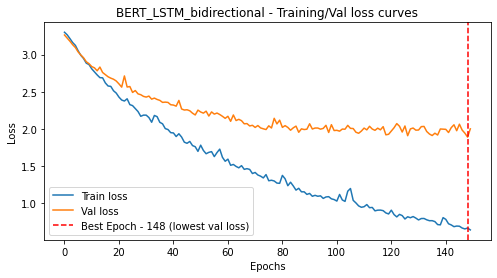

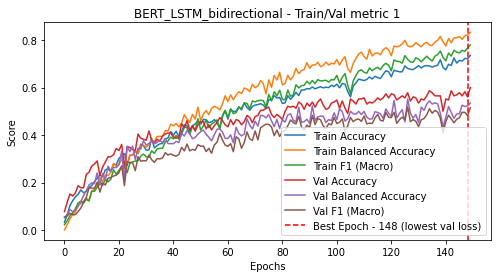

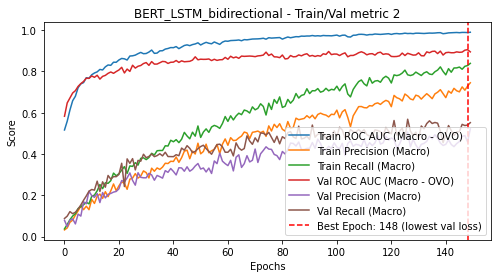

In [49]:
# #Clear memory
# import gc
# torch.cuda.empty_cache()
# gc.collect()

# #Begin training
# results = custom_train_val_loop.train_model(model = model,
#                       train_dataloader = train_dataloader,
#                       val_dataloader = val_dataloader,
#                       optimizer = optimizer,
#                       loss_fn = loss_fn,
#                       device = device,
#                       target_dir = target_dir,
#                       figure_dir = figure_dir,
#                       model_name = model_name,
#                       epochs = epochs)

## Test set evaluation

In [60]:
#instantiate model with the same architecture
loaded_model_2 = BertClassifier(output_shape = output_shape, bidirectional=True).to(device)

#since I saved many keys in the pth file, I need to specify that I want to load model_state_dict.
loaded_model_2.load_state_dict(torch.load(f = '..\model\BERT_LSTM_bidirectional_best_epoch_148.pth')['model_state_dict'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Inferencing on cuda.


  0%|          | 0/29 [00:00<?, ?it/s]

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nut19\an

                            precision    recall  f1-score   support

                Bariatrics       0.00      0.00      0.00         2
Cardiovascular / Pulmonary       0.70      0.54      0.61        35
Cosmetic / Plastic Surgery       0.00      0.00      0.00         1
                 Dentistry       0.00      0.00      0.00         2
               Dermatology       0.50      0.67      0.57         3
      Diets and Nutritions       1.00      1.00      1.00         1
      ENT - Otolaryngology       0.55      0.67      0.60         9
             Endocrinology       0.50      0.50      0.50         2
          Gastroenterology       0.47      0.35      0.40        20
          General Medicine       0.38      0.40      0.39        20
     Hematology - Oncology       0.27      0.57      0.36         7
                Nephrology       0.09      0.17      0.12         6
                 Neurology       0.46      0.92      0.62        13
              Neurosurgery       1.00      0.25

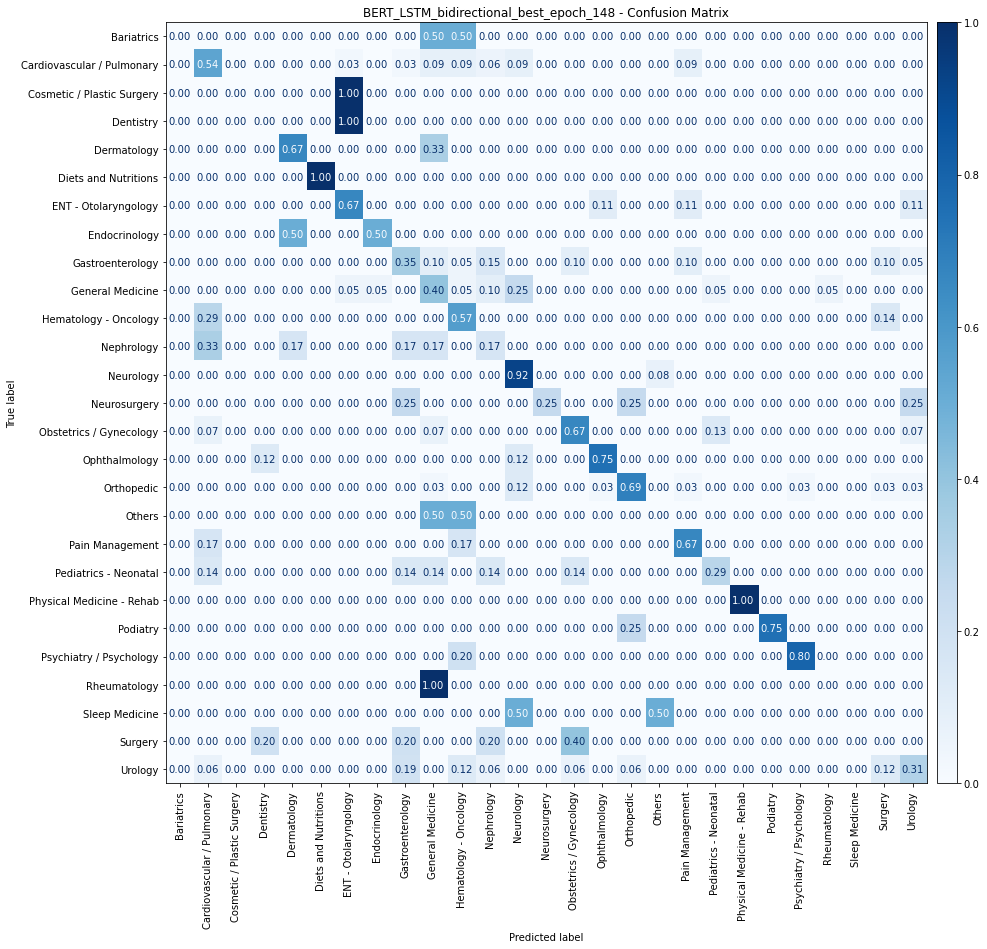

---------------------
Inference time for all test sample (cuda): 4.65 seconds
Number of all sample: 230 samples
Inference time for one sample (cuda): 0.02 seconds
---------------------
Accuracy: 0.52
Balanced accuracy: 0.44
ROC AUC (Macro - OVO): 0.91
Precision (Macro): 0.45
Recall (Macro): 0.44
F1 (Macro): 0.43
---------------------
Saving results dictionary as pickle file at (..\model\BERT_LSTM_bidirectional_best_epoch_148_test_results.pkl)


In [61]:
#initialize parameter
results_dir = '..\model'
figure_dir = '..\image'

results = test_set_evaluation.test_set_report(model = loaded_model_2,
                                              model_file_name = 'BERT_LSTM_bidirectional_best_epoch_148',
                                              results_dir = results_dir,
                                              figure_dir = figure_dir,
                                              test_dataloader = test_dataloader,
                                              class_map = class_number)

# Results Comparison - 2

In [80]:
model_results = []
with open('..\model\BERT_LSTM_base_best_epoch_107_test_results.pkl', 'rb') as f:
    loaded_results_1 = pickle.load(f) 
model_results.append(loaded_results_1)
with open('..\model\BERT_LSTM_truncate_left_best_epoch_144_test_results.pkl', 'rb') as f:
    loaded_results_2 = pickle.load(f)    
model_results.append(loaded_results_2)
with open('..\model\BERT_LSTM_bidirectional_best_epoch_148_test_results.pkl', 'rb') as f:
    loaded_results_3 = pickle.load(f)    
model_results.append(loaded_results_3)

In [83]:
columns_name = {'model_name':'Model', 
                'test_f1':'F1', 
                'test_precision':'Precision', 
                'test_recall':'Recall', 
                'test_balanced_accuracy':'Balanced Accuracy', 
                'inference_time_one_sample':'Inference time for 1 sample'}
pd.set_option('display.precision', 3)
pd.DataFrame(model_results, columns = ['model_name', 'test_f1', 'test_precision', 'test_recall', 'test_balanced_accuracy', 'inference_time_one_sample']).rename(columns = columns_name).sort_values('F1', ascending= False)

Model     F1  Precision  Recall  \
2  BERT_LSTM_bidirectional_best_epoch_148  0.429      0.453   0.443   
0       BERT_LSTM_base_best_epoch_107.pth  0.412      0.417   0.441   
1  BERT_LSTM_truncate_left_best_epoch_144  0.350      0.351   0.369   

   Balanced Accuracy  Inference time for 1 sample  
2              0.443                        0.020  
0              0.441                        0.015  
1              0.369                        0.014

Using BLSTM did improve our F1 by around 2% with little increase in inference time. Nevertheless, the result still is not good enough for practical use. Sending a patient to the wrong specialty could mean a huge waste of time and potentially can cause death. I would pernally accept F1 of > 90% for this system to be used. Also, from looking at the confusion matrix for all model, minority classes such as bariatrics, dentristry or even the group "other" have not been correctly classified at all which might be the problem of the corpus itself as it has too little data for those classes. The bottle neck limitation could come from the tokenizer, which is not intended for medical corpus, the base BERT, which has not been pre-trained on medical data and the quality of the corpus itself (tool ittle data for some classes).

To further improve performance, here are some strategies for future experiment:
- Further group minority classes into one class during preprocessing.
- Custom tokenizer to correctly tokenize the word.
- Use other BERT model which has been pre-trained on domain-specific task such as [PubmedBERT](https://arxiv.org/pdf/2007.15779.pdf).
- Unfreeze more layer during training to allow for fine-tuning.
- Try other truncation study such as middle, head+tail or hierarchical.
- Utilize other tranformer-based model which allow for longer context length such as [Longformer](https://arxiv.org/pdf/2004.05150.pdf) which support up to 4,096 tokens.

# Old code dump - for back up purpose. Nothing to see here.

## Preprocessing

In [50]:
# # Create a boolean mask that is True for rows where the "medical_specialty" column contains the desired string.
# mask = df_clean_1['medical_specialty'].str.contains('Speech - Language|Hospice - Palliative Care|Radiology|Chiropractic|Allergy / Immunology', case=False) #| is an OR operator in re

# # Find the index of the rows that match the mask and drop it
# rows_to_change = df_clean_1.loc[mask].index

# print(f'There are {len(df_clean_1)} samples.')
# df_clean_1= df_clean_1.drop(rows_to_drop).reset_index(drop = True) #Don't forget to reset index.
# print(f'Drop specialties with < 10 samples.')
# print(f'There are {len(df_clean_1)} samples left.')

Now there are less duplicate. Then we drop the overlapping specialty and keep only the first one.

In [51]:
#define function to extract first chunk of specialty
# def extract_first_chunk(string):
#     # Extract the first chunk of the string using a regular expression
#     match = re.search('^(.+?)\s*/', string)
#     if match:
#         return match.group(1)
#     else:
#         return string
    
# #test on all unique label    
# for i in df_text.medical_specialty.unique():
#     print(f'Original label is: {i}')
#     print(f'After extraction:  {extract_first_chunk(i)}\n')

In [52]:
# #define function to extract first chunk of specialty
# def extract_first_chunk(string):
#     '''
#     Extract the first chunk of the string.
    
#     The regular expression ^(.+?)\s*/ can be broken down into the following components:
#     ^: This asserts the position at the start of the line. The regular expression will only match if the pattern begins at the start of the string.
#     (.+?): This part is a capturing group that matches one or more characters.
#         .: The dot matches any single character except newline characters.
#         +: This quantifier means "one or more" of the preceding element. In this case, it means one or more of any character.
#         ?: This makes the + quantifier non-greedy, meaning it will match as few characters as possible while still satisfying the pattern. 
#         Without the ?, the + would be greedy and try to match as many characters as possible, which could lead to incorrect matches in some cases.
#     \s*: This matches zero or more whitespace characters (spaces, tabs, newlines, etc.).
#         \s: This matches any whitespace character.
#         *: This quantifier means "zero or more" of the preceding element. In this case, it means zero or more whitespace characters.
#     /: This is a literal forward slash character that must be matched.

#     In summary, this regular expression matches a pattern that starts at the beginning of the line, captures one or more characters until it reaches the first forward slash, 
#     and allows for zero or more whitespace characters before the forward slash. The non-greedy quantifier ? ensures that the regular expression stops at the first forward slash it encounters.
    
#     We then use the search method to find match. If match, return the first group. If not, return just the original string.
#     '''
#     match = re.search('^(.+?)\s*/', string)
        
#     if match:
#         return match.group(1)
#     else:
#         return string
    

# #test on all unqie label    
# for i in df_text.medical_specialty.unique():
#     print(f'Original label is: {i}')
#     print(f'After extraction:  {extract_first_chunk(i)}\n')

The restuls appear to be OK. Now we can apply it to the df.

In [53]:
# # Apply the custom function to all rows in the 'medical_specialty' column
# df_text['medical_specialty_first_chunk'] = df_text['medical_specialty'].apply(extract_first_chunk)
# df_text

## Custom dataset creation

In [54]:
# #instantiate tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# max_length = 512
# batch_size = 8

# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

# class my_dataset(torch.utils.data.Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length, device)-> None:
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         self.tokenized_texts = [self.tokenizer(text, padding='max_length', max_length = max_length, truncation=True, return_tensors="pt") for text in texts] #tokenized to raw text
#         self.labels = labels
#         self.device = device

#     def __len__(self):
#         "Returns the total number of samples."
#         return len(self.labels)


#     def __getitem__(self, idx):
#         "Returns one sample of data (tokenized text and label)"        
#         text = self.tokenized_texts[idx].to(device) #Send to device at this stage. Without this it fail at certain minibatch and I have no clue why. It just worked I swear.
#         label = self.labels[idx]

#         return text, label #returns tokenized text (which for BERT is a dictionry of {'input_ids':tensor,'token_type_ids':tensor, attention_mnask:tensor}

# # Instantiate custom Dataset
# train_data = my_dataset(x_train, y_train, tokenizer, max_length, device)
# val_data = my_dataset(x_val, y_val, tokenizer, max_length, device)
# test_data = my_dataset(x_test, y_test, tokenizer, max_length, device)

# # Instantiate data loader
# train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last= True)
# val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

BERT -> Linear layer, no LSTM

In [55]:
# #backup of old code before using LSTM
# class BertClassifier(nn.Module):

#     def __init__(self, output_shape, dropout=0.5):

#         super(BertClassifier, self).__init__()

#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, output_shape) 

#         #The embedding vector from CLS token is 768
#         #The output shape is equal to the class number
#         #self.relu = nn.ReLU() no relu in this example

#     def forward(self, input_id, mask):

#         _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)  
#         #return '_' which is all embedding token (torch.Size([1, ,512, 768])) and pooled_output which is only the [CLS] token embedding (torch.Size([1, 768])).
#         #You can see the output with something like this: bert(input_ids=train_data[random_number][0].input_ids, attention_mask=train_data[random_number][0].attention_mask,return_dict=False)
#         #For classification we only use the CLS token to classify
        
#         #dropout_output = self.dropout(pooled_output)
#         #linear_output = self.linear(dropout_output)
#         #final_layer = self.relu(linear_output)

#         return self.linear(self.dropout(pooled_output))
    
# #Instantiate model    
# model_0 = BertClassifier(output_shape = output_shape).to(device) #don't forget to send to device 

# #See model summary with torchinfo
# # do a test pass through of an example inout data
# #Bert expect two input, (input_ids, attention_mask) from the tokenizer like this: model_0(input_ids, attention_mask)
# example_input_ids = torch.randint(0, 100, (1, 512)).to(device)
# example_attention_mask = torch.ones((1, 512)).to(device)
# summary(model_0, input_data=[example_input_ids, example_attention_mask], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

## Custom train loop

In [56]:
# """
# Custom train and val loop
# """

# import torch
# from save_model import save_model
# from tqdm.auto import tqdm
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
# import matplotlib.pyplot as plt


# def train_model(model: torch.nn.Module,
#                 train_dataloader: torch.utils.data.DataLoader,
#                 val_dataloader: torch.utils.data.DataLoader,
#                 optimizer: torch.optim.Optimizer,
#                 loss_fn: torch.nn.Module,
#                 target_dir: str,
#                 figure_dir: str,
#                 model_name: str,
#                 epochs: int = 50,
#                 device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"):


#     """Full training/validate loop for a pytorch model and save model with the least loss

#     Note: 
#     - This function's logits is passed directly to the loss_function( for use with loss function such as crossentropy or BCEwithlogits).
#     - If you want to use loss function which accept other input, you need to modify the training code
#     - Does not utilize early stopping, only early save with val loss as criteria.
#     - Automatically save model as .pth. It saves state_dict, epoch, best_val_loss and optimizer_state_dict.
#     - Autoamtically save model's training result in pickle file in the same folder as the model.
#     - The metrics used is f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score from scikitlearn.metrics. 
#     - Depends on other custom function, save_model, found in utils_save_model.py
#     - Automatically plot loss and metrics using matplotlib and save figure as SVG in figure_dir folder.
#     - Device is prefebly setup in the beginning of the code in the device agnostic code cell
    

#   Args:
#     model: A PyTorch model to be trained and tested.
#     train_dataloader: A DataLoader instance for the model to be trained on.
#     val_dataloader: A DataLoader instance for the model to be validated on.
#     - The code unpack 2 variables from the data loader: X,y. X is output of bert tokenizer which has input_ids, attention_mask and token_type_ids
#     - Since BERT expect input_ids and attention_mask, the input to the model needs to be X.input_ids, X.attention_mask

    
#     epochs: An integer indicating how many epochs to train for.
#     optimizer: A PyTorch optimizer to help minimize the loss function.
#     loss_fn: A PyTorch loss function to calculate loss on both datasets.
#     device: A target device to compute on (e.g. "cuda" or "cpu").
#     target_dir: target directory name to save the best model and train results with the least loss
#     figure_dir: target directory name to save figure of plot
#     model_name: Name of the model. Do not include .pth in the name.
    

#   Returns:
#     A dictionary of training and testing values for later plotting
#     In the form: {train_loss_values: [...],
#                   val_loss_values: [...],
#                   etc...} 
#     """
    
#     print(f'Training on {device}.')
#     # Create empty loss lists to track values
    
#     train_loss_values = []
#     val_loss_values = []
#     epoch_count = []
    
#     train_accuracy_values = []
#     train_balanced_accuracy_values = []
#     train_f1_values = []
#     train_roc_auc_values = []
#     train_precision_values = []
#     train_recall_values = []    
    
    
    
#     val_accuracy_values = []
#     val_balanced_accuracy_values = []
#     val_f1_values = []
#     val_roc_auc_values = []
#     val_precision_values = []
#     val_recall_values = []   
    
    
#     #initialize best lost
#     val_loss_best = float('inf') #initialize best loss to inifite

#     # Create training and testing loop
#     for epoch in tqdm(range(epochs)): #use tqdm for progressbar
#         print(f"Epoch: {epoch}\n-------") #print epoch
#         ### Training
#         train_loss = 0 #default train loss for that epoch.
#         y_true_train, y_pred_train, y_prob_train = [], [], []  # Initialize empty lists for true and predicted labels
#         y_true_val, y_pred_val, y_prob_val = [], [], []  # Initialize empty lists for true and predicted labels
        
#         #This is just for tracking purpose
        
#         # Add a loop to loop through training mini batches
#         for batch, (X, y) in enumerate(train_dataloader): 
#             #loop throuugh all minibatch in an epoch
#             #We actually do not need to enumerate the dataloader and define batch
#             #It can be just for X, y, path in train_dataloader: 
#             #But batch can be used to keep track of progress of batch in each epoch so I just leave it in case you want to track the number of batch done
            
#             X, y = X.to(device), y.to(device)
            
#             model.train()  #set mode
            
#             # 1. Forward pass
#             y_logits = model(X.input_ids.squeeze(), X.attention_mask.squeeze()) #squeeze to get rid of extra dimension before inputting into BERT
#             y_prob = torch.softmax(y_logits, dim = 1)
#             y_pred = torch.argmax(y_prob, dim=1)
            
#             #To get y_pred, we convert logits to probability using softmax in case of multiclass).
#             #Then use argmax to get the label
#             #This is not needed for training since we use crossentropyloss which can directly use logits. However, we do it to calculate metrics.
            
            
#             y_true_train.extend(y.tolist()) #accumulate true label
#             y_prob_train.extend(y_prob.tolist())
#             y_pred_train.extend(y_pred.tolist()) #accumulate pred label
            
#             # 2. Calculate loss (per mini batch)
#             #minibatch gradient descent calculate the loss and optimize the weight per mini batches 
#             #as opposed to calculating and optimizing after all data has bee seen in an epoch
#             loss = loss_fn(y_logits, y.type(torch.int64)) #Directly pass logits for Cross Entropy loss

            
#             train_loss += loss # accumulatively add up the loss from ech minibatches fo tracking purpose
       
#             # 3. Optimizer zero grad
#             optimizer.zero_grad()

#             # 4. Loss backward
#             loss.backward()

#             # 5. Optimizer step
#             optimizer.step() #optimize network per mini batches batch
            
#             # Print out how many samples or batch that have been seen every x iteration
#             #sample
#             # if batch % 1 == 0:
#             #     print(f'Looked at {batch * len(X)}/{len(train_dataloader)} samples', end='\r')
#             #batch
#             print(f'Number of minibatch: {batch}/{len(train_dataloader)} batches', end='\r')

        
#         #Find average train loss per minibatch

#         train_loss /= len(train_dataloader)
                
#         #Calculate metrics for that epoch using the accumulated label
#         train_accuracy = accuracy_score(y_true_train, y_pred_train) 
#         train_balanced_accuracy = balanced_accuracy_score(y_true_train, y_pred_train, adjusted = True) 
#         train_f1_score = f1_score(y_true_train, y_pred_train, average = 'weighted', zero_division = 'warn')   
#         train_roc_auc_score = roc_auc_score(y_true_train, y_prob_train, average = 'macro', multi_class = 'ovo') #Documentation on Sklearn stated that ovo with macro si insensitive to class imbalance
#         train_precision = precision_score(y_true_train, y_pred_train, average = 'weighted', zero_division = 'warn')   
#         train_recall = recall_score(y_true_train, y_pred_train, average = 'weighted', zero_division = 'warn')                         
             

        
#         ### val
#         # Setup variables for accumulatively adding up loss and accuracy for that epoch
#         val_loss = 0
#         model.eval()

#         with torch.inference_mode(): # context management
#             for X, y in val_dataloader: # Loop through all mini batch in the val set. We don't use enumerate for this because
#                 # We don't care to track what test minibatch the progress is at.
#                 X, y = X.to(device), y.to(device)

#                 val_logits = model(X.input_ids.squeeze(), X.attention_mask.squeeze())
#                 val_prob = torch.softmax(val_logits, dim = 1)
#                 val_pred = torch.argmax(val_prob, dim=1)
            
            
#                 # 2. Calculate loss (accumatively)
#                 val_loss += loss_fn(val_logits, y.type(torch.int64)) # accumulatively add up the loss per mini batch for that epoch

#                 # 3. accumulate label for metric calculation
#                 y_true_val.extend(y.tolist()) #accumulate true label
#                 y_prob_val.extend(val_prob.tolist()) #accumualte predicted prob        
#                 y_pred_val.extend(val_pred.tolist()) #accumulate pred label


#             # Calculations on val metrics need to happen inside torch.inference_mode()
#             # Divide total val loss by length of val dataloader (per batch)
#             val_loss /= len(val_dataloader)
            
#             #Now you get the average test loss per minibatch for that epoch

#             # For metric
#             # Calculate metric based on accumulate true and pred label
#             val_accuracy = accuracy_score(y_true_val, y_pred_val)
#             val_balanced_accuracy = balanced_accuracy_score(y_true_train, y_pred_train, adjusted = True) 
#             val_f1_score = f1_score(y_true_train, y_pred_train, average = 'weighted', zero_division = 'warn')   
#             val_roc_auc_score = roc_auc_score(y_true_train, y_prob_train, average = 'macro', multi_class = 'ovo') #Documentation on Sklearn stated that ovo with macro si insensitive to class imbalance
#             val_precision = precision_score(y_true_train, y_pred_train, average = 'weighted', zero_division = 'warn')   
#             val_recall = recall_score(y_true_train, y_pred_train, average = 'weighted', zero_division = 'warn')
            
            
#             #for save model
#             #check if the loss is less than the best val loss (using loss as threshold). You can change this to any metric.
#             if val_loss < val_loss_best:
#                 val_loss_best = val_loss
#                 best_epoch = epoch
#                 best_checkpoint = {
#                     'epoch': epoch,
#                     'best_val_loss': val_loss_best,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict()
#                 }
                
            
#         #Printing of statistic every x epoch. Default to every epoch.    
#         if epoch % 1 == 0:
            
#             epoch_count.append(epoch) #append the number of epoch to be used as X axis to plot loss
            
#             train_loss_values.append(train_loss.item()) #append data for train loss to plot
            
#             val_loss_values.append(val_loss.item()) #append data for val loss to plot
            
#             #append data for metric to plot
#             train_accuracy_values.append(train_accuracy)
#             train_balanced_accuracy_values.append(train_balanced_accuracy)
#             train_f1_values.append(train_f1_score) 
#             train_roc_auc_values.append(train_roc_auc_score)
#             train_precision_values.append(train_precision)
#             train_recall_values.append(train_recall)             
            
            
#             val_accuracy_values.append(val_accuracy)
#             val_balanced_accuracy_values.append(val_balanced_accuracy)
#             val_f1_values.append(val_f1_score)
#             val_roc_auc_values.append(val_roc_auc_score)
#             val_precision_values.append(val_precision)
#             val_recall_values.append(val_recall)              
                     
#         ## Print out what's happening
#         print(f"Train loss: {train_loss:.5f} | Val loss: {val_loss:.5f}")
#         print(f"Train accuracy: {train_accuracy:.5f} | Train balanced accuracy: {train_balanced_accuracy:.5f} | Train F1 score: {train_f1_score:.5f} | Train ROC AUC score: {train_roc_auc_score:.5f}")    
#         print(f"Validation accuracy: {val_accuracy:.5f} | Validation balanced accuracy: {val_balanced_accuracy:.5f} | Validation F1 score: {val_f1_score:.5f} | Val ROC AUC score: {val_roc_auc_score:.5f}\n")
        
#     #Gather results into dictionary
#     results = {'epochs': epoch_count,
#                'best_epoch': best_epoch,
#                'train_loss_values': train_loss_values,
#                'val_loss_values': val_loss_values,
#                'train_accuracy_values': train_accuracy_values,
#                'val_accuracy_values': val_accuracy_values,
#                'train_balanced_accuracy_values': train_balanced_accuracy_values,
#                'val_balanced_accuracy_values': val_balanced_accuracy_values,
#                'train_f1_values': train_f1_values,
#                'val_f1_values': val_f1_values,               
#                'train_roc_auc_values': train_roc_auc_values,
#                'val_roc_auc_values': val_roc_auc_values,
#                'train_precision_values': train_precision_values,
#                'val_precision_values': val_precision_values,
#                'train_recall_values': train_recall_values,
#                'val_recall_values': val_recall_values       
#     }    

#     #Saving model with the best epoch.
#     print(f'The best model is at epoch {best_epoch}')
#     print('Saving model state_dict, optimizer, best_val_loss, epoch')
#     save_model(best_checkpoint, target_dir=target_dir, model_name=f'{model_name}_best_epoch_{best_epoch}.pth')
    
#     #Saving the result dictionary
#     results_file_path = f'{target_dir}\{model_name}_best_epoch_{best_epoch}_train_val_results.pkl'    
#     print('Saving results dictionary as pickle file')
#     with open(results_file_path, 'wb') as file:  # Open the file in write mode
#         # Write the dictionary to the pickle file
#         pickle.dump(results, file)    
    
#     #plot and save curves
#     # Create target directory
#     figure_dir_path = Path(figure_dir)
#     figure_dir_path.mkdir(parents=True,
#                         exist_ok=True)
#     figure_save_path = figure_dir_path 


#     print('Plotting and saving figure')
#     # Plot the loss curves 
#     plt.figure(figsize=(8, 4))
#     plt.plot(results['epochs'], results['train_loss_values'], label="Train loss")
#     plt.plot(results['epochs'], results['val_loss_values'], label="Val loss")
#     plt.axvline(results['best_epoch'], linestyle='--', color='r',label=f'Best Epoch - {best_epoch} (lowest val loss)')
#     plt.title(f'{model_name} - Training/Val loss curves')
#     plt.ylabel("Loss")
#     plt.xlabel("Epochs")
#     plt.legend()
#     plt.savefig(f'{figure_save_path}\{model_name}_best_epoch_{best_epoch}_train_val_loss_curves.svg', format='svg')
#     plt.show()

#     # Plot the metric curves 
#     plt.figure(figsize=(8, 4))
#     plt.plot(results['epochs'], results['train_accuracy_values'], label="Train Accuracy")    
#     plt.plot(results['epochs'], results['train_balanced_accuracy_values'], label="Train Balanced Accuracy")
#     plt.plot(results['epochs'], results['train_f1_values'], label="Train F1")
#     plt.plot(results['epochs'], results['val_accuracy_values'], label="Val Accuracy")    
#     plt.plot(results['epochs'], results['val_balanced_accuracy_values'], label="Val Balanced Accuracy")
#     plt.plot(results['epochs'], results['val_f1_values'], label="Val F1")
#     plt.axvline(results['best_epoch'], linestyle='--', color='r',label=f'Best Epoch - {best_epoch} (lowest val loss)')
#     plt.title(f'{model_name} - Train/Val metric 1')
#     plt.ylabel("Score")
#     plt.xlabel("Epochs")
#     plt.legend()
#     plt.savefig(f'{figure_save_path}\{model_name}_best_epoch_{best_epoch}_train_val_metric_1.svg', format='svg')
#     plt.show()

#     # Plot the additional metric curves 
#     plt.figure(figsize=(8, 4))
#     plt.plot(results['epochs'], results['train_roc_auc_values'], label="Train ROC AUC")    
#     plt.plot(results['epochs'], results['train_precision_values'], label="Train Precision")
#     plt.plot(results['epochs'], results['train_recall_values'], label="Train Recall")
#     plt.plot(results['epochs'], results['val_roc_auc_values'], label="Val ROC AUC")    
#     plt.plot(results['epochs'], results['val_precision_values'], label="Val Precision")
#     plt.plot(results['epochs'], results['val_recall_values'], label="Val Recall")
#     plt.axvline(results['best_epoch'], linestyle='--', color='r',label=f'Best Epoch: {best_epoch} (lowest val loss)')
#     plt.title(f'{model_name} - Train/Val metric 2')
#     plt.ylabel("Score")
#     plt.xlabel("Epochs")
#     plt.legend()
#     plt.savefig(f'{figure_save_path}\{model_name}_best_epoch_{best_epoch}_train_val_metric_2.svg', format='svg')
#     plt.show()
    
    
#     return results
